In [6]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt



In [7]:
# Get CIFAR10 Dataset
data_set = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose(
    [transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(256,512,4,2,1,bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        
        self.verify = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), 
            nn.Sigmoid()
        )
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, passed_input):
        passed_input = self.main(passed_input)
        validity = self.verify(passed_input)
        output_labels = self.labels(passed_input)
        
        # resize
        validity = validity.view(-1)
        output_labels = output_labels.view(-1,11)
        return validity, output_labels

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.emb = nn.Embedding(10,100)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,512,4,1,0,bias = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias = False),
            nn.Tanh()
        )
        
    def forward(self, noise, inputLabels):
        embLabels = self.emb(inputLabels)
        temp = torch.mul(noise, embLabels)
        temp = temp.view(-1, 100, 1, 1)
        return self.main(temp)

In [11]:
# Create Generator and Discriminator and apply initial weights
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_init)
generator.apply(weights_init)

Generator(
  (emb): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [12]:
# Setup optimizers 
dis_optim = optim.Adam(discriminator.parameters(), 0.0002, betas = (0.5,0.999))
gen_optim = optim.Adam(generator.parameters(), 0.0002, betas = (0.5,0.999))
criterion = nn.BCELoss()

# Parameters for training
num_epochs = 10
real_labels_tensor = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels_tensor = 0.3 * torch.rand(10, device = device)

# Variables to track training progress
counter_list = []
counter = 0
gen_loss_list = []
dis_loss_list = []


In [13]:
import os
import torch
import torch.nn.functional as F
import torchvision.utils as vutils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move models to device
discriminator.to(device)
generator.to(device)

# Create output folder if not exists
if not os.path.exists('ACGANOutput'):
    os.makedirs('ACGANOutput')

# Move models to device
discriminator.to(device)
generator.to(device)

# Setup optimizers 
dis_optim = optim.Adam(discriminator.parameters(), 0.0002, betas = (0.5,0.999))
gen_optim = optim.Adam(generator.parameters(), 0.0002, betas = (0.5,0.999))
criterion = nn.BCELoss()

# Parameters for training
num_epochs = 10
real_labels_tensor = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels_tensor = 0.3 * torch.rand(10, device = device)

# Variables to track training progress
counter_list = []
counter = 0
gen_loss_list = []
dis_loss_list = []
lr = 0.0002
num_classes = 10 
batch_size = 10

# Create output folder if not exists
if not os.path.exists('ACGANOutput'):
    os.makedirs('ACGANOutput')

# Training algorithm for discriminator and generator
for epoch in range(0, num_epochs):
    
    # Iterate through all batches
    for index, (data, image_labels) in enumerate(data_loader, 0):
        counter += 1
        counter_list.append(counter)
        
        # make data avaialbe for cuda
        data = data.to(device)
        image_labels = image_labels.to(device)
        size_of_batch = data.size(0)
        labels_real = real_labels_tensor[index % 10]
        labels_fake = fake_labels_tensor[index % 10]
        class_labels_fake = 10 * torch.ones((size_of_batch, ), dtype = torch.long, device = device)
        
        # Periodically switch labels
        if index % 25 == 0:
            temp = labels_real
            labels_real = labels_fake
            labels_fake = temp
        
        # Train Discriminator with real data
        labels_for_validate = torch.full((size_of_batch, ), labels_real, device = device)
        dis_optim.zero_grad() 
        validity, output_labels = discriminator(data)       
        dis_real_valid_error = criterion(validity, labels_for_validate)            
        dis_real_label_error = F.nll_loss(output_labels, image_labels)
        dis_real_error = dis_real_valid_error + dis_real_label_error
        dis_real_error.backward()
        valid_mean1 = validity.mean().item()        
        
        # Train Discriminator with fake data
        dis_fake_labels = torch.randint(0, 10, (size_of_batch, ), dtype = torch.long, device = device)
        noise = torch.randn(size_of_batch, 100, device = device)  
        labels_for_validate.fill_(labels_fake)
        fake_output = generator(noise, dis_fake_labels)
        validity, output_labels = discriminator(fake_output.detach())       
        dis_fake_valid_error = criterion(validity, labels_for_validate)
        dis_fake_label_error = F.nll_loss(output_labels, class_labels_fake)
        dis_fake_error = dis_fake_valid_error + dis_fake_label_error
        dis_fake_error.backward()
        final_dis_error = dis_real_error + dis_fake_error
        valid_mean2 = validity.mean().item()
        dis_optim.step()
    
        # Train Generator
        labels_for_validate.fill_(1)
        labels_for_gen = torch.randint(0, 10, (size_of_batch, ), device = device, dtype = torch.long)
        noise = torch.randn(size_of_batch, 100, device = device)  
        gen_optim .zero_grad()
        fake_output = generator(noise, labels_for_gen)
        validity, output_labels = discriminator(fake_output)
        gen_valid_error = criterion(validity, labels_for_validate)        
        gen_label_error = F.nll_loss(output_labels, labels_for_gen)
        final_gen_error = gen_valid_error + gen_label_error
        final_gen_error.backward()
        valid_mean3 = validity.mean().item()
        gen_optim .step()
        
        
        print("[{}/{}] [{}/{}] D(x): [{:.4f}] D(G): [{:.4f}/{:.4f}] GLoss: [{:.4f}] DLoss: [{:.4f}] DLabel: [{:.4f}] "
              .format(epoch, num_epochs, index, len(data_loader), valid_mean1, valid_mean2, valid_mean3, final_gen_error, final_dis_error,
                      dis_real_label_error+ dis_fake_label_error + gen_label_error))
        
        # Save errors for graphing
        dis_loss_list.append(final_dis_error.cpu().detach().numpy())
        gen_loss_list.append(final_gen_error.cpu().detach().numpy())
        
    # Save images to folder
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = generator(noise, labels)
    vutils.save_image(images.detach(),'ACGANOutput/fake_samples_epoch_%03d.png' % (epoch), normalize = True)
    
    # Save counter list to a variable
counter_list_variable = counter_list
print(counter_list_variable)

# Print generator loss list
print("Generator Loss List:")
print(*gen_loss_list, sep=', ')

# Print discriminator loss list
print("Discriminator Loss List:")
print(*dis_loss_list, sep=', ')

[0/10] [0/391] D(x): [0.3531] D(G): [0.2475/0.8963] GLoss: [5.6468] DLoss: [8.8463] DLabel: [12.0899] 
[0/10] [1/391] D(x): [0.5179] D(G): [0.9158/0.7510] GLoss: [7.1281] DLoss: [7.7856] DLabel: [11.2983] 
[0/10] [2/391] D(x): [0.5366] D(G): [0.7320/0.3665] GLoss: [7.5430] DLoss: [6.2156] DLabel: [10.5403] 
[0/10] [3/391] D(x): [0.5633] D(G): [0.5277/0.1735] GLoss: [7.9260] DLoss: [5.4313] DLabel: [9.6385] 
[0/10] [4/391] D(x): [0.6283] D(G): [0.5093/0.1064] GLoss: [9.2570] DLoss: [5.0340] DLabel: [10.1637] 
[0/10] [5/391] D(x): [0.6141] D(G): [0.4975/0.1263] GLoss: [9.7055] DLoss: [4.8291] DLabel: [10.7822] 
[0/10] [6/391] D(x): [0.7320] D(G): [0.6770/0.0941] GLoss: [9.6792] DLoss: [4.6932] DLabel: [10.3059] 
[0/10] [7/391] D(x): [0.8029] D(G): [0.6289/0.0260] GLoss: [11.7980] DLoss: [5.0371] DLabel: [11.1162] 
[0/10] [8/391] D(x): [0.7025] D(G): [0.4271/0.0467] GLoss: [12.2211] DLoss: [4.3047] DLabel: [11.9323] 
[0/10] [9/391] D(x): [0.7238] D(G): [0.7050/0.0141] GLoss: [13.0298] DLo

[0/10] [81/391] D(x): [0.9197] D(G): [0.3553/0.0490] GLoss: [11.2539] DLoss: [2.8479] DLabel: [9.7965] 
[0/10] [82/391] D(x): [0.9480] D(G): [0.1575/0.0822] GLoss: [9.9895] DLoss: [2.9250] DLabel: [8.9881] 
[0/10] [83/391] D(x): [0.8889] D(G): [0.2952/0.0733] GLoss: [11.6191] DLoss: [3.2484] DLabel: [11.1328] 
[0/10] [84/391] D(x): [0.8348] D(G): [0.2633/0.0391] GLoss: [11.7914] DLoss: [2.4666] DLabel: [10.2072] 
[0/10] [85/391] D(x): [0.8117] D(G): [0.1499/0.1025] GLoss: [8.7250] DLoss: [2.2259] DLabel: [8.3272] 
[0/10] [86/391] D(x): [0.9092] D(G): [0.3639/0.0413] GLoss: [14.2325] DLoss: [2.4921] DLabel: [12.9889] 
[0/10] [87/391] D(x): [0.9246] D(G): [0.1431/0.0635] GLoss: [13.5824] DLoss: [2.7977] DLabel: [12.6559] 
[0/10] [88/391] D(x): [0.9095] D(G): [0.2253/0.3110] GLoss: [8.7196] DLoss: [2.1314] DLabel: [9.4147] 
[0/10] [89/391] D(x): [0.9706] D(G): [0.6413/0.0051] GLoss: [16.0307] DLoss: [2.5878] DLabel: [12.0955] 
[0/10] [90/391] D(x): [0.8978] D(G): [0.0239/0.0053] GLoss: [1

[0/10] [162/391] D(x): [0.9627] D(G): [0.1348/0.1613] GLoss: [7.8978] DLoss: [2.9694] DLabel: [7.8138] 
[0/10] [163/391] D(x): [0.9708] D(G): [0.2889/0.1631] GLoss: [8.3089] DLoss: [2.9378] DLabel: [8.3227] 
[0/10] [164/391] D(x): [0.9245] D(G): [0.2450/0.0859] GLoss: [9.5369] DLoss: [2.3563] DLabel: [8.8701] 
[0/10] [165/391] D(x): [0.9024] D(G): [0.1360/0.1287] GLoss: [8.0491] DLoss: [1.7970] DLabel: [7.7941] 
[0/10] [166/391] D(x): [0.9679] D(G): [0.2117/0.2657] GLoss: [6.9361] DLoss: [1.5865] DLabel: [7.2226] 
[0/10] [167/391] D(x): [0.9870] D(G): [0.3672/0.0837] GLoss: [9.8662] DLoss: [2.7823] DLabel: [9.0040] 
[0/10] [168/391] D(x): [0.9749] D(G): [0.1427/0.1348] GLoss: [9.1207] DLoss: [1.7065] DLabel: [8.7428] 
[0/10] [169/391] D(x): [0.9757] D(G): [0.2138/0.1231] GLoss: [9.1385] DLoss: [1.6802] DLabel: [8.5688] 
[0/10] [170/391] D(x): [0.9840] D(G): [0.2295/0.0594] GLoss: [9.8493] DLoss: [1.5122] DLabel: [8.5297] 
[0/10] [171/391] D(x): [0.9872] D(G): [0.0968/0.0730] GLoss: [9.

[0/10] [243/391] D(x): [0.9128] D(G): [0.5665/0.0422] GLoss: [13.4679] DLoss: [3.3931] DLabel: [12.2204] 
[0/10] [244/391] D(x): [0.5509] D(G): [0.0866/0.2395] GLoss: [7.4686] DLoss: [3.8825] DLabel: [8.8731] 
[0/10] [245/391] D(x): [0.9521] D(G): [0.4916/0.0666] GLoss: [10.7163] DLoss: [2.4406] DLabel: [10.1213] 
[0/10] [246/391] D(x): [0.9475] D(G): [0.2581/0.0636] GLoss: [11.6724] DLoss: [1.8615] DLabel: [10.4914] 
[0/10] [247/391] D(x): [0.9434] D(G): [0.2258/0.0820] GLoss: [10.8997] DLoss: [2.6264] DLabel: [10.0136] 
[0/10] [248/391] D(x): [0.9285] D(G): [0.1826/0.2471] GLoss: [7.8563] DLoss: [1.8494] DLabel: [8.0249] 
[0/10] [249/391] D(x): [0.9644] D(G): [0.5648/0.0340] GLoss: [13.4715] DLoss: [2.4132] DLabel: [11.4982] 
[0/10] [250/391] D(x): [0.8243] D(G): [0.1091/0.5477] GLoss: [6.6055] DLoss: [6.9352] DLabel: [8.1594] 
[0/10] [251/391] D(x): [0.8576] D(G): [0.8232/0.1598] GLoss: [9.6042] DLoss: [3.9937] DLabel: [9.6686] 
[0/10] [252/391] D(x): [0.6114] D(G): [0.3429/0.2308] 

[0/10] [324/391] D(x): [0.8982] D(G): [0.6128/0.0252] GLoss: [14.2429] DLoss: [3.5707] DLabel: [12.7085] 
[0/10] [325/391] D(x): [0.3009] D(G): [0.0545/0.7984] GLoss: [3.6157] DLoss: [8.8473] DLabel: [7.9965] 
[0/10] [326/391] D(x): [0.8434] D(G): [0.8287/0.5286] GLoss: [6.9923] DLoss: [4.7938] DLabel: [9.6988] 
[0/10] [327/391] D(x): [0.7830] D(G): [0.6366/0.3639] GLoss: [7.0885] DLoss: [3.5687] DLabel: [8.1572] 
[0/10] [328/391] D(x): [0.6586] D(G): [0.4832/0.4165] GLoss: [5.2226] DLoss: [3.4346] DLabel: [6.6849] 
[0/10] [329/391] D(x): [0.8130] D(G): [0.5354/0.2541] GLoss: [7.3953] DLoss: [3.0610] DLabel: [8.1379] 
[0/10] [330/391] D(x): [0.7299] D(G): [0.3040/0.2143] GLoss: [7.2953] DLoss: [2.4154] DLabel: [7.4337] 
[0/10] [331/391] D(x): [0.7459] D(G): [0.3250/0.2109] GLoss: [7.4236] DLoss: [2.7500] DLabel: [7.6144] 
[0/10] [332/391] D(x): [0.8049] D(G): [0.3629/0.2374] GLoss: [7.2164] DLoss: [3.0416] DLabel: [7.6745] 
[0/10] [333/391] D(x): [0.8016] D(G): [0.3589/0.2026] GLoss: [

[1/10] [12/391] D(x): [0.3934] D(G): [0.0288/0.2164] GLoss: [8.5295] DLoss: [5.6226] DLabel: [10.2958] 
[1/10] [13/391] D(x): [0.9349] D(G): [0.4649/0.1924] GLoss: [8.4764] DLoss: [3.1951] DLabel: [8.8299] 
[1/10] [14/391] D(x): [0.9218] D(G): [0.4831/0.0358] GLoss: [12.4680] DLoss: [2.7239] DLabel: [10.8702] 
[1/10] [15/391] D(x): [0.7907] D(G): [0.1220/0.0966] GLoss: [9.6266] DLoss: [1.8877] DLabel: [8.7198] 
[1/10] [16/391] D(x): [0.8286] D(G): [0.3290/0.2966] GLoss: [7.0405] DLoss: [2.0299] DLabel: [7.2824] 
[1/10] [17/391] D(x): [0.9404] D(G): [0.5873/0.0325] GLoss: [14.4470] DLoss: [3.1836] DLabel: [12.4624] 
[1/10] [18/391] D(x): [0.6177] D(G): [0.0624/0.1878] GLoss: [8.8478] DLoss: [3.5216] DLabel: [9.4836] 
[1/10] [19/391] D(x): [0.9141] D(G): [0.3335/0.2961] GLoss: [6.6497] DLoss: [1.9936] DLabel: [6.9556] 
[1/10] [20/391] D(x): [0.9211] D(G): [0.5044/0.0706] GLoss: [10.7402] DLoss: [2.4674] DLabel: [9.6889] 
[1/10] [21/391] D(x): [0.8638] D(G): [0.1331/0.0612] GLoss: [10.401

[1/10] [93/391] D(x): [0.7729] D(G): [0.2063/0.2313] GLoss: [7.7417] DLoss: [2.5765] DLabel: [7.7426] 
[1/10] [94/391] D(x): [0.8757] D(G): [0.3328/0.1410] GLoss: [8.6301] DLoss: [2.2660] DLabel: [8.1436] 
[1/10] [95/391] D(x): [0.8400] D(G): [0.2104/0.2814] GLoss: [6.0002] DLoss: [1.8691] DLabel: [6.2995] 
[1/10] [96/391] D(x): [0.8830] D(G): [0.3821/0.3151] GLoss: [7.0008] DLoss: [2.1227] DLabel: [7.5341] 
[1/10] [97/391] D(x): [0.9279] D(G): [0.4033/0.1415] GLoss: [9.1063] DLoss: [2.5229] DLabel: [8.6154] 
[1/10] [98/391] D(x): [0.7560] D(G): [0.2617/0.4448] GLoss: [5.1318] DLoss: [2.5788] DLabel: [6.1957] 
[1/10] [99/391] D(x): [0.9326] D(G): [0.6277/0.0842] GLoss: [10.3170] DLoss: [2.8485] DLabel: [9.7479] 
[1/10] [100/391] D(x): [0.7476] D(G): [0.1636/0.3325] GLoss: [6.9501] DLoss: [5.3192] DLabel: [7.5411] 
[1/10] [101/391] D(x): [0.7842] D(G): [0.5437/0.4898] GLoss: [5.1756] DLoss: [3.2587] DLabel: [6.5503] 
[1/10] [102/391] D(x): [0.7076] D(G): [0.6543/0.1311] GLoss: [9.3154] 

[1/10] [174/391] D(x): [0.9504] D(G): [0.4907/0.0653] GLoss: [10.3793] DLoss: [2.8112] DLabel: [9.4114] 
[1/10] [175/391] D(x): [0.6840] D(G): [0.1537/0.5929] GLoss: [4.9364] DLoss: [5.2636] DLabel: [6.0297] 
[1/10] [176/391] D(x): [0.8744] D(G): [0.6690/0.5630] GLoss: [5.9472] DLoss: [2.5592] DLabel: [7.0414] 
[1/10] [177/391] D(x): [0.8087] D(G): [0.6823/0.1879] GLoss: [8.6607] DLoss: [3.2460] DLabel: [8.5829] 
[1/10] [178/391] D(x): [0.5266] D(G): [0.3261/0.5152] GLoss: [4.4011] DLoss: [3.1361] DLabel: [5.5776] 
[1/10] [179/391] D(x): [0.8691] D(G): [0.6670/0.0413] GLoss: [13.5782] DLoss: [3.5032] DLabel: [12.6161] 
[1/10] [180/391] D(x): [0.4178] D(G): [0.0882/0.3746] GLoss: [5.9422] DLoss: [3.7925] DLabel: [7.4452] 
[1/10] [181/391] D(x): [0.9183] D(G): [0.5225/0.1287] GLoss: [9.9180] DLoss: [2.8527] DLabel: [9.3791] 
[1/10] [182/391] D(x): [0.6956] D(G): [0.2277/0.4231] GLoss: [5.8780] DLoss: [2.9379] DLabel: [6.6609] 
[1/10] [183/391] D(x): [0.8551] D(G): [0.5756/0.0870] GLoss: 

[1/10] [255/391] D(x): [0.5761] D(G): [0.2786/0.4786] GLoss: [4.7072] DLoss: [2.8132] DLabel: [5.7838] 
[1/10] [256/391] D(x): [0.8664] D(G): [0.6043/0.1468] GLoss: [9.5829] DLoss: [2.7841] DLabel: [9.6398] 
[1/10] [257/391] D(x): [0.7085] D(G): [0.2619/0.3155] GLoss: [6.4855] DLoss: [2.9461] DLabel: [7.2718] 
[1/10] [258/391] D(x): [0.8261] D(G): [0.4074/0.4483] GLoss: [5.1072] DLoss: [2.3008] DLabel: [5.9443] 
[1/10] [259/391] D(x): [0.8845] D(G): [0.5048/0.1729] GLoss: [7.8858] DLoss: [2.6896] DLabel: [8.0130] 
[1/10] [260/391] D(x): [0.7275] D(G): [0.2299/0.2159] GLoss: [6.4972] DLoss: [2.6314] DLabel: [6.9237] 
[1/10] [261/391] D(x): [0.8553] D(G): [0.3482/0.2126] GLoss: [6.5012] DLoss: [2.6772] DLabel: [6.6387] 
[1/10] [262/391] D(x): [0.8173] D(G): [0.3541/0.1739] GLoss: [7.6857] DLoss: [2.8195] DLabel: [7.5344] 
[1/10] [263/391] D(x): [0.7273] D(G): [0.3912/0.2494] GLoss: [6.5006] DLoss: [3.1296] DLabel: [7.0723] 
[1/10] [264/391] D(x): [0.8047] D(G): [0.4399/0.1220] GLoss: [8.

[1/10] [336/391] D(x): [0.8253] D(G): [0.4759/0.1849] GLoss: [7.9516] DLoss: [2.5609] DLabel: [8.1051] 
[1/10] [337/391] D(x): [0.8274] D(G): [0.3484/0.1701] GLoss: [7.7716] DLoss: [2.6592] DLabel: [7.6293] 
[1/10] [338/391] D(x): [0.7928] D(G): [0.3181/0.4014] GLoss: [5.0283] DLoss: [2.3915] DLabel: [5.8346] 
[1/10] [339/391] D(x): [0.9163] D(G): [0.5679/0.0775] GLoss: [10.1742] DLoss: [2.7565] DLabel: [9.4539] 
[1/10] [340/391] D(x): [0.6170] D(G): [0.2051/0.2865] GLoss: [5.7189] DLoss: [2.9439] DLabel: [6.5262] 
[1/10] [341/391] D(x): [0.8347] D(G): [0.4881/0.1548] GLoss: [7.4364] DLoss: [3.0306] DLabel: [7.4109] 
[1/10] [342/391] D(x): [0.6602] D(G): [0.2877/0.3332] GLoss: [5.0869] DLoss: [3.0968] DLabel: [5.8241] 
[1/10] [343/391] D(x): [0.8385] D(G): [0.5181/0.1689] GLoss: [7.5035] DLoss: [2.8797] DLabel: [7.3672] 
[1/10] [344/391] D(x): [0.7453] D(G): [0.2830/0.1959] GLoss: [6.4553] DLoss: [2.3799] DLabel: [6.3441] 
[1/10] [345/391] D(x): [0.7236] D(G): [0.3207/0.3228] GLoss: [5

[2/10] [27/391] D(x): [0.8032] D(G): [0.6480/0.1756] GLoss: [7.8567] DLoss: [3.2429] DLabel: [7.7751] 
[2/10] [28/391] D(x): [0.6140] D(G): [0.2926/0.4486] GLoss: [4.3435] DLoss: [2.9577] DLabel: [5.4556] 
[2/10] [29/391] D(x): [0.8715] D(G): [0.5120/0.2198] GLoss: [6.5982] DLoss: [2.6485] DLabel: [6.8810] 
[2/10] [30/391] D(x): [0.7901] D(G): [0.3195/0.1869] GLoss: [7.0281] DLoss: [2.1760] DLabel: [6.8172] 
[2/10] [31/391] D(x): [0.7313] D(G): [0.2737/0.2411] GLoss: [6.0946] DLoss: [2.5843] DLabel: [6.2211] 
[2/10] [32/391] D(x): [0.7778] D(G): [0.3683/0.3143] GLoss: [5.4524] DLoss: [2.7445] DLabel: [5.8501] 
[2/10] [33/391] D(x): [0.7945] D(G): [0.4836/0.2552] GLoss: [5.9691] DLoss: [2.8810] DLabel: [6.2894] 
[2/10] [34/391] D(x): [0.7425] D(G): [0.3502/0.1552] GLoss: [7.1542] DLoss: [2.5391] DLabel: [6.8607] 
[2/10] [35/391] D(x): [0.6248] D(G): [0.2673/0.5592] GLoss: [3.4117] DLoss: [2.6795] DLabel: [4.6466] 
[2/10] [36/391] D(x): [0.8746] D(G): [0.5921/0.2377] GLoss: [7.7695] DLos

[2/10] [108/391] D(x): [0.7596] D(G): [0.3683/0.3580] GLoss: [4.6474] DLoss: [2.3644] DLabel: [5.1880] 
[2/10] [109/391] D(x): [0.8160] D(G): [0.5408/0.1315] GLoss: [7.9317] DLoss: [2.7194] DLabel: [7.5642] 
[2/10] [110/391] D(x): [0.6439] D(G): [0.2223/0.3258] GLoss: [4.7647] DLoss: [2.6067] DLabel: [5.4437] 
[2/10] [111/391] D(x): [0.8559] D(G): [0.4226/0.2345] GLoss: [5.3596] DLoss: [2.5916] DLabel: [5.4970] 
[2/10] [112/391] D(x): [0.7374] D(G): [0.3200/0.4236] GLoss: [3.8115] DLoss: [2.9081] DLabel: [4.6913] 
[2/10] [113/391] D(x): [0.8233] D(G): [0.5301/0.1622] GLoss: [7.3811] DLoss: [3.0689] DLabel: [7.3148] 
[2/10] [114/391] D(x): [0.5858] D(G): [0.2615/0.3062] GLoss: [4.9863] DLoss: [2.9011] DLabel: [5.6696] 
[2/10] [115/391] D(x): [0.7970] D(G): [0.4177/0.3473] GLoss: [5.0422] DLoss: [2.2714] DLabel: [5.6178] 
[2/10] [116/391] D(x): [0.8162] D(G): [0.4790/0.3478] GLoss: [5.4737] DLoss: [2.2669] DLabel: [5.9669] 
[2/10] [117/391] D(x): [0.8489] D(G): [0.5147/0.1717] GLoss: [6.

[2/10] [189/391] D(x): [0.9050] D(G): [0.7219/0.1661] GLoss: [7.9128] DLoss: [3.8489] DLabel: [8.5800] 
[2/10] [190/391] D(x): [0.5978] D(G): [0.3407/0.4778] GLoss: [3.4644] DLoss: [3.5873] DLabel: [5.2637] 
[2/10] [191/391] D(x): [0.8197] D(G): [0.5697/0.0368] GLoss: [11.1608] DLoss: [3.8770] DLabel: [10.1793] 
[2/10] [192/391] D(x): [0.3093] D(G): [0.0755/0.8054] GLoss: [2.2953] DLoss: [5.7096] DLabel: [5.6244] 
[2/10] [193/391] D(x): [0.9037] D(G): [0.8338/0.2302] GLoss: [7.3353] DLoss: [5.6495] DLabel: [9.3417] 
[2/10] [194/391] D(x): [0.6337] D(G): [0.3335/0.2853] GLoss: [5.5396] DLoss: [3.2606] DLabel: [6.4111] 
[2/10] [195/391] D(x): [0.6790] D(G): [0.4338/0.3604] GLoss: [4.6960] DLoss: [3.1863] DLabel: [5.7958] 
[2/10] [196/391] D(x): [0.7888] D(G): [0.5082/0.2787] GLoss: [6.3330] DLoss: [3.1182] DLabel: [7.2855] 
[2/10] [197/391] D(x): [0.7682] D(G): [0.4517/0.2528] GLoss: [5.9192] DLoss: [2.7918] DLabel: [6.1395] 
[2/10] [198/391] D(x): [0.7173] D(G): [0.3810/0.4273] GLoss: [

[2/10] [270/391] D(x): [0.8301] D(G): [0.4151/0.1081] GLoss: [7.5957] DLoss: [2.3419] DLabel: [6.9332] 
[2/10] [271/391] D(x): [0.6975] D(G): [0.2211/0.2926] GLoss: [4.4654] DLoss: [2.6824] DLabel: [4.9125] 
[2/10] [272/391] D(x): [0.7642] D(G): [0.3791/0.4202] GLoss: [3.5647] DLoss: [2.8847] DLabel: [4.4268] 
[2/10] [273/391] D(x): [0.8595] D(G): [0.5632/0.1670] GLoss: [6.9866] DLoss: [3.0934] DLabel: [6.9567] 
[2/10] [274/391] D(x): [0.6766] D(G): [0.2623/0.2060] GLoss: [6.1472] DLoss: [2.6555] DLabel: [6.2980] 
[2/10] [275/391] D(x): [0.6808] D(G): [0.3074/0.7926] GLoss: [2.0134] DLoss: [4.5210] DLabel: [3.6765] 
[2/10] [276/391] D(x): [0.8918] D(G): [0.8258/0.3300] GLoss: [6.7533] DLoss: [4.2398] DLabel: [8.5056] 
[2/10] [277/391] D(x): [0.6861] D(G): [0.4479/0.3574] GLoss: [4.9224] DLoss: [3.3598] DLabel: [6.0500] 
[2/10] [278/391] D(x): [0.7032] D(G): [0.4755/0.3864] GLoss: [4.5926] DLoss: [2.7709] DLabel: [5.4011] 
[2/10] [279/391] D(x): [0.8029] D(G): [0.5371/0.1538] GLoss: [7.

[2/10] [351/391] D(x): [0.7945] D(G): [0.8195/0.0816] GLoss: [9.9266] DLoss: [5.4149] DLabel: [10.5681] 
[2/10] [352/391] D(x): [0.2211] D(G): [0.1569/0.5717] GLoss: [3.6394] DLoss: [5.7659] DLabel: [6.5542] 
[2/10] [353/391] D(x): [0.7951] D(G): [0.6425/0.2483] GLoss: [6.5070] DLoss: [3.6376] DLabel: [7.2770] 
[2/10] [354/391] D(x): [0.6889] D(G): [0.4562/0.1820] GLoss: [6.6826] DLoss: [2.8276] DLabel: [6.5793] 
[2/10] [355/391] D(x): [0.5431] D(G): [0.3351/0.5737] GLoss: [2.7831] DLoss: [3.0879] DLabel: [4.1550] 
[2/10] [356/391] D(x): [0.8608] D(G): [0.6483/0.1830] GLoss: [7.2956] DLoss: [3.4147] DLabel: [8.0731] 
[2/10] [357/391] D(x): [0.6862] D(G): [0.2852/0.3341] GLoss: [5.0900] DLoss: [2.9480] DLabel: [5.8707] 
[2/10] [358/391] D(x): [0.8095] D(G): [0.4564/0.2514] GLoss: [6.0956] DLoss: [2.7297] DLabel: [6.6137] 
[2/10] [359/391] D(x): [0.8471] D(G): [0.3700/0.2662] GLoss: [5.7534] DLoss: [2.3370] DLabel: [6.0623] 
[2/10] [360/391] D(x): [0.8406] D(G): [0.3923/0.2255] GLoss: [5

[3/10] [42/391] D(x): [0.7925] D(G): [0.3558/0.2912] GLoss: [4.7946] DLoss: [2.4875] DLabel: [4.8774] 
[3/10] [43/391] D(x): [0.7909] D(G): [0.3384/0.2728] GLoss: [4.9884] DLoss: [2.6039] DLabel: [5.1952] 
[3/10] [44/391] D(x): [0.7685] D(G): [0.3724/0.2451] GLoss: [4.9552] DLoss: [2.4209] DLabel: [5.0410] 
[3/10] [45/391] D(x): [0.7145] D(G): [0.2864/0.4296] GLoss: [3.7352] DLoss: [2.1530] DLabel: [4.3679] 
[3/10] [46/391] D(x): [0.8599] D(G): [0.5871/0.2152] GLoss: [6.7598] DLoss: [2.4444] DLabel: [6.8405] 
[3/10] [47/391] D(x): [0.6654] D(G): [0.3329/0.4559] GLoss: [3.6434] DLoss: [3.2566] DLabel: [4.9839] 
[3/10] [48/391] D(x): [0.8388] D(G): [0.6257/0.1688] GLoss: [7.1376] DLoss: [2.9234] DLabel: [7.2391] 
[3/10] [49/391] D(x): [0.5794] D(G): [0.2888/0.7144] GLoss: [2.2439] DLoss: [3.2325] DLabel: [4.0927] 
[3/10] [50/391] D(x): [0.9091] D(G): [0.7818/0.1006] GLoss: [8.8824] DLoss: [5.7743] DLabel: [9.5280] 
[3/10] [51/391] D(x): [0.3090] D(G): [0.1562/0.8268] GLoss: [1.5747] DLos

[3/10] [123/391] D(x): [0.8741] D(G): [0.8112/0.0819] GLoss: [8.8275] DLoss: [5.2372] DLabel: [9.5698] 
[3/10] [124/391] D(x): [0.3149] D(G): [0.1629/0.5693] GLoss: [2.7083] DLoss: [4.6577] DLabel: [5.2467] 
[3/10] [125/391] D(x): [0.7992] D(G): [0.6647/0.4581] GLoss: [3.9087] DLoss: [4.6535] DLabel: [5.7994] 
[3/10] [126/391] D(x): [0.6626] D(G): [0.5608/0.4851] GLoss: [4.3119] DLoss: [3.2309] DLabel: [5.6327] 
[3/10] [127/391] D(x): [0.7177] D(G): [0.6200/0.3112] GLoss: [4.9083] DLoss: [3.5664] DLabel: [5.7941] 
[3/10] [128/391] D(x): [0.6669] D(G): [0.3935/0.4383] GLoss: [3.3910] DLoss: [2.7785] DLabel: [4.3256] 
[3/10] [129/391] D(x): [0.7477] D(G): [0.5253/0.2473] GLoss: [5.3253] DLoss: [3.0166] DLabel: [5.8769] 
[3/10] [130/391] D(x): [0.6631] D(G): [0.2937/0.3609] GLoss: [4.0753] DLoss: [2.5544] DLabel: [4.7599] 
[3/10] [131/391] D(x): [0.8003] D(G): [0.5126/0.1697] GLoss: [6.3926] DLoss: [3.0664] DLabel: [6.4498] 
[3/10] [132/391] D(x): [0.6093] D(G): [0.2731/0.3818] GLoss: [3.

[3/10] [204/391] D(x): [0.6824] D(G): [0.4562/0.2423] GLoss: [4.8013] DLoss: [2.7496] DLabel: [5.0046] 
[3/10] [205/391] D(x): [0.6682] D(G): [0.3346/0.3811] GLoss: [3.9684] DLoss: [2.3880] DLabel: [4.5536] 
[3/10] [206/391] D(x): [0.8360] D(G): [0.4841/0.3364] GLoss: [5.1649] DLoss: [2.2357] DLabel: [5.6452] 
[3/10] [207/391] D(x): [0.7877] D(G): [0.4723/0.2897] GLoss: [4.8428] DLoss: [2.9469] DLabel: [5.3896] 
[3/10] [208/391] D(x): [0.7278] D(G): [0.3960/0.4446] GLoss: [3.4162] DLoss: [2.7686] DLabel: [4.5049] 
[3/10] [209/391] D(x): [0.8508] D(G): [0.5267/0.2117] GLoss: [5.5566] DLoss: [2.4771] DLabel: [5.5903] 
[3/10] [210/391] D(x): [0.6740] D(G): [0.3060/0.3340] GLoss: [3.9678] DLoss: [2.4158] DLabel: [4.4694] 
[3/10] [211/391] D(x): [0.8171] D(G): [0.4131/0.1993] GLoss: [5.6705] DLoss: [2.5116] DLabel: [5.5369] 
[3/10] [212/391] D(x): [0.7415] D(G): [0.2791/0.3035] GLoss: [4.5262] DLoss: [2.7383] DLabel: [4.9069] 
[3/10] [213/391] D(x): [0.7910] D(G): [0.4227/0.3307] GLoss: [4.

[3/10] [285/391] D(x): [0.5529] D(G): [0.2453/0.4185] GLoss: [3.5962] DLoss: [2.6421] DLabel: [4.3146] 
[3/10] [286/391] D(x): [0.8739] D(G): [0.5200/0.2665] GLoss: [5.6394] DLoss: [2.1002] DLabel: [5.7599] 
[3/10] [287/391] D(x): [0.8035] D(G): [0.3356/0.3062] GLoss: [4.9646] DLoss: [2.5064] DLabel: [5.3073] 
[3/10] [288/391] D(x): [0.8133] D(G): [0.4409/0.4065] GLoss: [3.7140] DLoss: [2.2387] DLabel: [4.3251] 
[3/10] [289/391] D(x): [0.8767] D(G): [0.4794/0.1501] GLoss: [6.4848] DLoss: [2.0734] DLabel: [5.8934] 
[3/10] [290/391] D(x): [0.6724] D(G): [0.2385/0.3495] GLoss: [3.9959] DLoss: [2.4518] DLabel: [4.6553] 
[3/10] [291/391] D(x): [0.8358] D(G): [0.4675/0.1942] GLoss: [5.7952] DLoss: [2.6264] DLabel: [5.7019] 
[3/10] [292/391] D(x): [0.7286] D(G): [0.2836/0.3616] GLoss: [3.9961] DLoss: [2.7838] DLabel: [4.5629] 
[3/10] [293/391] D(x): [0.8515] D(G): [0.4895/0.1800] GLoss: [6.1851] DLoss: [2.6888] DLabel: [5.9818] 
[3/10] [294/391] D(x): [0.6674] D(G): [0.2941/0.2655] GLoss: [4.

[3/10] [366/391] D(x): [0.7180] D(G): [0.4700/0.3185] GLoss: [5.2849] DLoss: [2.5131] DLabel: [5.6529] 
[3/10] [367/391] D(x): [0.8533] D(G): [0.5302/0.1661] GLoss: [6.4038] DLoss: [2.9024] DLabel: [6.1955] 
[3/10] [368/391] D(x): [0.6183] D(G): [0.2901/0.5205] GLoss: [3.2276] DLoss: [3.1394] DLabel: [4.6623] 
[3/10] [369/391] D(x): [0.8908] D(G): [0.6863/0.1516] GLoss: [7.2480] DLoss: [3.1945] DLabel: [7.2956] 
[3/10] [370/391] D(x): [0.6176] D(G): [0.2558/0.3786] GLoss: [3.7908] DLoss: [2.8485] DLabel: [4.7815] 
[3/10] [371/391] D(x): [0.8321] D(G): [0.5125/0.1885] GLoss: [5.7187] DLoss: [2.8279] DLabel: [5.6878] 
[3/10] [372/391] D(x): [0.6961] D(G): [0.2893/0.2837] GLoss: [4.7314] DLoss: [2.7000] DLabel: [4.9099] 
[3/10] [373/391] D(x): [0.7482] D(G): [0.4502/0.2504] GLoss: [4.9846] DLoss: [2.7858] DLabel: [5.1504] 
[3/10] [374/391] D(x): [0.7101] D(G): [0.4178/0.1718] GLoss: [6.0608] DLoss: [2.7037] DLabel: [5.8882] 
[3/10] [375/391] D(x): [0.6105] D(G): [0.3185/0.6939] GLoss: [2.

[4/10] [57/391] D(x): [0.8852] D(G): [0.6131/0.1922] GLoss: [6.3928] DLoss: [2.9345] DLabel: [6.2408] 
[4/10] [58/391] D(x): [0.6477] D(G): [0.2613/0.4428] GLoss: [3.4633] DLoss: [2.7985] DLabel: [4.4708] 
[4/10] [59/391] D(x): [0.8762] D(G): [0.5868/0.2380] GLoss: [5.4887] DLoss: [2.4987] DLabel: [5.5678] 
[4/10] [60/391] D(x): [0.7237] D(G): [0.3520/0.3220] GLoss: [3.9324] DLoss: [2.3736] DLabel: [4.3748] 
[4/10] [61/391] D(x): [0.7650] D(G): [0.4038/0.2890] GLoss: [4.3258] DLoss: [2.5274] DLabel: [4.5677] 
[4/10] [62/391] D(x): [0.7645] D(G): [0.3999/0.2341] GLoss: [5.1236] DLoss: [2.7856] DLabel: [5.2974] 
[4/10] [63/391] D(x): [0.6438] D(G): [0.2943/0.4485] GLoss: [3.2923] DLoss: [2.7097] DLabel: [4.0528] 
[4/10] [64/391] D(x): [0.8464] D(G): [0.5536/0.0989] GLoss: [7.4345] DLoss: [2.6418] DLabel: [6.5212] 
[4/10] [65/391] D(x): [0.5242] D(G): [0.1654/0.3841] GLoss: [3.9424] DLoss: [2.8080] DLabel: [4.6886] 
[4/10] [66/391] D(x): [0.8242] D(G): [0.5486/0.4662] GLoss: [4.0265] DLos

[4/10] [138/391] D(x): [0.7075] D(G): [0.3352/0.5655] GLoss: [2.4561] DLoss: [2.7141] DLabel: [3.7672] 
[4/10] [139/391] D(x): [0.9081] D(G): [0.6862/0.1374] GLoss: [6.8803] DLoss: [3.0158] DLabel: [6.6838] 
[4/10] [140/391] D(x): [0.5717] D(G): [0.2211/0.4047] GLoss: [3.4720] DLoss: [2.9728] DLabel: [4.5948] 
[4/10] [141/391] D(x): [0.8560] D(G): [0.5704/0.0695] GLoss: [8.0571] DLoss: [3.0207] DLabel: [7.1240] 
[4/10] [142/391] D(x): [0.4723] D(G): [0.1454/0.6178] GLoss: [2.2392] DLoss: [3.5507] DLabel: [3.7737] 
[4/10] [143/391] D(x): [0.9090] D(G): [0.7252/0.1239] GLoss: [7.6055] DLoss: [3.9245] DLabel: [7.7850] 
[4/10] [144/391] D(x): [0.5692] D(G): [0.2027/0.3440] GLoss: [3.9188] DLoss: [2.7997] DLabel: [4.6836] 
[4/10] [145/391] D(x): [0.8192] D(G): [0.5379/0.2463] GLoss: [5.4664] DLoss: [2.5033] DLabel: [5.7393] 
[4/10] [146/391] D(x): [0.6566] D(G): [0.3890/0.5796] GLoss: [2.8093] DLoss: [2.6342] DLabel: [3.8984] 
[4/10] [147/391] D(x): [0.8788] D(G): [0.6715/0.1530] GLoss: [6.

[4/10] [219/391] D(x): [0.7185] D(G): [0.3388/0.3294] GLoss: [4.0694] DLoss: [2.5618] DLabel: [4.6634] 
[4/10] [220/391] D(x): [0.8002] D(G): [0.4427/0.2182] GLoss: [4.9333] DLoss: [2.3246] DLabel: [4.8952] 
[4/10] [221/391] D(x): [0.6791] D(G): [0.3174/0.3134] GLoss: [3.7665] DLoss: [2.9323] DLabel: [4.5017] 
[4/10] [222/391] D(x): [0.7945] D(G): [0.4395/0.2264] GLoss: [5.2936] DLoss: [2.9785] DLabel: [5.5979] 
[4/10] [223/391] D(x): [0.6466] D(G): [0.3156/0.5340] GLoss: [2.3860] DLoss: [2.8356] DLabel: [3.4322] 
[4/10] [224/391] D(x): [0.8924] D(G): [0.6453/0.0518] GLoss: [8.8092] DLoss: [3.2038] DLabel: [7.6900] 
[4/10] [225/391] D(x): [0.3240] D(G): [0.0942/0.9058] GLoss: [1.5592] DLoss: [6.3444] DLabel: [4.3705] 
[4/10] [226/391] D(x): [0.9486] D(G): [0.9221/0.2499] GLoss: [6.7170] DLoss: [6.1382] DLabel: [9.6294] 
[4/10] [227/391] D(x): [0.5171] D(G): [0.3199/0.5764] GLoss: [2.9214] DLoss: [4.2248] DLabel: [5.3212] 
[4/10] [228/391] D(x): [0.7970] D(G): [0.6451/0.5039] GLoss: [3.

[4/10] [300/391] D(x): [0.5443] D(G): [0.2736/0.7765] GLoss: [1.7365] DLoss: [5.0110] DLabel: [4.0754] 
[4/10] [301/391] D(x): [0.8632] D(G): [0.8019/0.1214] GLoss: [7.2219] DLoss: [4.9236] DLabel: [8.0343] 
[4/10] [302/391] D(x): [0.3305] D(G): [0.2215/0.7610] GLoss: [1.6437] DLoss: [4.6997] DLabel: [4.2510] 
[4/10] [303/391] D(x): [0.8765] D(G): [0.8212/0.1373] GLoss: [7.2356] DLoss: [5.4452] DLabel: [8.7307] 
[4/10] [304/391] D(x): [0.3594] D(G): [0.2101/0.3893] GLoss: [3.6884] DLoss: [4.2629] DLabel: [5.5310] 
[4/10] [305/391] D(x): [0.6891] D(G): [0.5219/0.4731] GLoss: [3.0443] DLoss: [3.1566] DLabel: [4.3667] 
[4/10] [306/391] D(x): [0.7964] D(G): [0.5875/0.3949] GLoss: [4.3830] DLoss: [2.9389] DLabel: [5.4481] 
[4/10] [307/391] D(x): [0.7217] D(G): [0.5018/0.3077] GLoss: [4.5556] DLoss: [2.9073] DLabel: [4.9539] 
[4/10] [308/391] D(x): [0.7305] D(G): [0.4293/0.4440] GLoss: [3.2784] DLoss: [2.6000] DLabel: [4.1561] 
[4/10] [309/391] D(x): [0.8129] D(G): [0.5936/0.2607] GLoss: [5.

[4/10] [381/391] D(x): [0.8460] D(G): [0.5347/0.2173] GLoss: [5.0218] DLoss: [2.7859] DLabel: [5.1123] 
[4/10] [382/391] D(x): [0.5828] D(G): [0.2873/0.4822] GLoss: [3.0074] DLoss: [2.8225] DLabel: [3.8078] 
[4/10] [383/391] D(x): [0.8330] D(G): [0.6095/0.1803] GLoss: [6.1673] DLoss: [3.2266] DLabel: [6.3318] 
[4/10] [384/391] D(x): [0.6922] D(G): [0.2374/0.3017] GLoss: [4.2747] DLoss: [2.3819] DLabel: [4.6238] 
[4/10] [385/391] D(x): [0.7947] D(G): [0.4229/0.2905] GLoss: [4.4555] DLoss: [2.3374] DLabel: [4.9233] 
[4/10] [386/391] D(x): [0.7658] D(G): [0.3953/0.4903] GLoss: [3.4458] DLoss: [2.2752] DLabel: [4.2739] 
[4/10] [387/391] D(x): [0.9047] D(G): [0.5824/0.1842] GLoss: [5.7852] DLoss: [2.8060] DLabel: [5.5930] 
[4/10] [388/391] D(x): [0.6107] D(G): [0.2300/0.6008] GLoss: [2.4058] DLoss: [2.8879] DLabel: [3.7808] 
[4/10] [389/391] D(x): [0.9221] D(G): [0.6418/0.1634] GLoss: [6.1788] DLoss: [2.7073] DLabel: [6.0750] 
[4/10] [390/391] D(x): [0.6357] D(G): [0.2216/0.4934] GLoss: [2.

[5/10] [72/391] D(x): [0.5472] D(G): [0.2501/0.6196] GLoss: [1.8305] DLoss: [3.5383] DLabel: [3.5364] 
[5/10] [73/391] D(x): [0.8621] D(G): [0.6596/0.1781] GLoss: [6.0120] DLoss: [3.6601] DLabel: [6.4149] 
[5/10] [74/391] D(x): [0.6350] D(G): [0.2228/0.2605] GLoss: [4.2594] DLoss: [2.6892] DLabel: [4.7150] 
[5/10] [75/391] D(x): [0.7555] D(G): [0.3973/0.5748] GLoss: [2.3763] DLoss: [4.0277] DLabel: [3.3954] 
[5/10] [76/391] D(x): [0.8226] D(G): [0.6227/0.3766] GLoss: [4.7574] DLoss: [2.8415] DLabel: [5.7334] 
[5/10] [77/391] D(x): [0.7523] D(G): [0.4484/0.3390] GLoss: [4.2483] DLoss: [2.6135] DLabel: [4.6386] 
[5/10] [78/391] D(x): [0.6896] D(G): [0.4149/0.5523] GLoss: [2.5708] DLoss: [2.4911] DLabel: [3.5279] 
[5/10] [79/391] D(x): [0.8265] D(G): [0.5689/0.3340] GLoss: [3.9924] DLoss: [2.5411] DLabel: [4.4442] 
[5/10] [80/391] D(x): [0.7566] D(G): [0.4326/0.2604] GLoss: [4.6810] DLoss: [2.4246] DLabel: [4.8589] 
[5/10] [81/391] D(x): [0.6296] D(G): [0.3412/0.3704] GLoss: [3.4622] DLos

[5/10] [153/391] D(x): [0.7206] D(G): [0.4516/0.3305] GLoss: [3.9593] DLoss: [2.7579] DLabel: [4.3724] 
[5/10] [154/391] D(x): [0.6961] D(G): [0.4106/0.2377] GLoss: [4.9918] DLoss: [2.5811] DLabel: [5.0094] 
[5/10] [155/391] D(x): [0.6748] D(G): [0.3270/0.4110] GLoss: [3.3958] DLoss: [2.2148] DLabel: [3.8817] 
[5/10] [156/391] D(x): [0.8243] D(G): [0.4629/0.5338] GLoss: [2.9239] DLoss: [1.9770] DLabel: [3.6142] 
[5/10] [157/391] D(x): [0.8727] D(G): [0.5565/0.2401] GLoss: [5.2537] DLoss: [2.5483] DLabel: [5.0993] 
[5/10] [158/391] D(x): [0.7073] D(G): [0.2760/0.4198] GLoss: [3.6642] DLoss: [2.2053] DLabel: [4.1658] 
[5/10] [159/391] D(x): [0.8298] D(G): [0.4563/0.3849] GLoss: [3.7040] DLoss: [2.1703] DLabel: [4.1267] 
[5/10] [160/391] D(x): [0.8243] D(G): [0.5038/0.1890] GLoss: [5.6339] DLoss: [2.4426] DLabel: [5.4811] 
[5/10] [161/391] D(x): [0.5670] D(G): [0.2405/0.4053] GLoss: [3.0020] DLoss: [2.8962] DLabel: [3.8474] 
[5/10] [162/391] D(x): [0.8649] D(G): [0.4933/0.1838] GLoss: [5.

[5/10] [234/391] D(x): [0.6958] D(G): [0.4786/0.2600] GLoss: [4.4030] DLoss: [2.9786] DLabel: [4.8418] 
[5/10] [235/391] D(x): [0.6831] D(G): [0.3409/0.4241] GLoss: [3.3503] DLoss: [2.3068] DLabel: [3.9905] 
[5/10] [236/391] D(x): [0.8004] D(G): [0.4985/0.4930] GLoss: [3.3729] DLoss: [2.4847] DLabel: [4.3843] 
[5/10] [237/391] D(x): [0.8681] D(G): [0.5774/0.2141] GLoss: [5.4567] DLoss: [2.8605] DLabel: [5.4418] 
[5/10] [238/391] D(x): [0.6196] D(G): [0.2626/0.5741] GLoss: [2.2603] DLoss: [2.8553] DLabel: [3.5557] 
[5/10] [239/391] D(x): [0.8909] D(G): [0.6163/0.2765] GLoss: [4.5475] DLoss: [2.8126] DLabel: [5.0829] 
[5/10] [240/391] D(x): [0.6985] D(G): [0.3490/0.2791] GLoss: [4.2175] DLoss: [2.3666] DLabel: [4.4453] 
[5/10] [241/391] D(x): [0.7230] D(G): [0.3776/0.2966] GLoss: [3.9716] DLoss: [2.4984] DLabel: [4.1866] 
[5/10] [242/391] D(x): [0.6703] D(G): [0.4188/0.3555] GLoss: [3.7109] DLoss: [2.7872] DLabel: [4.2127] 
[5/10] [243/391] D(x): [0.7618] D(G): [0.4303/0.3124] GLoss: [4.

[5/10] [315/391] D(x): [0.6935] D(G): [0.3416/0.4625] GLoss: [2.7712] DLoss: [2.3255] DLabel: [3.5564] 
[5/10] [316/391] D(x): [0.8404] D(G): [0.5207/0.3786] GLoss: [4.1172] DLoss: [2.1313] DLabel: [4.5772] 
[5/10] [317/391] D(x): [0.8167] D(G): [0.4548/0.2748] GLoss: [4.7449] DLoss: [2.6989] DLabel: [5.0283] 
[5/10] [318/391] D(x): [0.7295] D(G): [0.3338/0.5170] GLoss: [2.6250] DLoss: [2.4075] DLabel: [3.5723] 
[5/10] [319/391] D(x): [0.9011] D(G): [0.5966/0.2424] GLoss: [5.1386] DLoss: [2.4836] DLabel: [5.2215] 
[5/10] [320/391] D(x): [0.6380] D(G): [0.2794/0.4127] GLoss: [3.1659] DLoss: [2.5254] DLabel: [3.9334] 
[5/10] [321/391] D(x): [0.8519] D(G): [0.4478/0.1819] GLoss: [5.6131] DLoss: [2.3876] DLabel: [5.1962] 
[5/10] [322/391] D(x): [0.6631] D(G): [0.2136/0.4265] GLoss: [3.4202] DLoss: [2.7397] DLabel: [4.0449] 
[5/10] [323/391] D(x): [0.8727] D(G): [0.5429/0.1307] GLoss: [6.7101] DLoss: [2.9866] DLabel: [6.3981] 
[5/10] [324/391] D(x): [0.5605] D(G): [0.1739/0.4838] GLoss: [2.

[6/10] [3/391] D(x): [0.5059] D(G): [0.3043/0.4657] GLoss: [2.9011] DLoss: [3.2940] DLabel: [4.0872] 
[6/10] [4/391] D(x): [0.8232] D(G): [0.5727/0.1591] GLoss: [5.9533] DLoss: [3.1266] DLabel: [5.9616] 
[6/10] [5/391] D(x): [0.5404] D(G): [0.2364/0.5186] GLoss: [2.6564] DLoss: [3.0050] DLabel: [3.9161] 
[6/10] [6/391] D(x): [0.8638] D(G): [0.5785/0.4568] GLoss: [3.9067] DLoss: [2.2907] DLabel: [4.6526] 
[6/10] [7/391] D(x): [0.8275] D(G): [0.5511/0.2046] GLoss: [5.8756] DLoss: [2.7124] DLabel: [5.6726] 
[6/10] [8/391] D(x): [0.6644] D(G): [0.2909/0.5711] GLoss: [2.3107] DLoss: [2.4240] DLabel: [3.2570] 
[6/10] [9/391] D(x): [0.9010] D(G): [0.6356/0.2133] GLoss: [5.5540] DLoss: [2.6703] DLabel: [5.6128] 
[6/10] [10/391] D(x): [0.7253] D(G): [0.3496/0.2596] GLoss: [4.8913] DLoss: [2.1666] DLabel: [4.8852] 
[6/10] [11/391] D(x): [0.7446] D(G): [0.3569/0.2846] GLoss: [4.3233] DLoss: [2.4582] DLabel: [4.4780] 
[6/10] [12/391] D(x): [0.7722] D(G): [0.4015/0.2815] GLoss: [4.2253] DLoss: [2.4

[6/10] [84/391] D(x): [0.6519] D(G): [0.2556/0.3183] GLoss: [3.9987] DLoss: [2.4757] DLabel: [4.4377] 
[6/10] [85/391] D(x): [0.7668] D(G): [0.4116/0.3830] GLoss: [3.8637] DLoss: [2.3542] DLabel: [4.5474] 
[6/10] [86/391] D(x): [0.8457] D(G): [0.4535/0.3491] GLoss: [4.5458] DLoss: [1.9675] DLabel: [4.8316] 
[6/10] [87/391] D(x): [0.8717] D(G): [0.4641/0.1705] GLoss: [6.3345] DLoss: [2.2714] DLabel: [5.7005] 
[6/10] [88/391] D(x): [0.7647] D(G): [0.2617/0.4600] GLoss: [3.3060] DLoss: [2.0311] DLabel: [3.8585] 
[6/10] [89/391] D(x): [0.8806] D(G): [0.5513/0.2526] GLoss: [5.1074] DLoss: [2.3114] DLabel: [5.1639] 
[6/10] [90/391] D(x): [0.7806] D(G): [0.3033/0.2832] GLoss: [4.3671] DLoss: [1.8080] DLabel: [4.2785] 
[6/10] [91/391] D(x): [0.8067] D(G): [0.3567/0.2623] GLoss: [4.3071] DLoss: [2.1769] DLabel: [4.1724] 
[6/10] [92/391] D(x): [0.8007] D(G): [0.3290/0.2750] GLoss: [4.3665] DLoss: [2.3990] DLabel: [4.3256] 
[6/10] [93/391] D(x): [0.7361] D(G): [0.3816/0.3002] GLoss: [4.1056] DLos

[6/10] [165/391] D(x): [0.6427] D(G): [0.3349/0.5135] GLoss: [2.8405] DLoss: [2.5308] DLabel: [3.8126] 
[6/10] [166/391] D(x): [0.8382] D(G): [0.5703/0.4438] GLoss: [3.9581] DLoss: [2.4154] DLabel: [4.7865] 
[6/10] [167/391] D(x): [0.8463] D(G): [0.5139/0.2476] GLoss: [5.3783] DLoss: [2.5213] DLabel: [5.2667] 
[6/10] [168/391] D(x): [0.6728] D(G): [0.3105/0.5654] GLoss: [2.2390] DLoss: [2.6285] DLabel: [3.3913] 
[6/10] [169/391] D(x): [0.9181] D(G): [0.6660/0.2032] GLoss: [5.4968] DLoss: [2.7613] DLabel: [5.5286] 
[6/10] [170/391] D(x): [0.6996] D(G): [0.2662/0.3791] GLoss: [3.3500] DLoss: [2.2822] DLabel: [3.9305] 
[6/10] [171/391] D(x): [0.8255] D(G): [0.3694/0.2310] GLoss: [4.5031] DLoss: [2.3550] DLabel: [4.4269] 
[6/10] [172/391] D(x): [0.8249] D(G): [0.2883/0.2507] GLoss: [4.6199] DLoss: [2.2475] DLabel: [4.3327] 
[6/10] [173/391] D(x): [0.7106] D(G): [0.3055/0.4097] GLoss: [3.0523] DLoss: [2.6427] DLabel: [3.7063] 
[6/10] [174/391] D(x): [0.8484] D(G): [0.4693/0.1967] GLoss: [5.

[6/10] [246/391] D(x): [0.8774] D(G): [0.5129/0.3730] GLoss: [4.1276] DLoss: [2.0558] DLabel: [4.6010] 
[6/10] [247/391] D(x): [0.8145] D(G): [0.4502/0.2465] GLoss: [5.0795] DLoss: [2.3185] DLabel: [4.8495] 
[6/10] [248/391] D(x): [0.7470] D(G): [0.2913/0.4252] GLoss: [3.0571] DLoss: [2.0579] DLabel: [3.4915] 
[6/10] [249/391] D(x): [0.9428] D(G): [0.6229/0.0758] GLoss: [8.1782] DLoss: [2.5128] DLabel: [7.1771] 
[6/10] [250/391] D(x): [0.3719] D(G): [0.1566/0.7193] GLoss: [1.4864] DLoss: [5.2305] DLabel: [3.7654] 
[6/10] [251/391] D(x): [0.9467] D(G): [0.7607/0.1995] GLoss: [5.8203] DLoss: [4.1924] DLabel: [6.6357] 
[6/10] [252/391] D(x): [0.6760] D(G): [0.3396/0.2939] GLoss: [4.4141] DLoss: [2.8769] DLabel: [4.7896] 
[6/10] [253/391] D(x): [0.7494] D(G): [0.4133/0.2869] GLoss: [4.4709] DLoss: [2.5269] DLabel: [4.5596] 
[6/10] [254/391] D(x): [0.7145] D(G): [0.3626/0.2108] GLoss: [5.3009] DLoss: [2.1561] DLabel: [4.8729] 
[6/10] [255/391] D(x): [0.6674] D(G): [0.2686/0.4909] GLoss: [2.

[6/10] [327/391] D(x): [0.7172] D(G): [0.2865/0.3039] GLoss: [4.8062] DLoss: [2.3385] DLabel: [4.9374] 
[6/10] [328/391] D(x): [0.8105] D(G): [0.3068/0.4638] GLoss: [3.3468] DLoss: [1.7436] DLabel: [3.7174] 
[6/10] [329/391] D(x): [0.9266] D(G): [0.6728/0.1505] GLoss: [6.5762] DLoss: [2.7542] DLabel: [6.3376] 
[6/10] [330/391] D(x): [0.6542] D(G): [0.2208/0.3055] GLoss: [4.2640] DLoss: [2.3083] DLabel: [4.6256] 
[6/10] [331/391] D(x): [0.8200] D(G): [0.3852/0.2394] GLoss: [4.4523] DLoss: [2.0171] DLabel: [4.0498] 
[6/10] [332/391] D(x): [0.7633] D(G): [0.3068/0.3523] GLoss: [3.5348] DLoss: [2.2873] DLabel: [3.6329] 
[6/10] [333/391] D(x): [0.8166] D(G): [0.3709/0.2574] GLoss: [4.7090] DLoss: [2.3641] DLabel: [4.6400] 
[6/10] [334/391] D(x): [0.7749] D(G): [0.3305/0.1830] GLoss: [5.6481] DLoss: [1.8823] DLabel: [4.9458] 
[6/10] [335/391] D(x): [0.7121] D(G): [0.2324/0.4203] GLoss: [3.2278] DLoss: [1.7321] DLabel: [3.4631] 
[6/10] [336/391] D(x): [0.8958] D(G): [0.5371/0.3053] GLoss: [5.

[7/10] [18/391] D(x): [0.8092] D(G): [0.2698/0.4023] GLoss: [3.5386] DLoss: [1.6438] DLabel: [3.6685] 
[7/10] [19/391] D(x): [0.9463] D(G): [0.6077/0.1018] GLoss: [7.9383] DLoss: [2.0422] DLabel: [6.7825] 
[7/10] [20/391] D(x): [0.5716] D(G): [0.1139/0.4735] GLoss: [3.0784] DLoss: [2.6160] DLabel: [4.1586] 
[7/10] [21/391] D(x): [0.8863] D(G): [0.5860/0.1001] GLoss: [7.2643] DLoss: [2.4790] DLabel: [6.1812] 
[7/10] [22/391] D(x): [0.4182] D(G): [0.1553/0.7841] GLoss: [1.3276] DLoss: [3.5778] DLabel: [3.0412] 
[7/10] [23/391] D(x): [0.9478] D(G): [0.8253/0.0881] GLoss: [7.9829] DLoss: [4.9976] DLabel: [8.4292] 
[7/10] [24/391] D(x): [0.3386] D(G): [0.1588/0.5480] GLoss: [2.5211] DLoss: [4.0060] DLabel: [4.4941] 
[7/10] [25/391] D(x): [0.8322] D(G): [0.6592/0.3985] GLoss: [3.9144] DLoss: [4.5189] DLabel: [5.3926] 
[7/10] [26/391] D(x): [0.7253] D(G): [0.4610/0.5472] GLoss: [3.2714] DLoss: [2.4670] DLabel: [4.2328] 
[7/10] [27/391] D(x): [0.8109] D(G): [0.6250/0.2869] GLoss: [4.8980] DLos

[7/10] [99/391] D(x): [0.9454] D(G): [0.6960/0.1583] GLoss: [6.5826] DLoss: [2.6915] DLabel: [6.3332] 
[7/10] [100/391] D(x): [0.4890] D(G): [0.2029/0.7907] GLoss: [1.4343] DLoss: [4.6418] DLabel: [3.2631] 
[7/10] [101/391] D(x): [0.9363] D(G): [0.7977/0.1421] GLoss: [6.3648] DLoss: [4.1903] DLabel: [6.7368] 
[7/10] [102/391] D(x): [0.4346] D(G): [0.2124/0.6036] GLoss: [1.9627] DLoss: [3.4547] DLabel: [3.3336] 
[7/10] [103/391] D(x): [0.9053] D(G): [0.7171/0.1139] GLoss: [7.6676] DLoss: [3.5969] DLabel: [7.4215] 
[7/10] [104/391] D(x): [0.4449] D(G): [0.2039/0.4100] GLoss: [3.0899] DLoss: [3.6127] DLabel: [4.5948] 
[7/10] [105/391] D(x): [0.8223] D(G): [0.4870/0.3261] GLoss: [4.3938] DLoss: [2.0794] DLabel: [4.6410] 
[7/10] [106/391] D(x): [0.8089] D(G): [0.4463/0.4454] GLoss: [3.6611] DLoss: [2.1199] DLabel: [4.2679] 
[7/10] [107/391] D(x): [0.8410] D(G): [0.5116/0.2249] GLoss: [5.4452] DLoss: [2.4846] DLabel: [5.1921] 
[7/10] [108/391] D(x): [0.7262] D(G): [0.3053/0.4293] GLoss: [3.2

[7/10] [180/391] D(x): [0.5624] D(G): [0.2233/0.5169] GLoss: [2.5551] DLoss: [2.7070] DLabel: [3.6770] 
[7/10] [181/391] D(x): [0.9269] D(G): [0.5885/0.1025] GLoss: [7.3210] DLoss: [2.7995] DLabel: [6.5761] 
[7/10] [182/391] D(x): [0.4481] D(G): [0.1477/0.7044] GLoss: [1.4933] DLoss: [3.6845] DLabel: [3.2466] 
[7/10] [183/391] D(x): [0.9449] D(G): [0.6942/0.1437] GLoss: [6.7426] DLoss: [4.1395] DLabel: [7.3478] 
[7/10] [184/391] D(x): [0.5164] D(G): [0.2085/0.5633] GLoss: [2.2727] DLoss: [3.1286] DLabel: [3.8023] 
[7/10] [185/391] D(x): [0.8392] D(G): [0.5994/0.2918] GLoss: [4.6148] DLoss: [2.6987] DLabel: [5.2071] 
[7/10] [186/391] D(x): [0.6685] D(G): [0.4181/0.5701] GLoss: [2.7869] DLoss: [3.0146] DLabel: [4.2410] 
[7/10] [187/391] D(x): [0.8841] D(G): [0.6423/0.1778] GLoss: [6.2800] DLoss: [3.0188] DLabel: [6.0519] 
[7/10] [188/391] D(x): [0.5517] D(G): [0.2243/0.5980] GLoss: [2.3765] DLoss: [3.1093] DLabel: [3.8007] 
[7/10] [189/391] D(x): [0.9190] D(G): [0.6969/0.1037] GLoss: [7.

[7/10] [261/391] D(x): [0.6819] D(G): [0.3410/0.3500] GLoss: [3.6328] DLoss: [2.6122] DLabel: [4.0852] 
[7/10] [262/391] D(x): [0.8379] D(G): [0.5119/0.1913] GLoss: [5.3161] DLoss: [2.7434] DLabel: [5.1718] 
[7/10] [263/391] D(x): [0.6127] D(G): [0.2699/0.3861] GLoss: [3.3990] DLoss: [2.7356] DLabel: [3.9603] 
[7/10] [264/391] D(x): [0.8470] D(G): [0.4262/0.2063] GLoss: [5.2205] DLoss: [2.1836] DLabel: [4.8685] 
[7/10] [265/391] D(x): [0.6907] D(G): [0.2743/0.4051] GLoss: [3.4980] DLoss: [1.9302] DLabel: [3.8025] 
[7/10] [266/391] D(x): [0.8745] D(G): [0.4602/0.3712] GLoss: [4.4583] DLoss: [1.7287] DLabel: [4.6581] 
[7/10] [267/391] D(x): [0.8650] D(G): [0.4372/0.2532] GLoss: [5.6563] DLoss: [2.1320] DLabel: [5.3214] 
[7/10] [268/391] D(x): [0.7979] D(G): [0.2763/0.4281] GLoss: [3.5297] DLoss: [1.8153] DLabel: [3.8474] 
[7/10] [269/391] D(x): [0.9071] D(G): [0.5406/0.1813] GLoss: [6.2203] DLoss: [1.8600] DLabel: [5.5501] 
[7/10] [270/391] D(x): [0.7793] D(G): [0.2523/0.2416] GLoss: [4.

[7/10] [342/391] D(x): [0.8537] D(G): [0.1860/0.2653] GLoss: [4.6817] DLoss: [1.9998] DLabel: [4.2029] 
[7/10] [343/391] D(x): [0.9097] D(G): [0.3290/0.1422] GLoss: [6.6048] DLoss: [1.9676] DLabel: [5.5660] 
[7/10] [344/391] D(x): [0.7990] D(G): [0.2161/0.1456] GLoss: [6.3028] DLoss: [1.6169] DLabel: [5.3134] 
[7/10] [345/391] D(x): [0.8431] D(G): [0.2561/0.2799] GLoss: [4.3351] DLoss: [1.3934] DLabel: [4.1370] 
[7/10] [346/391] D(x): [0.9362] D(G): [0.4968/0.2294] GLoss: [5.7716] DLoss: [1.4863] DLabel: [5.3944] 
[7/10] [347/391] D(x): [0.8936] D(G): [0.3162/0.1179] GLoss: [7.5718] DLoss: [1.8340] DLabel: [6.2798] 
[7/10] [348/391] D(x): [0.8052] D(G): [0.1602/0.4835] GLoss: [3.2802] DLoss: [1.7373] DLabel: [3.7006] 
[7/10] [349/391] D(x): [0.9637] D(G): [0.6373/0.0964] GLoss: [8.4796] DLoss: [2.1827] DLabel: [7.3346] 
[7/10] [350/391] D(x): [0.5159] D(G): [0.1511/0.6939] GLoss: [1.5194] DLoss: [5.3410] DLabel: [3.5353] 
[7/10] [351/391] D(x): [0.9616] D(G): [0.7834/0.0687] GLoss: [9.

[8/10] [33/391] D(x): [0.7736] D(G): [0.5204/0.1137] GLoss: [7.3972] DLoss: [3.0771] DLabel: [6.9559] 
[8/10] [34/391] D(x): [0.4371] D(G): [0.1975/0.4603] GLoss: [2.5441] DLoss: [3.2137] DLabel: [3.7835] 
[8/10] [35/391] D(x): [0.8823] D(G): [0.6286/0.1033] GLoss: [8.0839] DLoss: [2.8213] DLabel: [7.6996] 
[8/10] [36/391] D(x): [0.5496] D(G): [0.1565/0.6831] GLoss: [2.1404] DLoss: [3.2589] DLabel: [3.8166] 
[8/10] [37/391] D(x): [0.9651] D(G): [0.7808/0.1462] GLoss: [7.5301] DLoss: [3.8604] DLabel: [7.3906] 
[8/10] [38/391] D(x): [0.5545] D(G): [0.2417/0.6382] GLoss: [2.2337] DLoss: [3.5736] DLabel: [4.1612] 
[8/10] [39/391] D(x): [0.9236] D(G): [0.7419/0.1870] GLoss: [6.7386] DLoss: [3.1898] DLabel: [6.9067] 
[8/10] [40/391] D(x): [0.6824] D(G): [0.3555/0.3318] GLoss: [4.1744] DLoss: [2.5225] DLabel: [4.6469] 
[8/10] [41/391] D(x): [0.8206] D(G): [0.5406/0.1607] GLoss: [6.2994] DLoss: [2.8492] DLabel: [6.0084] 
[8/10] [42/391] D(x): [0.5439] D(G): [0.2399/0.4178] GLoss: [3.1810] DLos

[8/10] [114/391] D(x): [0.9108] D(G): [0.3146/0.1490] GLoss: [6.6102] DLoss: [1.5276] DLabel: [5.5236] 
[8/10] [115/391] D(x): [0.8055] D(G): [0.1686/0.1956] GLoss: [5.6265] DLoss: [1.1727] DLabel: [4.7539] 
[8/10] [116/391] D(x): [0.9243] D(G): [0.4444/0.3994] GLoss: [4.2295] DLoss: [1.3774] DLabel: [4.3143] 
[8/10] [117/391] D(x): [0.9177] D(G): [0.4633/0.1807] GLoss: [6.2246] DLoss: [2.0816] DLabel: [5.4828] 
[8/10] [118/391] D(x): [0.6896] D(G): [0.1427/0.4261] GLoss: [3.6380] DLoss: [2.0781] DLabel: [4.0008] 
[8/10] [119/391] D(x): [0.9012] D(G): [0.5368/0.1229] GLoss: [7.4656] DLoss: [2.0113] DLabel: [6.5363] 
[8/10] [120/391] D(x): [0.7569] D(G): [0.2685/0.5213] GLoss: [2.3194] DLoss: [2.0018] DLabel: [3.0937] 
[8/10] [121/391] D(x): [0.9492] D(G): [0.6531/0.0495] GLoss: [9.5347] DLoss: [3.2141] DLabel: [8.2693] 
[8/10] [122/391] D(x): [0.3237] D(G): [0.0583/0.6505] GLoss: [1.8417] DLoss: [5.1622] DLabel: [4.4790] 
[8/10] [123/391] D(x): [0.9627] D(G): [0.7461/0.0341] GLoss: [11

[8/10] [195/391] D(x): [0.6280] D(G): [0.4218/0.5082] GLoss: [2.4802] DLoss: [2.6730] DLabel: [3.4188] 
[8/10] [196/391] D(x): [0.8422] D(G): [0.5774/0.3556] GLoss: [4.6360] DLoss: [2.4376] DLabel: [5.2285] 
[8/10] [197/391] D(x): [0.7566] D(G): [0.4512/0.3229] GLoss: [4.7591] DLoss: [2.6542] DLabel: [5.1008] 
[8/10] [198/391] D(x): [0.7482] D(G): [0.3680/0.5981] GLoss: [2.2481] DLoss: [2.1533] DLabel: [3.0885] 
[8/10] [199/391] D(x): [0.8904] D(G): [0.6137/0.2187] GLoss: [5.8999] DLoss: [2.5243] DLabel: [5.8298] 
[8/10] [200/391] D(x): [0.6961] D(G): [0.3182/0.3427] GLoss: [4.1437] DLoss: [4.0216] DLabel: [4.4029] 
[8/10] [201/391] D(x): [0.7650] D(G): [0.4562/0.3671] GLoss: [3.6360] DLoss: [2.4253] DLabel: [3.9326] 
[8/10] [202/391] D(x): [0.7255] D(G): [0.4517/0.3792] GLoss: [3.6196] DLoss: [2.7144] DLabel: [4.1016] 
[8/10] [203/391] D(x): [0.7303] D(G): [0.4528/0.2835] GLoss: [4.4895] DLoss: [2.5845] DLabel: [4.6087] 
[8/10] [204/391] D(x): [0.6853] D(G): [0.3302/0.2396] GLoss: [4.

[8/10] [276/391] D(x): [0.3893] D(G): [0.1886/0.7084] GLoss: [2.0516] DLoss: [4.3113] DLabel: [4.3553] 
[8/10] [277/391] D(x): [0.9499] D(G): [0.8619/0.1536] GLoss: [7.4579] DLoss: [4.8320] DLabel: [8.0888] 
[8/10] [278/391] D(x): [0.5103] D(G): [0.2415/0.5724] GLoss: [2.7859] DLoss: [4.0592] DLabel: [4.9975] 
[8/10] [279/391] D(x): [0.9062] D(G): [0.6754/0.2563] GLoss: [5.3545] DLoss: [2.8919] DLabel: [5.7022] 
[8/10] [280/391] D(x): [0.7011] D(G): [0.3709/0.2913] GLoss: [4.3569] DLoss: [2.5199] DLabel: [4.7368] 
[8/10] [281/391] D(x): [0.7481] D(G): [0.3863/0.3121] GLoss: [3.7633] DLoss: [2.4451] DLabel: [3.9667] 
[8/10] [282/391] D(x): [0.7959] D(G): [0.4032/0.2250] GLoss: [5.0686] DLoss: [2.3773] DLabel: [4.7758] 
[8/10] [283/391] D(x): [0.7674] D(G): [0.2713/0.3460] GLoss: [4.0994] DLoss: [2.2141] DLabel: [4.1883] 
[8/10] [284/391] D(x): [0.8568] D(G): [0.5457/0.1175] GLoss: [7.0333] DLoss: [2.5249] DLabel: [6.2485] 
[8/10] [285/391] D(x): [0.5764] D(G): [0.1735/0.3849] GLoss: [3.

[8/10] [357/391] D(x): [0.6807] D(G): [0.3411/0.3937] GLoss: [4.0957] DLoss: [2.6284] DLabel: [4.7123] 
[8/10] [358/391] D(x): [0.8809] D(G): [0.5920/0.3611] GLoss: [4.3902] DLoss: [2.0553] DLabel: [4.6268] 
[8/10] [359/391] D(x): [0.8306] D(G): [0.3268/0.2705] GLoss: [4.8215] DLoss: [1.6768] DLabel: [4.5457] 
[8/10] [360/391] D(x): [0.8315] D(G): [0.4955/0.2074] GLoss: [5.7173] DLoss: [2.0385] DLabel: [5.2992] 
[8/10] [361/391] D(x): [0.7150] D(G): [0.2106/0.2749] GLoss: [4.4586] DLoss: [2.1544] DLabel: [4.3473] 
[8/10] [362/391] D(x): [0.8286] D(G): [0.3155/0.3361] GLoss: [3.8582] DLoss: [2.1489] DLabel: [3.8240] 
[8/10] [363/391] D(x): [0.8999] D(G): [0.5175/0.1091] GLoss: [7.7138] DLoss: [2.7022] DLabel: [6.9840] 
[8/10] [364/391] D(x): [0.4582] D(G): [0.1098/0.3464] GLoss: [3.6213] DLoss: [3.1472] DLabel: [4.6063] 
[8/10] [365/391] D(x): [0.8852] D(G): [0.5589/0.2374] GLoss: [5.4132] DLoss: [2.1786] DLabel: [5.5011] 
[8/10] [366/391] D(x): [0.6993] D(G): [0.3339/0.5482] GLoss: [2.

[9/10] [48/391] D(x): [0.9641] D(G): [0.8018/0.0621] GLoss: [9.7575] DLoss: [3.9865] DLabel: [9.7782] 
[9/10] [49/391] D(x): [0.3871] D(G): [0.1071/0.8273] GLoss: [1.2395] DLoss: [4.4719] DLabel: [4.0671] 
[9/10] [50/391] D(x): [0.9816] D(G): [0.8569/0.1611] GLoss: [7.3160] DLoss: [7.0222] DLabel: [8.3002] 
[9/10] [51/391] D(x): [0.5850] D(G): [0.2940/0.4895] GLoss: [2.6900] DLoss: [3.3247] DLabel: [4.1504] 
[9/10] [52/391] D(x): [0.8291] D(G): [0.6410/0.1693] GLoss: [6.1611] DLoss: [3.4717] DLabel: [6.4066] 
[9/10] [53/391] D(x): [0.4767] D(G): [0.2658/0.4326] GLoss: [2.6783] DLoss: [3.5471] DLabel: [3.9759] 
[9/10] [54/391] D(x): [0.8698] D(G): [0.6204/0.0868] GLoss: [7.8299] DLoss: [3.0824] DLabel: [7.0793] 
[9/10] [55/391] D(x): [0.5145] D(G): [0.1487/0.4110] GLoss: [3.5288] DLoss: [2.6728] DLabel: [4.1407] 
[9/10] [56/391] D(x): [0.9056] D(G): [0.5409/0.4046] GLoss: [3.9355] DLoss: [1.9300] DLabel: [4.3768] 
[9/10] [57/391] D(x): [0.9194] D(G): [0.5131/0.1304] GLoss: [7.6923] DLos

[9/10] [129/391] D(x): [0.7420] D(G): [0.3294/0.3349] GLoss: [3.9504] DLoss: [1.9283] DLabel: [4.0040] 
[9/10] [130/391] D(x): [0.8881] D(G): [0.4489/0.2062] GLoss: [5.5147] DLoss: [1.6600] DLabel: [4.9047] 
[9/10] [131/391] D(x): [0.7887] D(G): [0.2479/0.2300] GLoss: [5.0627] DLoss: [1.6959] DLabel: [4.3817] 
[9/10] [132/391] D(x): [0.8095] D(G): [0.1256/0.2888] GLoss: [4.6913] DLoss: [2.0304] DLabel: [4.2429] 
[9/10] [133/391] D(x): [0.9262] D(G): [0.5577/0.1186] GLoss: [7.2594] DLoss: [2.4692] DLabel: [6.3225] 
[9/10] [134/391] D(x): [0.6481] D(G): [0.1326/0.1505] GLoss: [6.4625] DLoss: [2.0702] DLabel: [5.8513] 
[9/10] [135/391] D(x): [0.8809] D(G): [0.3861/0.3153] GLoss: [4.2296] DLoss: [1.3969] DLabel: [4.1064] 
[9/10] [136/391] D(x): [0.8391] D(G): [0.3459/0.4064] GLoss: [3.7366] DLoss: [1.5010] DLabel: [3.8196] 
[9/10] [137/391] D(x): [0.9326] D(G): [0.4383/0.2084] GLoss: [6.0647] DLoss: [1.9009] DLabel: [5.2935] 
[9/10] [138/391] D(x): [0.8604] D(G): [0.1501/0.2968] GLoss: [4.

[9/10] [210/391] D(x): [0.8131] D(G): [0.1238/0.1496] GLoss: [6.8003] DLoss: [1.2842] DLabel: [5.7795] 
[9/10] [211/391] D(x): [0.9009] D(G): [0.5643/0.0705] GLoss: [8.6365] DLoss: [2.3768] DLabel: [7.1426] 
[9/10] [212/391] D(x): [0.4985] D(G): [0.1275/0.5744] GLoss: [1.9269] DLoss: [3.3038] DLabel: [3.1434] 
[9/10] [213/391] D(x): [0.9529] D(G): [0.6290/0.0641] GLoss: [8.9434] DLoss: [3.2087] DLabel: [7.9188] 
[9/10] [214/391] D(x): [0.4100] D(G): [0.1045/0.4339] GLoss: [2.9207] DLoss: [3.8214] DLabel: [4.6787] 
[9/10] [215/391] D(x): [0.9378] D(G): [0.6441/0.1048] GLoss: [8.1006] DLoss: [2.4276] DLabel: [7.5690] 
[9/10] [216/391] D(x): [0.5130] D(G): [0.1970/0.7585] GLoss: [1.4639] DLoss: [3.2828] DLabel: [3.2004] 
[9/10] [217/391] D(x): [0.9759] D(G): [0.8221/0.1283] GLoss: [7.7673] DLoss: [4.6079] DLabel: [8.0691] 
[9/10] [218/391] D(x): [0.5874] D(G): [0.2085/0.7159] GLoss: [1.7276] DLoss: [3.0318] DLabel: [3.3558] 
[9/10] [219/391] D(x): [0.9399] D(G): [0.7889/0.1813] GLoss: [7.

[9/10] [291/391] D(x): [0.9245] D(G): [0.8365/0.0826] GLoss: [8.2009] DLoss: [5.2493] DLabel: [8.8745] 
[9/10] [292/391] D(x): [0.3980] D(G): [0.1570/0.5608] GLoss: [2.1915] DLoss: [4.2103] DLabel: [4.1148] 
[9/10] [293/391] D(x): [0.8890] D(G): [0.7421/0.1293] GLoss: [7.2474] DLoss: [3.9972] DLabel: [7.4821] 
[9/10] [294/391] D(x): [0.3845] D(G): [0.1918/0.4599] GLoss: [2.9375] DLoss: [3.8654] DLabel: [4.6410] 
[9/10] [295/391] D(x): [0.8699] D(G): [0.6280/0.1941] GLoss: [6.0587] DLoss: [2.7549] DLabel: [6.2891] 
[9/10] [296/391] D(x): [0.6639] D(G): [0.4454/0.4693] GLoss: [3.5031] DLoss: [2.7762] DLabel: [4.4909] 
[9/10] [297/391] D(x): [0.8492] D(G): [0.5258/0.2175] GLoss: [5.8409] DLoss: [2.3985] DLabel: [5.4479] 
[9/10] [298/391] D(x): [0.7535] D(G): [0.3724/0.4008] GLoss: [3.6610] DLoss: [1.9385] DLabel: [3.8669] 
[9/10] [299/391] D(x): [0.8944] D(G): [0.5601/0.2139] GLoss: [5.8479] DLoss: [2.1271] DLabel: [5.5385] 
[9/10] [300/391] D(x): [0.6940] D(G): [0.2982/0.4226] GLoss: [3.

[9/10] [372/391] D(x): [0.7767] D(G): [0.1137/0.2591] GLoss: [4.5863] DLoss: [2.1825] DLabel: [4.1458] 
[9/10] [373/391] D(x): [0.8908] D(G): [0.2753/0.2272] GLoss: [4.9592] DLoss: [1.7542] DLabel: [4.2360] 
[9/10] [374/391] D(x): [0.9125] D(G): [0.1907/0.1205] GLoss: [6.8331] DLoss: [1.2988] DLabel: [5.4769] 
[9/10] [375/391] D(x): [0.8981] D(G): [0.1436/0.3495] GLoss: [4.2079] DLoss: [5.3084] DLabel: [3.8348] 
[9/10] [376/391] D(x): [0.6434] D(G): [0.3429/0.5507] GLoss: [3.1960] DLoss: [2.4054] DLabel: [4.0212] 
[9/10] [377/391] D(x): [0.9787] D(G): [0.7512/0.0816] GLoss: [9.2602] DLoss: [3.4259] DLabel: [8.2805] 
[9/10] [378/391] D(x): [0.4594] D(G): [0.1803/0.7707] GLoss: [1.3581] DLoss: [3.7677] DLabel: [3.4883] 
[9/10] [379/391] D(x): [0.9650] D(G): [0.7606/0.1013] GLoss: [8.5876] DLoss: [3.2527] DLabel: [8.2600] 
[9/10] [380/391] D(x): [0.4860] D(G): [0.2374/0.6730] GLoss: [1.6275] DLoss: [3.4927] DLabel: [3.6065] 
[9/10] [381/391] D(x): [0.9283] D(G): [0.7404/0.0789] GLoss: [9.

In [14]:
import torch

if torch.cuda.is_available():
    print("PyTorch is running on GPU.")
else:
    print("PyTorch is running on CPU.")
    


PyTorch is running on GPU.


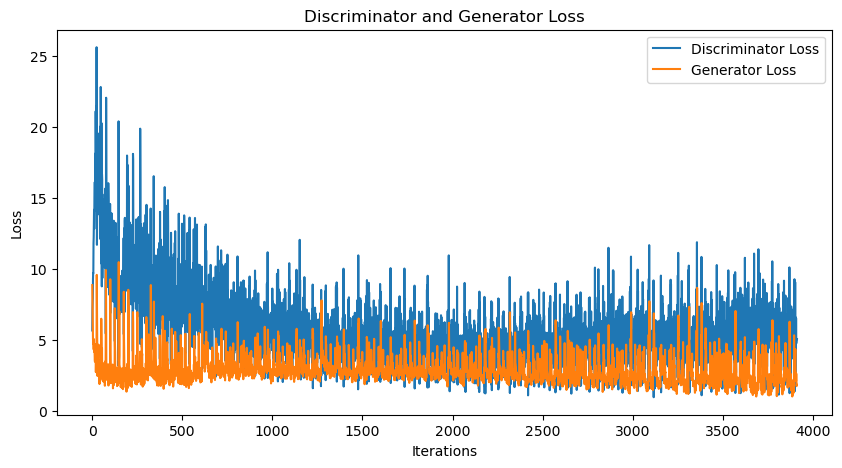

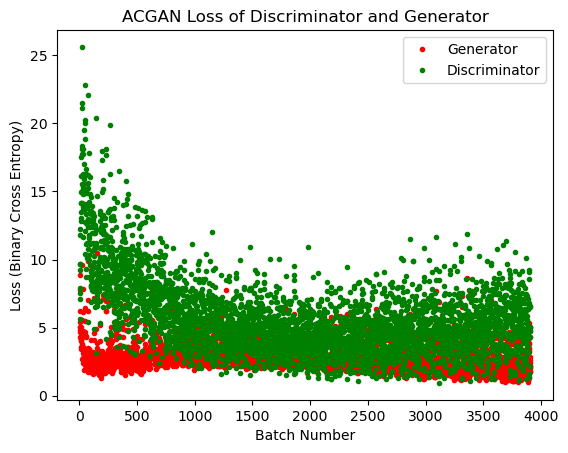

In [16]:
import matplotlib.pyplot as plt
import numpy as np

counter_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910]
dis_loss_list = [5.646778, 7.1281285, 7.5430183, 7.9259586, 9.257011, 9.705499, 9.679192, 11.797993, 12.221096, 13.029836, 14.155327, 12.805055, 13.477879, 14.938812, 16.104374, 14.126415, 17.532846, 18.118912, 15.024386, 21.102448, 18.306541, 17.752316, 21.47931, 14.125371, 25.614162, 15.542592, 11.685904, 13.626522, 17.744324, 14.847022, 16.304943, 15.332758, 13.835718, 18.127459, 15.522491, 16.12284, 16.170288, 15.561962, 15.13259, 19.549011, 17.017551, 14.08476, 15.936954, 13.682131, 20.017118, 14.922989, 12.077636, 22.811401, 18.846313, 10.38036, 12.724991, 20.274359, 14.993056, 8.754246, 16.665215, 16.299784, 9.339709, 11.169381, 13.359937, 12.733888, 12.681959, 11.185926, 13.836709, 14.082703, 12.580755, 10.31629, 14.906327, 14.097254, 10.090494, 15.25783, 14.02553, 10.761068, 12.382472, 15.65572, 12.995648, 5.4203925, 16.235783, 22.053385, 17.791462, 12.866832, 10.363558, 11.253932, 9.989475, 11.619065, 11.791359, 8.724983, 14.232471, 13.582401, 8.71957, 16.030685, 14.810425, 9.594127, 11.111918, 13.385517, 12.358184, 8.156471, 13.590141, 13.35589, 8.473064, 14.566863, 6.867966, 7.9963717, 8.081837, 9.066544, 10.615491, 9.493265, 7.9216733, 13.908463, 9.283165, 8.779518, 12.72241, 11.92787, 7.7501574, 12.388359, 11.193742, 8.254883, 13.141193, 12.827217, 7.6620235, 13.383394, 12.9552555, 9.829384, 8.033312, 11.930614, 10.78618, 4.888591, 10.80136, 10.241063, 7.0626345, 13.235047, 12.562773, 9.478397, 8.2790785, 10.872628, 11.080234, 6.5118294, 11.968458, 8.921516, 6.9265985, 11.23144, 11.060457, 8.444905, 7.8193016, 9.04602, 12.24124, 3.1627734, 20.389446, 14.702066, 6.585264, 8.530236, 7.4593506, 8.048119, 7.21673, 6.8057175, 8.530033, 7.9539547, 6.9519777, 8.41516, 8.779334, 8.462182, 9.477734, 9.193861, 7.89782, 8.30887, 9.536915, 8.049088, 6.9360676, 9.866219, 9.120729, 9.138519, 9.849274, 9.21177, 7.6675067, 10.871511, 12.158506, 5.3754854, 7.886432, 12.849912, 10.212592, 6.9419537, 13.371962, 13.586121, 10.947394, 9.223862, 10.818418, 8.694006, 8.740504, 12.03672, 9.152343, 11.370476, 12.383832, 10.078901, 8.5361595, 17.97904, 14.951204, 8.4227295, 12.554865, 17.304523, 13.050249, 15.169172, 6.5430913, 15.852736, 12.20581, 9.95209, 11.897046, 10.742152, 8.319915, 13.276693, 11.9252205, 9.668173, 9.938562, 10.155423, 7.8926277, 9.69634, 11.440161, 8.691922, 7.4912763, 13.073202, 11.139207, 8.98692, 11.876486, 9.491449, 8.012239, 12.523917, 8.525296, 4.19304, 18.096672, 17.684168, 11.84043, 9.836674, 8.786917, 8.4806595, 8.236032, 8.671122, 9.028681, 8.807156, 7.705587, 11.318807, 8.234495, 9.078916, 11.7008915, 10.00776, 7.17064, 13.467884, 7.4686275, 10.716294, 11.672406, 10.899706, 7.8562694, 13.471453, 6.605459, 9.604177, 7.5752997, 7.9403543, 10.59519, 8.824251, 7.620814, 13.628208, 9.6748085, 8.232523, 11.621705, 7.784751, 10.26302, 7.6401367, 13.687954, 4.710554, 19.872742, 16.308907, 8.809968, 10.826573, 13.148252, 10.896151, 7.3586836, 12.923235, 8.508323, 4.4707427, 10.575275, 10.403601, 6.9487348, 10.8855095, 12.17485, 10.288381, 6.7943196, 9.381557, 11.336142, 8.334278, 6.6652107, 13.20796, 10.026623, 7.5707216, 9.782239, 9.91235, 8.525486, 9.961375, 9.673307, 6.149411, 13.807543, 8.706621, 9.03568, 12.878498, 5.1551423, 14.504211, 5.407202, 8.2475815, 10.022746, 7.234741, 6.2582088, 9.782587, 8.324861, 7.5389633, 9.394603, 4.915079, 12.407118, 5.5032144, 10.732993, 6.5865536, 8.407347, 9.077087, 6.0624547, 9.416178, 7.924721, 7.19588, 8.465047, 5.338865, 14.242868, 3.6157126, 6.992261, 7.088513, 5.2226095, 7.395344, 7.295333, 7.423641, 7.216449, 8.004081, 8.920721, 5.3379183, 10.244548, 9.179877, 5.267654, 9.57906, 4.304745, 16.52301, 6.751731, 4.8953047, 9.190659, 8.091883, 5.783924, 8.6258135, 8.093987, 7.231848, 6.8153567, 7.8753004, 6.261087, 10.928276, 8.975034, 6.047598, 9.986877, 10.4598055, 7.879957, 7.718728, 9.711683, 9.514566, 7.6855736, 7.9773383, 9.038636, 5.423371, 11.390542, 9.192617, 6.4840546, 10.202017, 10.574278, 9.497997, 7.3697796, 11.830599, 8.255832, 3.6545665, 14.009296, 9.817302, 7.821829, 10.757256, 12.054827, 10.389946, 7.6862364, 10.709391, 10.289983, 6.434803, 10.796915, 9.323531, 7.091661, 11.546964, 10.043949, 5.7656846, 8.916518, 5.9206424, 9.818632, 10.619489, 7.4225073, 9.089619, 11.286987, 7.7502546, 14.078952, 3.5961967, 15.753165, 8.52952, 8.476357, 12.467971, 9.626572, 7.0404935, 14.446977, 8.847843, 6.649743, 10.740224, 10.401818, 7.7776213, 8.370112, 9.975557, 4.7513304, 9.569374, 9.388176, 5.2624564, 14.837465, 13.212847, 9.741298, 7.2200284, 9.4711075, 10.806215, 8.440357, 6.4149823, 9.67453, 9.292324, 8.607202, 9.580868, 9.429955, 8.098255, 8.677774, 8.679157, 3.265575, 12.533078, 9.399242, 6.7426214, 10.734289, 7.3177786, 5.399765, 5.842769, 9.037496, 10.341053, 5.9385743, 7.4436584, 9.975869, 10.017211, 7.749526, 7.2172604, 11.018855, 5.423422, 8.138706, 9.495934, 6.2101774, 7.3230762, 11.82813, 3.1440969, 12.645554, 7.731591, 7.092846, 7.218198, 7.2200947, 7.7164125, 4.2841883, 5.648844, 8.744133, 4.8104877, 8.03627, 8.101251, 7.0374546, 5.4942045, 8.800068, 8.224621, 5.6232643, 8.37134, 10.712419, 3.0788815, 13.881979, 8.570771, 6.2774463, 8.840475, 7.7416553, 8.630112, 6.0001955, 7.00078, 9.106279, 5.1318254, 10.317026, 6.950092, 5.175577, 9.315395, 7.87086, 9.7866, 8.236393, 5.9128814, 13.17284, 6.9605913, 6.438058, 9.285108, 9.63904, 6.1435623, 9.830986, 9.27729, 6.927536, 10.796077, 11.157391, 7.7757025, 13.761557, 12.297018, 8.110704, 9.155938, 10.097819, 10.5438, 4.0464077, 10.541611, 7.3932447, 7.8719263, 9.092279, 9.786261, 8.512388, 6.836426, 8.751761, 9.7631645, 6.912227, 7.6554656, 12.5214815, 5.539407, 10.264036, 11.701049, 8.964156, 7.5205855, 9.624559, 8.476454, 7.2453527, 7.954147, 12.680075, 3.282311, 13.607255, 8.256327, 7.177448, 7.396991, 7.2506666, 7.521552, 5.9902444, 6.5900846, 7.7682314, 6.912567, 8.151556, 7.1445947, 8.216819, 7.4323063, 6.455439, 9.9648485, 4.484243, 7.927772, 9.8351345, 5.5886493, 8.44273, 10.405159, 6.23481, 12.778532, 4.9054375, 10.379251, 4.9364314, 5.947218, 8.660689, 4.401087, 13.578242, 5.942155, 9.918027, 5.8780026, 11.154669, 6.298093, 7.5002246, 8.160311, 9.89635, 6.9808273, 5.6507277, 13.114353, 6.8148975, 5.8256354, 9.732545, 7.5231276, 5.7846565, 6.715476, 10.282694, 5.321847, 9.229706, 6.697446, 6.788568, 5.920827, 6.396175, 8.802936, 5.82469, 10.26458, 6.859977, 7.047385, 8.057948, 8.336523, 6.864792, 6.564393, 9.515858, 5.8712506, 5.829898, 5.4655595, 10.150595, 2.9200234, 8.056055, 8.0181875, 4.6697598, 6.7862988, 5.6387434, 5.0525675, 5.338583, 5.2689195, 6.8065658, 4.1687436, 8.786981, 4.865592, 7.351633, 6.630016, 7.318793, 6.8983955, 7.656215, 4.6001453, 12.953498, 4.218878, 13.125683, 4.047101, 11.289072, 3.6118164, 6.6029263, 6.2318845, 4.550315, 7.1950026, 8.023684, 3.7144265, 8.337807, 6.1770935, 6.7569065, 5.3709755, 6.314951, 7.552094, 4.7071824, 9.582922, 6.485515, 5.1072474, 7.8857555, 6.4971614, 6.5011654, 7.685728, 6.5006466, 8.04789, 4.3441944, 10.269064, 6.5833497, 7.0054164, 8.337775, 6.869438, 8.275709, 5.922568, 7.40551, 7.1435046, 3.162879, 9.037835, 5.992654, 5.943677, 8.343693, 7.130185, 7.801688, 5.945418, 9.364618, 7.642757, 5.9236956, 7.973769, 6.1462846, 6.8339286, 7.9129524, 7.4863105, 5.986308, 8.040392, 5.681736, 10.158821, 2.402039, 8.188298, 5.029214, 6.321679, 4.827669, 6.769088, 4.025991, 7.919956, 5.3406744, 9.780269, 5.0302806, 11.572662, 6.3320622, 5.671522, 10.602024, 4.741376, 8.815997, 4.620658, 7.098237, 8.870299, 5.0781507, 9.693215, 7.3258257, 6.0577374, 9.25717, 7.637532, 7.4912195, 8.819487, 6.0463276, 11.299782, 2.8141491, 10.322573, 8.841166, 5.3144684, 9.717642, 7.2149725, 8.768163, 5.5196285, 9.073249, 5.9500713, 5.347095, 7.95163, 7.7716017, 5.028305, 10.17419, 5.7189293, 7.436396, 5.08694, 7.5034795, 6.455308, 5.710288, 6.0989537, 8.099382, 3.502455, 10.345078, 4.4446225, 6.531557, 5.5403633, 4.349871, 8.368327, 3.1761827, 6.494617, 6.2385015, 4.0052223, 10.991823, 4.357895, 8.492285, 3.654302, 7.3601155, 6.4279876, 5.1440735, 6.6508574, 7.8628087, 4.3445325, 6.294595, 7.440801, 6.219499, 5.1208196, 7.3785987, 6.4876842, 3.5265818, 7.6759377, 4.156833, 6.1986995, 4.2265363, 8.476782, 5.326144, 5.791889, 7.114443, 7.3317056, 4.2365055, 6.4514256, 6.7036734, 4.707543, 7.6172304, 5.9333143, 5.3317623, 6.920906, 3.5542974, 9.0458, 3.9720993, 8.220848, 4.0508194, 7.173649, 4.297468, 8.294216, 6.9741383, 4.297427, 8.003407, 5.2116747, 7.5784636, 4.7475924, 8.314861, 5.2486353, 5.9158034, 8.282422, 5.2993326, 7.06501, 6.07273, 6.0941563, 10.86697, 3.1739342, 5.889159, 7.8566713, 4.3435135, 6.5981836, 7.0280576, 6.094572, 5.4523973, 5.9690895, 7.1542354, 3.4117, 7.769518, 6.802022, 5.0700626, 7.3910885, 4.0365105, 8.73665, 3.6503115, 9.048855, 4.8167343, 5.7868223, 3.8304505, 7.0708137, 4.436895, 6.969738, 4.3534617, 5.491592, 4.985843, 5.453369, 5.889091, 4.907552, 6.2688932, 9.169479, 2.7372704, 9.141596, 4.2495074, 7.575873, 4.0824924, 7.923604, 4.3469815, 7.2601995, 3.719062, 8.610509, 4.2785654, 7.4457273, 6.605854, 5.485998, 5.9013844, 6.7701244, 6.334811, 3.874611, 6.1206555, 4.878396, 4.4697685, 7.8593664, 5.4004726, 5.4787073, 5.399032, 5.526555, 4.939635, 5.5411053, 4.859168, 7.596517, 3.4241514, 8.757951, 3.5466015, 9.449205, 3.4334896, 6.320734, 5.071727, 3.3986855, 7.794188, 4.3692527, 5.597581, 5.112034, 4.3292713, 5.5475545, 4.146321, 6.5657015, 5.6652803, 4.6448665, 6.522209, 6.1463666, 4.647359, 7.9316726, 4.764687, 5.3596487, 3.8115292, 7.3810964, 4.986299, 5.042201, 5.4737396, 6.960498, 4.4033494, 8.503217, 3.1246097, 9.87139, 2.4566336, 9.197984, 3.6008077, 3.6428137, 5.90733, 5.206109, 4.577593, 7.733514, 4.931532, 5.231172, 6.55558, 2.9417787, 7.8848767, 3.138496, 6.711512, 5.1930237, 3.4407163, 8.268063, 4.1523714, 6.036047, 5.409077, 4.4307623, 6.728945, 3.7327156, 5.1927876, 7.310231, 4.4001718, 5.013809, 4.982098, 5.7416916, 3.5805087, 7.208829, 4.6752076, 3.8277993, 6.713178, 5.783764, 3.7025719, 6.039935, 7.0726557, 3.7722988, 5.9923534, 4.565095, 6.17569, 3.8411992, 6.48887, 4.9827347, 5.6120343, 5.036607, 5.596603, 6.9885435, 2.6753762, 7.6692257, 2.2629178, 6.3285685, 2.9940677, 5.8578606, 2.9654207, 5.761581, 5.8419547, 5.265157, 4.3679705, 7.0894074, 3.5879955, 6.179039, 3.4969187, 8.956539, 3.2378654, 7.912759, 3.4643545, 11.160837, 2.29533, 7.3353305, 5.539648, 4.696038, 6.333004, 5.919216, 4.1206512, 5.6673813, 4.0165443, 4.3632917, 5.444475, 5.029976, 5.72515, 5.390844, 5.7005663, 6.8210554, 5.6938667, 5.4621067, 6.8917856, 5.60908, 4.8179717, 6.0214996, 4.7610703, 5.8797593, 4.2706304, 8.601642, 4.257365, 6.0788183, 7.6855726, 4.7168083, 7.0324516, 3.7147098, 7.530684, 2.9048476, 4.6096115, 6.623775, 3.4176822, 7.243315, 4.1175222, 7.445345, 4.3796916, 5.2892413, 6.568459, 3.9190023, 5.646912, 6.291249, 4.101326, 7.2646723, 3.9442363, 7.336691, 3.3291416, 9.63883, 4.179127, 5.5319138, 4.725852, 9.2655115, 2.0562143, 9.926077, 2.8699355, 8.457785, 2.3137045, 8.539227, 3.0861018, 7.262394, 3.037596, 8.363031, 4.028071, 4.784897, 5.809024, 5.7452755, 4.0053368, 6.185163, 4.2551527, 5.27184, 4.4964457, 7.5519333, 3.5438707, 5.14132, 7.5957327, 4.4654093, 3.5647469, 6.9866023, 6.1471906, 2.0133784, 6.753292, 4.9224014, 4.5925627, 7.4223127, 5.3323984, 7.851274, 4.467559, 7.3582144, 5.4165716, 4.8475165, 5.465833, 8.568322, 3.911699, 8.3602495, 5.7163014, 6.5063996, 5.374238, 5.172261, 6.31908, 3.293504, 6.4169984, 5.2828565, 4.7036486, 6.198377, 3.401362, 6.770324, 4.4575157, 6.9639745, 5.065057, 5.017601, 5.600654, 7.055253, 3.0453887, 8.543419, 3.8292534, 10.387831, 2.7147086, 9.162083, 3.1758132, 6.8039064, 3.4885712, 5.1841545, 4.05803, 4.871888, 5.7029476, 4.4081907, 5.1221976, 5.9446435, 4.967216, 3.3755867, 5.3471994, 4.8215823, 3.0113418, 7.422184, 3.7365086, 5.876458, 4.085291, 5.6462164, 5.788419, 4.7600274, 5.1811724, 6.375945, 4.881199, 8.260397, 4.7712717, 7.695826, 4.967211, 7.1970015, 7.1033535, 4.08462, 5.6953344, 6.841193, 3.6162972, 7.3569574, 2.773275, 9.926571, 3.6394074, 6.5069647, 6.682639, 2.783105, 7.295569, 5.08995, 6.0955763, 5.7533507, 5.616878, 7.141967, 4.0911965, 7.4205937, 4.27494, 6.0106525, 4.29158, 8.128534, 3.039876, 12.038051, 2.4650893, 9.207512, 3.717841, 5.9565907, 6.999889, 2.1901426, 6.064191, 4.1872063, 4.1883173, 6.776595, 5.759193, 4.746331, 5.5240974, 6.107824, 6.003109, 3.4088597, 5.397178, 5.171944, 4.3467155, 7.9684033, 3.4561403, 6.5139327, 2.3093853, 7.2576904, 2.7720938, 9.407385, 3.8602026, 4.9431105, 6.3397956, 3.5933716, 5.7398887, 4.713527, 6.769903, 4.3108745, 6.129132, 6.296307, 3.1729827, 7.1262765, 6.1468253, 4.64676, 5.9729004, 5.828137, 5.1548796, 4.7008657, 5.0172973, 5.3614616, 2.879822, 4.365853, 6.001482, 3.319816, 6.872825, 4.870746, 5.2086053, 4.891344, 6.3599887, 4.4447894, 4.9136934, 5.633152, 4.68775, 4.4071226, 5.5104685, 4.4070387, 4.6928363, 4.7946243, 4.988373, 4.9552236, 3.7351732, 6.759782, 3.6434407, 7.1376123, 2.2439322, 8.8824415, 1.574714, 6.1813426, 3.7506914, 4.327671, 4.1325064, 4.483571, 5.5848727, 4.1872015, 6.499545, 5.1991053, 6.4168444, 3.4394023, 7.253859, 2.7265527, 6.868404, 3.3268151, 6.5425477, 2.2628484, 6.105222, 4.9263654, 4.7001605, 4.3794336, 4.991756, 4.3295946, 3.3694968, 5.274516, 4.7611275, 4.992977, 4.4312506, 4.8005, 6.4193025, 4.616462, 4.411035, 5.198992, 4.0050793, 4.502675, 5.173086, 4.012489, 5.9333353, 4.6981277, 6.161515, 3.7967157, 6.880376, 3.6544237, 6.5624895, 1.7190716, 8.505188, 2.4724598, 4.9497185, 5.125255, 3.063674, 4.0585856, 4.3748026, 4.0475254, 2.8447003, 4.1399293, 3.6794791, 3.1694462, 5.449618, 2.8251982, 5.8619823, 2.9558551, 4.9272366, 4.3308287, 2.6146443, 5.70391, 4.896664, 3.4637933, 8.406355, 2.7247887, 6.389376, 2.1431031, 8.827524, 2.7083247, 3.9087014, 4.3119445, 4.9083357, 3.3910363, 5.325326, 4.0753365, 6.3925805, 3.853171, 4.413456, 6.818038, 3.2151668, 4.50966, 6.4509163, 3.0866442, 6.0027437, 4.3245697, 4.681161, 3.8524156, 5.386857, 4.1918373, 4.5186696, 4.86246, 5.412678, 3.6248271, 5.6546464, 4.276009, 3.9721513, 5.140871, 3.6663365, 6.618602, 3.6602616, 4.241827, 6.564721, 2.989314, 7.1090994, 3.8472323, 6.660347, 2.7642512, 5.0706367, 6.0698833, 4.0395293, 5.1951995, 6.4817886, 3.3737924, 7.1503077, 4.4301405, 6.1961985, 4.024376, 6.278663, 4.1440163, 4.2062426, 4.7073975, 5.310263, 3.311826, 8.747589, 4.070614, 7.719903, 2.768985, 9.036837, 2.0409713, 8.671476, 2.5656028, 7.3198576, 2.8336258, 5.992178, 4.8095098, 4.046296, 6.049954, 4.3095846, 5.977087, 2.582467, 5.305109, 5.2134514, 3.7235124, 5.1871386, 4.485555, 4.957303, 3.5850506, 4.1964946, 4.8013315, 3.9684176, 5.164879, 4.8428354, 3.416181, 5.556577, 3.9678159, 5.6705055, 4.5261574, 4.3930316, 5.03671, 3.74171, 4.338031, 6.545237, 2.8463712, 7.420246, 2.9964004, 10.0039215, 1.6918348, 7.1858134, 3.4997027, 5.279065, 3.2482452, 6.020466, 2.1914554, 6.740652, 5.3687954, 4.0160084, 4.9925003, 3.5965672, 5.1970153, 2.9423594, 5.3778744, 4.7239714, 4.4182844, 5.6415005, 4.266821, 5.6080565, 3.3385727, 5.6644783, 5.051286, 3.930228, 4.434889, 6.1249285, 2.8588412, 7.8500423, 2.2968621, 7.985711, 3.4522896, 5.2094684, 4.720649, 3.519595, 4.9192343, 5.054998, 3.3768964, 6.5240464, 4.451622, 4.7039123, 4.924117, 5.2951927, 4.7675743, 2.7022123, 5.8294797, 4.911215, 4.9645066, 4.8668237, 4.7483587, 4.727825, 4.3016095, 5.3184905, 5.511974, 2.3329089, 6.636773, 4.0624933, 4.8769946, 4.799813, 5.1331353, 3.752286, 5.7307806, 3.4876974, 6.8950086, 3.596238, 5.639423, 4.964569, 3.7139812, 6.484769, 3.9958959, 5.795188, 3.9960928, 6.18506, 4.5833435, 5.2822, 3.6782207, 7.772317, 3.8093042, 6.320457, 3.6777747, 6.875798, 1.4985056, 10.941438, 2.1156092, 7.9175553, 3.5135748, 6.484249, 3.1049123, 5.098868, 4.6704397, 5.81626, 3.8795838, 5.158235, 7.9094443, 3.3017507, 7.7330074, 4.785417, 4.7522287, 6.435575, 4.377753, 5.8797936, 3.9744904, 5.273268, 6.01738, 3.0790343, 5.2067003, 5.5562935, 3.456749, 5.2223377, 4.4264727, 4.7379427, 4.350213, 4.9693904, 5.9742975, 3.0245996, 5.8871174, 5.834478, 3.7016141, 6.2543497, 4.2470336, 6.137659, 3.1164186, 7.55759, 3.2688751, 4.0991693, 5.096927, 5.8948174, 3.0433068, 8.107767, 1.8829589, 9.198523, 2.1503043, 6.908099, 4.700997, 3.562191, 5.224725, 6.3546367, 3.293734, 6.0312104, 3.5991387, 9.007883, 2.0611544, 8.33779, 2.9226544, 5.141869, 5.284859, 6.4038296, 3.2275643, 7.2480173, 3.7907658, 5.7187166, 4.7314034, 4.9845862, 6.0607796, 2.5492365, 5.2395444, 4.7451944, 2.793212, 6.567601, 3.8774545, 6.198951, 4.5335193, 5.438774, 4.715516, 3.4350219, 5.425864, 5.8509474, 3.3442445, 7.761427, 2.942793, 6.825548, 2.8586895, 3.9587185, 5.116259, 4.80525, 4.8908467, 4.570768, 6.792033, 3.2789617, 7.2856274, 2.9098647, 6.1218376, 4.6188035, 4.9647007, 5.2271256, 3.9851408, 4.446986, 5.3560133, 3.6101427, 6.454735, 4.169036, 6.694062, 3.9105482, 4.2502093, 5.796503, 2.1552336, 6.2350483, 4.9366627, 2.4051604, 6.4704647, 3.6462817, 7.829558, 2.275824, 8.925245, 2.0249321, 8.29829, 2.209613, 8.374425, 3.8822422, 2.9530108, 6.268956, 3.4993105, 2.9587417, 5.731742, 3.4483356, 4.32507, 3.1590128, 5.6225214, 3.2225945, 5.4608154, 2.9036036, 4.646158, 3.478509, 5.1139793, 3.8677964, 4.385766, 3.309272, 6.3927784, 3.4632509, 5.4886947, 3.9323683, 4.3257713, 5.1235514, 3.2922862, 7.434458, 3.9423912, 4.0264707, 6.4728603, 2.6548982, 7.3700857, 3.5902448, 6.3775053, 3.2426834, 6.275524, 4.095592, 2.4536707, 5.855384, 3.421913, 5.2405434, 5.1608067, 4.5346203, 5.7212515, 3.6043808, 6.1908417, 4.0225573, 4.855345, 3.6934252, 5.55047, 2.8048527, 7.5032153, 2.150994, 10.041464, 1.9416745, 6.917884, 3.7881935, 2.6007626, 4.5215383, 4.825225, 3.143097, 4.7831793, 3.9602757, 4.4805274, 3.2073014, 4.978695, 4.011799, 3.8124704, 3.5642838, 5.6106176, 2.6103165, 5.318305, 4.7764025, 5.0409317, 4.3134584, 5.2433257, 4.6796265, 3.5314367, 3.8458753, 5.421369, 3.1413789, 7.2472496, 3.710534, 5.8784184, 3.1243007, 5.8723483, 4.008971, 3.2190475, 4.7690144, 5.1223073, 2.1258187, 7.218027, 2.6782656, 5.8082743, 3.747628, 4.1028423, 5.78574, 3.1357594, 4.739341, 5.8172407, 2.4561129, 6.880265, 3.472025, 8.057064, 2.239159, 7.6054783, 3.9187853, 5.466376, 2.8093498, 6.8493233, 2.967968, 6.4353056, 2.4949145, 5.3525376, 4.05725, 4.4441853, 4.249579, 3.3971813, 4.345606, 4.368475, 3.3010967, 5.945693, 4.341915, 4.889627, 5.104731, 4.19762, 6.3759494, 2.6317158, 7.906743, 2.6045887, 10.01338, 1.6699488, 6.4929466, 2.9593968, 6.3328457, 3.0925474, 4.643525, 2.688536, 3.8757045, 4.2139826, 3.0095625, 5.1525507, 3.7396564, 5.5673347, 3.2099724, 5.0533543, 4.7434072, 3.6095407, 4.2918015, 4.98915, 2.5148907, 6.314847, 3.9000087, 5.450462, 3.1990557, 6.3722725, 4.3173785, 2.9814868, 5.083671, 6.111818, 2.720646, 7.0311236, 2.2432187, 6.4983974, 2.3543155, 7.251028, 2.5783029, 5.669102, 2.9679165, 6.976388, 2.9517634, 4.6820507, 4.83222, 3.804019, 3.8242235, 4.619169, 4.6432505, 2.8248322, 4.7137938, 3.6104941, 4.655261, 4.0694203, 4.9332905, 3.7665412, 5.2936115, 2.3859549, 8.809213, 1.5591751, 6.717039, 2.921357, 3.248786, 4.289599, 3.8027322, 5.2608266, 4.076282, 4.85667, 4.4629974, 2.2660162, 5.271515, 4.273654, 3.126998, 5.3071012, 3.1627512, 6.0536423, 2.8905814, 5.198873, 3.789505, 3.5148911, 4.2883654, 4.9372787, 2.96283, 6.969031, 2.7180023, 6.302749, 1.8941834, 6.846464, 2.0226612, 5.6187944, 3.704588, 4.8138437, 3.4213252, 4.9377503, 5.39471, 3.4485846, 5.4771986, 3.1910162, 6.711709, 2.4473965, 6.97869, 4.0958023, 4.339384, 5.6410856, 3.943111, 5.6108866, 3.357666, 5.5661716, 3.4820666, 3.9251888, 3.8334258, 5.641113, 3.8363805, 5.604804, 4.6047235, 5.726155, 4.5097804, 5.379119, 4.8687763, 3.9239297, 3.8246052, 5.9258604, 4.0241637, 4.4121385, 4.587901, 5.610676, 2.9423573, 8.523789, 1.9431195, 8.856147, 1.6243851, 9.504244, 2.3720443, 7.684945, 1.7365301, 7.2219124, 1.6436582, 7.235551, 3.688414, 3.0442586, 4.383002, 4.555593, 3.2784233, 5.136959, 4.8346167, 4.0444746, 4.1215496, 4.870942, 4.0908704, 3.2271023, 5.288405, 4.1341934, 3.1806784, 4.2358685, 4.568758, 3.5667758, 4.8697786, 4.269853, 4.8063674, 2.185088, 5.5997534, 2.9976325, 5.491982, 3.3548071, 5.438037, 3.9905486, 4.1358786, 3.7485576, 5.4575686, 3.0115812, 4.4583263, 3.8338032, 3.6015265, 6.3080926, 2.9591134, 6.859778, 1.9890692, 5.9153824, 4.5084505, 2.924034, 4.5316353, 3.7579808, 2.784268, 6.830323, 2.3126488, 6.140562, 1.9762418, 6.410245, 2.7444868, 4.625806, 3.2368298, 4.966178, 3.2808099, 4.449748, 3.5835571, 5.6138053, 2.6241145, 5.9159, 2.8745418, 3.460003, 3.8941045, 4.7738843, 2.2257051, 6.4093256, 2.430665, 6.721283, 2.661189, 6.6000986, 4.1931524, 2.3673656, 5.227751, 3.9099512, 2.9452915, 6.0840325, 2.9853153, 5.021827, 3.0074036, 6.167337, 4.2746725, 4.455543, 3.4457936, 5.785227, 2.4058485, 6.178817, 2.5021322, 6.2279797, 2.416156, 5.0763426, 3.6954782, 5.057319, 3.1391642, 4.514613, 4.509667, 2.7057254, 5.3310094, 3.7489035, 4.114479, 3.1897624, 4.686352, 3.321209, 4.1300507, 3.8311968, 7.028004, 2.696842, 7.05585, 1.758553, 6.6511602, 1.9430579, 10.940047, 2.2671874, 3.7570312, 2.3495724, 5.7007866, 1.360541, 5.865119, 3.54798, 3.7090442, 4.64372, 3.520648, 6.0158863, 2.0966682, 5.166395, 4.6882577, 2.639277, 6.3980293, 2.5369492, 5.4070234, 4.244451, 4.041251, 5.2618947, 2.4201288, 5.0482173, 3.6580157, 3.1163688, 5.709484, 1.999517, 7.129181, 1.9998714, 6.1325593, 3.0170624, 3.603561, 3.2366996, 6.218497, 2.2593155, 5.8077154, 4.1026793, 3.7861712, 4.019552, 3.771609, 4.4358635, 3.0776484, 3.9867306, 6.169816, 1.9500186, 8.739023, 2.5401216, 6.107686, 1.8304765, 6.0120487, 4.259433, 2.3763084, 4.7573786, 4.2483253, 2.5708222, 3.9924212, 4.6809874, 3.462151, 3.744384, 4.501859, 4.4051843, 3.8215861, 3.0607789, 5.294829, 3.5018816, 3.755909, 4.9727554, 3.6422062, 4.113103, 5.07773, 4.100602, 2.8277159, 5.137086, 4.2948713, 2.382721, 5.308537, 3.1110559, 4.2533693, 3.755083, 5.0594854, 4.5700016, 3.64148, 5.16012, 4.952758, 3.1227977, 6.7699723, 2.5982146, 8.997105, 1.5953498, 5.9473968, 2.0518463, 6.5952377, 1.311038, 6.6109753, 2.379637, 4.543656, 3.3785143, 6.1603556, 2.8310022, 5.401349, 3.5096781, 3.0820932, 4.561952, 4.297496, 3.3193035, 4.039448, 4.7953143, 3.5844555, 4.3106112, 3.6019266, 5.6538677, 3.079146, 4.287136, 5.057496, 2.374554, 6.99275, 2.1221156, 7.0853567, 2.2412498, 6.066764, 2.829092, 4.532813, 3.0892656, 5.81808, 2.3843231, 5.3633265, 2.6846404, 4.020256, 3.7264078, 3.9593296, 4.9917674, 3.3957877, 2.9239278, 5.2537117, 3.6641912, 3.7039647, 5.633914, 3.002013, 5.76841, 2.4503343, 6.3465457, 1.9259386, 6.0308976, 2.336165, 4.7615213, 3.301654, 4.949294, 4.297676, 3.600035, 3.8688288, 5.227614, 1.9138317, 4.678999, 4.849796, 2.4056277, 5.4900436, 3.9268634, 4.5039043, 2.7461028, 5.480275, 3.7800806, 3.685271, 3.543029, 6.1244955, 2.5931334, 7.1313214, 1.517718, 7.6788826, 1.3057053, 8.387052, 2.6224976, 4.788578, 3.8084433, 4.36465, 2.9203289, 5.488537, 2.976996, 3.716381, 3.8992066, 3.7203877, 4.346171, 2.9097848, 4.205624, 5.1011596, 2.7551897, 4.4067135, 3.7811403, 4.1322656, 3.9640203, 4.1473494, 4.995804, 2.4887471, 4.9093018, 4.6712713, 2.687201, 6.749386, 3.027535, 8.015667, 1.2326312, 7.560888, 1.6531667, 6.6156473, 1.2108378, 5.1555777, 2.7719634, 2.9840953, 4.2954526, 2.9296088, 4.123515, 4.141734, 4.402988, 3.3502567, 3.372866, 5.456665, 2.2603216, 4.5474916, 4.217548, 3.9715543, 3.710877, 4.282041, 4.1386576, 3.0276632, 3.5997727, 5.0183554, 3.1014388, 4.9879017, 2.9401097, 4.3015456, 2.9068236, 5.7253613, 3.5842376, 3.5475, 3.3395858, 6.4689827, 2.4086199, 7.7080717, 1.8256052, 6.2491546, 1.4383277, 7.601879, 2.665318, 3.8421447, 4.3285456, 4.7252464, 2.284862, 6.2377167, 3.1846523, 5.918541, 3.2796466, 5.0326653, 4.4947157, 2.9706497, 4.01951, 4.7190275, 2.615112, 4.9973965, 4.7448072, 3.6688442, 4.6804514, 4.131532, 4.068761, 3.722943, 5.805407, 4.668894, 4.60476, 4.503297, 4.777252, 5.026881, 3.020772, 6.559456, 4.0816507, 4.976183, 2.5753267, 7.8929996, 1.496285, 7.8872604, 1.6510663, 7.2844105, 1.9182448, 5.453574, 3.594148, 2.6475587, 3.830521, 4.594713, 2.5323205, 5.746819, 3.7972593, 3.7304015, 4.2107153, 3.8618052, 4.1276236, 2.7711523, 4.1172075, 4.7448683, 2.624998, 5.1385903, 3.1658518, 5.613126, 3.4202473, 6.7100897, 2.4201953, 4.666537, 2.3623958, 6.996033, 2.358103, 5.477888, 2.79252, 5.541259, 2.8227365, 3.8350239, 4.768363, 3.0385354, 4.252388, 5.098081, 3.840691, 5.8058167, 3.104271, 5.2802906, 2.7983763, 5.2634287, 3.8550572, 3.4147208, 5.0905514, 3.20417, 5.329978, 3.8346267, 3.6482418, 4.2263556, 3.363681, 5.457821, 4.1034555, 3.8951073, 4.0833282, 5.7012935, 3.1092837, 6.8602805, 1.905919, 9.41869, 1.2374854, 6.991482, 3.2468543, 3.4393559, 4.0363092, 4.275047, 1.8726362, 5.50021, 3.8057876, 3.4569793, 4.034674, 3.9876523, 4.3929424, 2.813651, 3.2590537, 4.877086, 2.5939937, 4.19079, 4.9308977, 3.7025151, 3.7085462, 5.2642784, 3.2965105, 4.837468, 2.8983753, 6.599803, 1.6555037, 7.604414, 1.9164109, 6.1760564, 2.2089167, 5.3727684, 2.9010887, 5.9532685, 2.6563897, 3.9067073, 5.8756003, 2.3106747, 5.5539784, 4.891306, 4.323346, 4.22533, 3.822498, 5.2630024, 2.734631, 4.6855845, 4.8204937, 3.386827, 4.6515946, 5.4483685, 4.2553406, 5.136643, 3.674059, 5.5881433, 2.2347388, 4.118366, 6.002716, 2.677268, 6.5884514, 2.8915932, 7.9154005, 1.7744641, 8.042948, 2.3662822, 6.283057, 3.4252748, 5.6971216, 2.339738, 6.952751, 3.2053568, 5.1502366, 4.6581397, 3.9762774, 4.7606115, 3.2135272, 4.373387, 5.303294, 2.9595323, 5.508506, 3.7319121, 3.3744383, 3.6303077, 4.0989485, 5.63769, 3.0791965, 4.9467883, 4.829541, 3.7042096, 5.063512, 5.130254, 4.5360913, 4.5476985, 6.168104, 4.7111573, 3.9542217, 4.5677605, 4.661269, 3.8663607, 6.643351, 3.3511233, 8.311624, 1.0737185, 8.331376, 1.8051615, 4.8032627, 3.1396089, 5.3212767, 2.2572944, 6.438113, 2.6628723, 6.7287254, 2.692261, 5.6334286, 3.9987378, 3.86368, 4.5457807, 6.3345037, 3.3059773, 5.1073904, 4.3671455, 4.3071203, 4.366522, 4.1055694, 6.192833, 2.4341302, 5.2525225, 4.039633, 3.69568, 6.5899777, 2.47364, 7.807599, 2.4322922, 7.0207767, 2.178018, 7.452108, 1.7078624, 7.575034, 2.6918855, 5.601499, 3.474885, 4.946388, 3.7877252, 4.5162354, 5.08329, 2.5961862, 4.7927723, 5.281774, 2.9132044, 6.6972027, 4.655792, 5.2432985, 3.140572, 5.76073, 5.013093, 2.004268, 4.481269, 5.685733, 3.3097591, 5.793663, 3.388999, 5.941985, 1.6774929, 8.528519, 2.6039858, 6.7689247, 2.5036151, 5.405218, 2.7548676, 6.5960073, 2.1270475, 6.0137644, 3.050767, 5.291539, 4.1245785, 3.6303887, 4.142628, 4.276465, 3.474868, 5.8488483, 4.1376, 2.555529, 5.800778, 3.2330456, 6.3278027, 2.5579944, 3.9325619, 5.654768, 2.5540588, 8.325228, 1.9912753, 6.6984777, 1.6359203, 4.5781946, 4.292153, 2.8405042, 3.9581413, 5.3783255, 2.2390296, 5.496825, 3.3500402, 4.503076, 4.619921, 3.052329, 5.075827, 3.3279748, 3.3588974, 5.4552727, 2.6426463, 5.270905, 4.343306, 4.874565, 3.784972, 5.406903, 4.1910267, 3.0583239, 4.9194727, 5.550234, 3.3726885, 7.1319304, 2.7365603, 7.230204, 1.4342401, 7.6466727, 1.6520994, 8.081793, 2.3853822, 5.3889217, 3.594524, 4.3544207, 3.5030975, 2.9660664, 5.1015816, 3.9353058, 4.4720793, 4.320346, 4.8950276, 5.458747, 4.3146086, 4.888072, 4.2517357, 4.6529107, 4.126379, 4.662782, 4.953291, 3.2685027, 4.804859, 5.9203835, 2.9850123, 7.6638446, 4.531288, 4.212947, 2.389574, 8.917784, 1.2849882, 8.970648, 1.4059473, 5.17243, 1.9384336, 6.0827518, 2.4038498, 4.3207808, 4.552124, 3.3370607, 6.227781, 2.4221404, 4.00839, 5.461785, 2.877349, 5.0308657, 4.2721105, 4.749182, 4.219198, 4.052332, 5.7898607, 3.2563174, 4.1276445, 5.079488, 3.0571368, 8.178217, 1.4863842, 5.820287, 4.414119, 4.470907, 5.300867, 2.6927347, 5.2197433, 4.0114365, 4.442796, 4.8370986, 3.8334846, 5.0087504, 4.0130177, 5.5773187, 4.2581387, 3.4638298, 4.30262, 5.7948246, 3.0635478, 5.270588, 4.801108, 6.5433965, 3.122754, 7.5120234, 2.0094783, 4.9389377, 2.6163821, 6.75292, 2.2295666, 5.5282984, 3.7111082, 4.576759, 2.9516444, 5.7186565, 3.8804593, 3.7058651, 4.370373, 6.371267, 3.1821003, 7.6842165, 1.8358271, 9.119509, 1.6076336, 7.913434, 3.3888013, 4.3475304, 3.3185263, 5.2969074, 2.37602, 6.834899, 2.1585183, 6.159446, 3.3821714, 4.1468525, 5.1024885, 3.6861887, 4.2099676, 5.319891, 3.0832574, 6.8801665, 2.7689009, 7.346177, 1.1937222, 6.5143003, 5.611164, 3.1413682, 6.2921214, 2.6967528, 4.890378, 4.182009, 4.1354814, 5.2574596, 4.2235813, 4.4320273, 5.2144885, 2.4767294, 5.2135983, 4.806173, 3.3468475, 6.57621, 4.2639904, 4.4522963, 3.53478, 4.709025, 5.648142, 3.2277532, 5.040822, 4.7611647, 4.7028174, 6.816823, 4.339311, 8.169649, 1.4543288, 7.5288506, 3.007696, 4.5939465, 3.7184784, 5.1867113, 2.5316606, 6.1706767, 3.2469752, 4.737404, 4.6081543, 4.2594805, 6.0214343, 4.639429, 3.6056821, 7.4564104, 3.4431841, 4.572193, 2.8428843, 7.9902134, 1.7923372, 8.335865, 1.7361126, 5.8222084, 1.8391645, 7.284303, 2.3120446, 4.9953923, 3.7381651, 4.5257025, 3.6225944, 4.3428893, 4.1377807, 3.1306086, 3.5762043, 5.457491, 2.8968742, 6.1469216, 4.0917916, 5.9382305, 3.387067, 5.9221992, 5.693475, 5.9102354, 3.5530252, 6.9127316, 2.7793865, 6.9752626, 2.3870602, 5.948025, 2.567821, 5.4314795, 4.723894, 3.6834335, 5.311001, 4.155788, 5.731767, 4.2823224, 4.8140187, 5.2688537, 4.228709, 5.6170063, 4.56612, 5.387055, 4.368311, 5.2758307, 5.8431544, 3.538567, 7.938324, 3.0784056, 7.264324, 1.3275546, 7.9828534, 2.5211215, 3.9143758, 3.27141, 4.8980246, 2.8389866, 4.6845126, 2.5850368, 6.988964, 3.1110988, 4.261557, 5.10797, 2.9082758, 4.830495, 3.5242271, 3.6351352, 4.6503778, 5.7422414, 4.4813857, 4.792493, 5.906892, 4.201046, 4.4791226, 4.393399, 6.2210293, 3.864704, 5.7289853, 4.5247717, 2.0065117, 10.079081, 1.7729489, 7.9906664, 1.7558928, 5.413846, 3.9936376, 3.5576243, 6.6408815, 3.4415262, 5.1791725, 4.1721888, 5.0208597, 5.3505654, 4.417094, 4.500817, 7.11254, 3.5134552, 7.586746, 2.2339647, 9.965984, 1.4127595, 8.437901, 2.9930558, 3.620069, 3.6580145, 4.27706, 2.0217476, 6.8814178, 3.7659998, 5.067491, 4.300324, 4.5189085, 4.8298583, 2.7944372, 5.7261963, 5.717373, 2.4880986, 6.3166785, 3.687933, 4.9850817, 4.084916, 5.4054966, 4.6117444, 5.026149, 4.0044184, 8.787381, 2.8350995, 6.582574, 1.4342763, 6.36478, 1.962745, 7.667573, 3.089891, 4.39381, 3.661102, 5.445158, 3.2369547, 6.5761223, 4.525674, 4.2598643, 4.0766153, 4.954536, 5.9486685, 3.1579442, 4.809806, 5.1086235, 3.4065318, 5.9535294, 5.14442, 5.848223, 4.0451074, 6.9220505, 5.4717183, 4.828727, 1.767449, 11.477221, 1.6012876, 5.7085624, 5.1968846, 3.4505534, 5.1953006, 3.4258852, 5.2514815, 3.386518, 4.8717594, 5.0022335, 3.553725, 5.661345, 4.791435, 5.885905, 2.696094, 8.214294, 3.5889266, 3.989487, 5.0924854, 3.9700933, 5.157546, 7.308749, 2.8132124, 3.2228262, 9.88226, 3.1276479, 9.865415, 1.652952, 6.334381, 4.3636456, 3.3793454, 5.615756, 2.1444762, 6.453294, 3.6318312, 4.6968255, 4.2639213, 3.7411296, 4.1256056, 5.990244, 3.0678344, 6.2078557, 2.993596, 7.037749, 4.185129, 6.3925104, 3.5404155, 3.8721437, 3.931054, 5.871153, 2.62963, 6.2599573, 2.555087, 7.3210354, 1.4933202, 6.7426167, 2.2727184, 4.614766, 2.7868595, 6.280001, 2.3765364, 7.8350368, 2.7701979, 5.909279, 2.8822327, 6.3206596, 4.916958, 3.400723, 5.983053, 5.3736978, 3.978951, 5.8552794, 3.7347424, 2.2607985, 7.8938727, 1.9730964, 8.043728, 1.2594614, 5.458736, 4.8054514, 2.6316965, 4.8437777, 4.8192883, 5.4589567, 3.298108, 6.706145, 5.0144496, 4.3840647, 4.073584, 5.253882, 3.9343996, 5.2475905, 5.6492443, 4.4393296, 5.3660183, 5.3272333, 5.231194, 3.8084874, 3.2022572, 6.8074484, 3.473427, 6.1293035, 3.1094482, 6.378091, 3.2679076, 6.0543823, 4.8731685, 4.4731417, 6.943573, 4.1932316, 4.723634, 5.433506, 5.697766, 5.57698, 4.8069787, 6.6785793, 5.0317373, 4.7586102, 8.407746, 3.4497764, 8.724634, 3.1214395, 7.4999447, 2.004205, 10.854062, 1.7893538, 6.8018036, 2.96474, 4.581044, 4.301423, 3.5357418, 5.0675364, 5.5876346, 3.6327963, 5.3161087, 3.3989944, 5.220516, 3.4979644, 4.4582586, 5.6562843, 3.5297165, 6.220251, 4.825923, 6.458892, 2.752687, 6.6516285, 3.7665985, 3.1877778, 6.415533, 4.420689, 5.3091908, 4.431002, 7.209667, 5.301552, 4.834776, 5.3130717, 5.315691, 3.991854, 4.6715875, 6.5641584, 3.938652, 9.936509, 1.3776662, 8.4272785, 1.6512979, 6.5240307, 2.8857617, 3.75203, 4.0550323, 4.659138, 2.6167338, 7.0192556, 2.603123, 5.400852, 3.7796874, 4.8222327, 5.420087, 3.8321638, 4.6777244, 5.7388783, 3.5611613, 7.3773713, 3.7390835, 5.65612, 1.7917312, 7.3437033, 2.9609566, 7.051239, 2.111557, 9.056528, 2.277508, 7.849901, 1.9605427, 6.8021646, 3.5307188, 4.6512747, 6.7021894, 2.3284454, 4.418133, 6.1661644, 2.9631343, 6.481813, 4.30342, 3.9474416, 5.644956, 5.039074, 6.262232, 4.8267517, 4.616183, 7.00713, 4.4193215, 5.03817, 6.7532268, 5.1707954, 4.681748, 6.6047654, 6.302822, 4.3350544, 5.771602, 7.5718412, 3.280196, 8.479588, 1.5193515, 9.292557, 1.7151968, 11.661771, 1.6939919, 4.895038, 3.549134, 4.773773, 2.4962652, 5.5623527, 4.2132273, 4.3623867, 4.3137083, 5.256262, 4.4305973, 4.769081, 4.9463553, 5.3338704, 5.5763006, 5.525956, 5.6380835, 5.489499, 4.208702, 6.3857374, 6.938545, 4.53328, 1.7272742, 9.177952, 0.9419411, 8.476228, 1.4785461, 6.3993387, 3.1352875, 3.5944953, 4.516797, 1.5844113, 4.721037, 5.004432, 2.4859471, 6.36543, 3.6190987, 4.6727986, 4.7207565, 3.1291156, 5.4822254, 3.5126214, 3.628461, 3.8074212, 5.6573257, 4.1501856, 6.272146, 5.1145773, 4.0993576, 3.9758472, 4.3272095, 5.7797413, 4.700512, 5.910855, 4.9217443, 3.5867262, 6.338282, 5.216488, 5.230748, 5.1840224, 5.337015, 5.7003007, 2.7331712, 2.8043637, 9.515137, 1.2854147, 6.686597, 3.8381596, 4.381756, 3.4533155, 7.397236, 2.544117, 8.083853, 2.14042, 7.530107, 2.2337167, 6.73862, 4.1743755, 6.299411, 3.180973, 6.710122, 3.823627, 5.045095, 3.9461298, 6.3065968, 3.791686, 5.0280075, 4.0509386, 3.4021964, 6.158645, 4.233962, 5.009224, 3.8184183, 3.4640894, 6.225379, 3.2498217, 5.569502, 4.799756, 4.7540894, 4.5085363, 4.2889357, 6.372336, 3.794903, 4.995454, 5.1505003, 3.0963821, 6.5446415, 5.1362023, 7.437999, 3.5107038, 6.084098, 4.331725, 4.4505973, 3.3961415, 6.624852, 4.172159, 6.7913346, 2.9670744, 9.225168, 1.9793845, 8.9090605, 1.6368519, 6.675823, 2.5984006, 6.041651, 1.8990479, 5.6642537, 3.413559, 5.4616632, 4.4440007, 3.926081, 5.941747, 4.0653687, 3.711081, 6.4379497, 3.1164656, 4.1747975, 4.994639, 1.9695883, 7.015484, 4.5777555, 4.493104, 4.5128536, 4.6516666, 6.2619257, 3.8615327, 5.5237103, 5.5666122, 5.671687, 4.487522, 4.7345343, 6.6101785, 5.6264596, 4.229519, 6.224625, 3.638021, 7.465616, 2.319395, 9.534744, 1.841739, 11.119207, 1.9486054, 2.5789459, 4.7272415, 2.9776826, 3.5925875, 4.146665, 3.9307654, 3.7021728, 3.8542643, 4.586693, 4.8005075, 2.97176, 5.2129107, 4.313902, 2.9303918, 7.8846874, 5.1570415, 6.7599225, 2.0945096, 9.135841, 3.144467, 4.8530746, 3.9322257, 6.645358, 2.677999, 7.265087, 3.1622636, 4.778097, 2.4032977, 7.258024, 5.020911, 4.579438, 6.1222973, 5.9844837, 3.32271, 7.5400004, 4.6870394, 5.986783, 4.365753, 5.663438, 6.7667203, 4.82859, 4.701249, 7.226321, 5.088456, 6.8438044, 6.8962307, 5.4889965, 5.5842977, 5.8994875, 6.7161036, 4.258569, 3.4649527, 6.751731, 4.9818363, 5.69335, 9.912392, 3.5786123, 10.219858, 1.2708375, 7.554261, 1.255334, 4.932743, 2.9218333, 2.4382796, 3.830455, 3.337425, 4.862726, 2.193146, 4.2866273, 3.7727044, 2.480165, 4.6360197, 4.759138, 2.248084, 5.899867, 4.143708, 3.635996, 3.6195517, 4.489467, 4.761763, 3.0406747, 5.1356444, 6.5484543, 3.505722, 6.667479, 3.714914, 4.817051, 4.647336, 4.860656, 6.51488, 5.2407, 4.663261, 6.4345174, 4.4102783, 5.620796, 5.8184414, 5.921891, 5.9789786, 4.9071465, 8.563258, 2.0572906, 4.6462774, 11.868509, 1.9712102, 5.062123, 2.6721811, 4.12677, 3.2723744, 5.153431, 3.9741971, 3.631075, 4.0792727, 6.124898, 3.2047203, 7.329722, 5.5004163, 4.7806067, 5.287748, 6.2102795, 5.7342877, 3.9041774, 7.15977, 3.433246, 5.7275934, 4.629483, 7.775196, 2.2210011, 10.833917, 1.0804194, 6.023241, 2.8622038, 4.5631123, 5.684613, 2.5543706, 6.0217423, 5.2268915, 5.5339055, 3.900766, 4.484151, 5.7684765, 4.6674995, 4.434464, 6.9955344, 3.6985989, 6.896924, 4.345192, 7.422579, 2.2118855, 8.579958, 1.7203825, 7.671941, 2.0516016, 7.457915, 2.7858908, 5.3544693, 4.3569393, 3.7633452, 5.0686054, 4.0993795, 7.0332737, 3.7261264, 4.418746, 4.521172, 3.3762665, 7.5176144, 3.8024697, 4.900962, 4.7586627, 5.258684, 6.5974956, 4.131584, 5.4107685, 3.9627628, 5.165832, 5.98234, 3.372425, 3.6336372, 4.5809603, 5.8565254, 5.9686394, 2.898698, 8.355552, 1.3261019, 7.817201, 1.6238272, 7.0508575, 2.5630238, 6.2944894, 4.185856, 4.775919, 2.7962518, 6.258538, 4.5628214, 4.089204, 4.9903774, 5.145802, 4.4241295, 4.2592716, 5.2706127, 5.498923, 2.613246, 4.8724256, 5.948657, 2.4058738, 5.9230175, 3.2129798, 5.2467513, 4.5169554, 5.6727576, 6.560698, 4.3123736, 4.168716, 10.259211, 3.7819612, 4.9568253, 2.7009401, 7.0310087, 2.6721878, 5.845261, 4.7648573, 3.2649212, 6.1854362, 3.9362166, 4.8235674, 5.341531, 5.1325946, 2.4724457, 6.6811686, 2.1755981, 8.410368, 3.1149724, 6.0879927, 4.095657, 4.3901577, 4.8215003, 5.7173247, 4.4586487, 3.8582394, 7.7138004, 3.6212974, 5.413175, 2.9494085, 8.066694, 1.5489277, 6.4950247, 2.8102489, 7.3500957, 3.6961484, 6.423135, 4.4962406, 3.3747604, 4.0412955, 5.970029, 2.928845, 7.6610503, 5.204084, 4.949137, 4.8925247, 5.340786, 5.1578074, 4.980589, 5.4070096, 6.323331, 5.2067595, 5.728136, 5.4648657, 5.4550276, 4.608479, 4.0648456, 6.320018, 4.960742, 3.7523413, 7.9800377, 3.1044679, 8.312136, 1.9779744, 9.886226, 1.693102, 7.0197735, 2.516681, 6.184033, 1.8179902, 6.7213335, 3.9787006, 3.1357646, 7.2076864, 4.317331, 6.3333197, 3.9610581, 4.526683, 6.225336, 2.2434707, 4.8590665, 7.315691, 3.9316664, 5.52331, 5.150458, 5.014383, 6.905734, 5.717562, 7.7554197, 5.030941, 5.672701, 6.0932426, 4.2433066, 6.9684467, 6.315142, 6.5213847, 7.1326685, 4.627117, 9.592124, 3.3526409, 6.3017225, 1.3463352, 9.757485, 1.2394956, 7.3159924, 2.6899872, 6.161125, 2.678317, 7.829928, 3.528836, 3.9354672, 7.692326, 3.8019252, 6.331496, 5.9157267, 4.3401594, 5.783474, 3.4473045, 8.308561, 4.5602803, 5.1364336, 5.306202, 3.530346, 6.7635307, 7.508236, 6.191447, 4.6897435, 7.4434786, 5.1765594, 5.397727, 1.721866, 8.657877, 1.228848, 7.5726995, 3.2670093, 6.2944994, 2.6012025, 6.8335485, 3.8239706, 4.544358, 5.694397, 8.171246, 2.7676282, 7.925043, 3.6857796, 6.1427913, 6.5652456, 5.062975, 5.2869463, 4.7529154, 6.4038267, 7.49959, 3.13696, 7.4417286, 4.5923715, 2.187817, 10.771777, 5.0243044, 5.1110435, 4.4428096, 5.5000787, 6.3092833, 3.462578, 6.486661, 6.303836, 8.592858, 5.918466, 4.563348, 7.5209813, 2.4692786, 5.580591, 6.1652327, 2.8206544, 8.173346, 2.4162703, 9.027555, 2.5671568, 7.127067, 3.7144487, 3.3978872, 4.508829, 5.0266027, 5.4232745, 3.95042, 5.5147314, 5.0627, 4.6912756, 7.2594466, 6.462514, 4.229582, 3.7366319, 6.064693, 4.941521, 7.1640043, 4.861319, 7.1002936, 4.38628, 4.993686, 7.892986, 5.019708, 3.6115437, 8.628202, 4.52946, 5.0280404, 3.355495, 3.6221962, 3.3275976, 11.068073, 3.810701, 4.965116, 5.914191, 3.3039455, 7.204694, 4.6246405, 6.1045237, 5.964028, 4.677189, 6.4331846, 6.890355, 5.6276617, 5.280324, 7.4096313, 6.2600822, 7.9551544, 6.4863377, 8.2267, 5.7423496, 5.6975822, 7.37236, 3.2451649, 2.982058, 11.371501, 2.6883187, 5.4004216, 3.7570853, 5.0474625, 2.450189, 9.695854, 3.6035798, 5.5144706, 3.4172804, 6.772757, 3.0376267, 5.7863665, 6.746106, 4.2715964, 5.815572, 5.7295146, 6.870245, 4.6323204, 4.343451, 7.8796105, 5.3356514, 5.8946486, 5.309716, 4.4025927, 4.2283354, 9.23516, 4.516099, 5.441356, 3.2808406, 8.243809, 3.4172606, 6.522747, 6.8002667, 8.636452, 1.9268506, 8.943421, 2.920669, 8.100559, 1.4638771, 7.767309, 1.727608, 7.2564907, 3.3632636, 6.740533, 3.291845, 8.290757, 5.381151, 3.1071057, 5.7150025, 5.1972075, 4.0786815, 5.727213, 5.9463987, 5.449516, 5.080571, 6.472405, 6.334188, 4.503997, 4.9502945, 7.5849714, 5.9738426, 5.770665, 6.855582, 7.2675524, 5.0353413, 5.8346014, 7.6440644, 4.353015, 4.753527, 6.055556, 6.1040344, 6.100135, 5.657158, 4.9564276, 9.130916, 3.3689566, 10.520289, 1.5389863, 7.595686, 1.734303, 6.835436, 1.6116027, 7.2140884, 3.6337252, 3.0610828, 6.521159, 3.1698809, 5.5948024, 4.3256245, 6.599292, 4.321478, 5.116598, 7.000432, 2.9985898, 6.7625065, 5.145827, 7.5872374, 2.47568, 6.2955904, 7.0088887, 4.9083047, 6.6260138, 7.131089, 7.869608, 4.481613, 5.635352, 7.0541716, 4.8198733, 3.3879547, 8.920677, 3.6123385, 7.426119, 1.122769, 8.200909, 2.1914902, 7.247449, 2.937513, 6.0587063, 3.5030842, 5.8408823, 3.6610174, 5.847938, 3.5110886, 5.394532, 4.4552355, 6.7570906, 6.000979, 4.432291, 5.270214, 6.9148407, 5.2850823, 6.3443327, 6.883957, 5.7407856, 4.8764052, 5.621666, 8.335926, 4.5727053, 4.2331734, 7.5438604, 2.8406377, 9.155832, 3.287381, 6.1862497, 4.136529, 7.1014376, 3.8713763, 4.9650455, 1.8377782, 8.107126, 1.9993817, 6.007021, 4.336028, 4.0897627, 4.6858273, 2.65415, 6.773946, 2.5071106, 4.7473574, 6.2657795, 4.2174816, 6.309189, 6.39993, 5.8797765, 7.9353657, 4.756051, 6.162259, 2.3517537, 6.097712, 7.4821725, 2.935325, 10.09474, 1.2271872, 7.359215, 3.3430667, 4.038305, 5.358532, 2.5848134, 5.5672736, 5.3089876, 3.6284633, 7.34118, 4.9875007, 4.213169, 5.3620214, 6.3537936, 5.831245, 4.6276584, 6.4031687, 6.7678475, 3.6779838, 6.80935, 7.1219206, 6.3799725, 4.5863233, 4.959193, 6.8330574, 4.207905, 3.1959672, 9.260191, 1.3581247, 8.587622, 1.6274891, 9.051741, 2.1649275, 6.586212, 4.731774, 4.342967, 6.5118103, 4.7343416, 4.956393, 5.0582, 5.0510464]
gen_loss_list = [8.84634, 7.7855844, 6.2155933, 5.431332, 5.033987, 4.8290796, 4.6932235, 5.037079, 4.3046513, 5.0189195, 4.1454816, 4.1922956, 4.3131733, 4.120469, 3.5785155, 3.4443908, 3.9853005, 3.5375915, 3.5252123, 4.6764545, 2.7123291, 3.8278618, 4.5150805, 3.5570612, 5.531308, 9.56572, 7.841408, 6.1287785, 4.737803, 2.4378722, 3.3368814, 3.159867, 3.5966287, 4.650093, 2.704784, 2.8856359, 2.8898807, 3.2807143, 2.7358348, 2.8171296, 1.8713266, 2.902989, 3.5143504, 2.9579806, 3.3311205, 2.8403401, 2.240878, 4.6650205, 3.0092115, 2.3600001, 6.475253, 5.486341, 4.313945, 3.073565, 4.3779206, 2.6056068, 2.6915069, 3.2952776, 2.1219807, 2.3686948, 2.0644116, 2.728747, 3.3323417, 3.2932043, 2.3683999, 2.514506, 2.3940861, 2.7416239, 2.0061426, 2.660067, 1.7500216, 2.9904299, 3.01363, 3.4752026, 2.4178362, 7.0352354, 9.909085, 6.255496, 3.4584818, 2.173028, 2.2880638, 2.8479276, 2.9249637, 3.2483902, 2.4665778, 2.225936, 2.4921436, 2.7976577, 2.1314006, 2.5877705, 1.7672559, 2.6547506, 3.263841, 2.8153017, 2.4358552, 1.9149162, 2.1936123, 2.6723418, 1.9365785, 2.4531817, 9.257281, 4.1043673, 3.2293162, 2.9614515, 2.6595469, 1.9405608, 2.0707943, 2.9684644, 2.5577202, 2.041614, 1.9868925, 2.54273, 3.0865974, 3.2440462, 2.439249, 1.5677993, 2.2647538, 2.684351, 1.9379697, 2.3170137, 1.8006544, 2.3861258, 3.0345325, 3.1383936, 2.4021783, 7.214198, 4.6258984, 4.0737815, 2.5487044, 2.7350621, 2.0025246, 2.6088347, 3.000288, 3.0264375, 2.1149905, 2.1654406, 2.4964483, 2.8940415, 1.7287395, 2.441011, 1.7664108, 2.4054189, 3.0095663, 2.6593165, 2.140032, 2.3334672, 4.926975, 10.466679, 3.5335355, 3.852885, 7.00979, 3.2027094, 3.151829, 3.050812, 2.668288, 1.9234157, 2.2121835, 2.8049002, 1.6529819, 2.0756254, 1.8402628, 2.3333535, 2.9693928, 2.9378195, 2.3563364, 1.7970247, 1.5865403, 2.7823267, 1.7064898, 1.6802273, 1.512165, 2.5124538, 2.9962096, 2.8137074, 2.1085496, 8.3761215, 5.1672287, 4.050104, 3.2908566, 2.3081048, 2.2313042, 2.359143, 2.9878297, 2.5436926, 2.352271, 1.6312873, 1.78318, 2.7371094, 2.041181, 1.8749967, 1.3343952, 2.3551536, 2.793345, 3.283956, 2.6179953, 1.7441548, 1.6353749, 2.6684046, 1.609678, 1.8558991, 8.513894, 7.3734007, 7.0707545, 2.9636736, 2.688619, 2.0985603, 2.0252256, 2.7473702, 1.998287, 1.7674634, 1.9128754, 2.3175118, 2.8975465, 2.5538044, 2.268044, 1.9393655, 1.7564895, 2.7554026, 2.3016129, 1.668818, 1.8732421, 2.4069912, 2.8754833, 2.8238707, 2.4477706, 6.241096, 6.9419823, 6.215875, 3.0052228, 2.4241848, 2.1735892, 2.5706053, 2.8995275, 3.0983877, 2.404807, 2.407476, 2.5251286, 3.1294076, 2.4338975, 2.0649476, 1.8868992, 2.4403613, 3.0123658, 3.393147, 3.8825164, 2.4406078, 1.8614781, 2.6263576, 1.8494108, 2.4131832, 6.9352245, 3.993679, 3.399075, 3.09681, 2.5064144, 2.008812, 2.2439697, 2.9822764, 2.5261447, 2.0855885, 2.1645684, 2.8260984, 2.915485, 2.8186874, 2.4458947, 3.311749, 4.1551704, 3.626169, 2.0218325, 2.5518646, 1.8387288, 2.3404558, 2.6446054, 3.1672747, 2.715514, 5.0335307, 3.850693, 4.006013, 2.7407033, 2.414073, 1.6902827, 2.7845314, 2.8101177, 2.990042, 2.516374, 1.7925518, 1.9148033, 2.8388982, 2.2302787, 1.8916844, 2.165498, 2.2664473, 2.6471367, 2.7473059, 2.4582882, 2.304707, 2.5513391, 3.3457208, 2.2835755, 2.270268, 6.589241, 4.4595566, 6.325806, 3.35745, 2.35953, 2.1599948, 2.6346478, 3.0490866, 2.3889194, 2.1299567, 2.844219, 3.4846485, 4.717104, 5.369212, 4.1409717, 3.1275923, 2.5334072, 2.7949398, 2.6150792, 2.7045796, 2.5149372, 2.846846, 3.3673794, 3.2382345, 3.5706866, 8.847342, 4.7938023, 3.5686789, 3.4346256, 3.0610347, 2.415416, 2.7499807, 3.0416138, 2.9829469, 2.7757685, 2.4521585, 2.658936, 2.4841847, 2.3041747, 3.1688442, 3.5557773, 5.096633, 7.68463, 3.333354, 4.4036508, 2.3419948, 2.190331, 3.407146, 2.2171965, 2.3464336, 5.1428084, 3.6941113, 3.4228144, 3.1261919, 2.574808, 2.1082766, 2.256423, 2.5360448, 1.9599988, 1.9616137, 1.7753685, 2.3677335, 2.782205, 2.6882977, 2.1978555, 2.300133, 2.644806, 3.1284342, 1.7491554, 2.415897, 1.9142323, 2.2270412, 2.9228325, 3.0786192, 2.5806184, 5.2935305, 4.912652, 4.2939954, 2.1530771, 2.4249873, 1.7377269, 2.2918706, 2.645751, 2.9718723, 2.3062015, 1.9620683, 2.288035, 2.7449808, 1.8846688, 1.9414806, 1.953562, 6.65979, 2.99727, 2.9807062, 2.9723635, 2.0988803, 1.5352888, 1.8436854, 2.49016, 1.9894698, 2.5811727, 3.5816808, 4.8623037, 5.6225595, 3.1951137, 2.7239332, 1.887727, 2.029873, 3.1836388, 3.521556, 1.9935589, 2.4674435, 2.4687595, 2.4990418, 2.6208146, 2.253523, 4.8185396, 3.568139, 3.6127403, 2.6784964, 3.2247021, 2.6331477, 2.4071114, 2.6912847, 2.8098607, 2.1224048, 1.9497595, 1.9194598, 2.837622, 1.7874265, 2.0772123, 1.8847756, 2.3243954, 2.6613836, 2.5768476, 2.050798, 2.6798835, 3.4559655, 3.168185, 2.1096237, 2.7853048, 5.773292, 3.2194242, 3.3461368, 2.908413, 1.9726933, 2.9098463, 2.3202868, 2.7318373, 1.691502, 2.0620525, 2.2541409, 2.8301606, 3.5787878, 3.093279, 2.2947369, 2.169179, 2.738615, 2.8206658, 3.9465954, 5.5454583, 3.528557, 3.006358, 2.9941115, 2.8200045, 2.471518, 4.9011426, 2.8976235, 3.004376, 3.0666509, 2.5713058, 2.6034646, 2.460874, 2.6054437, 2.690615, 2.3209627, 1.9605227, 2.0461693, 2.6863544, 2.8810782, 4.067302, 3.8702157, 2.56041, 2.9338937, 2.5765252, 2.2659504, 1.8691263, 2.1226501, 2.5228648, 2.5788, 2.848473, 5.3192005, 3.2587276, 3.580408, 2.9673822, 2.5026631, 1.8585132, 2.1841686, 3.6120946, 4.4151883, 2.3605747, 2.072504, 2.200336, 2.7690911, 2.9164612, 2.6281116, 1.9126894, 2.0036502, 2.1235874, 1.8377483, 2.4080055, 1.8125784, 2.0697398, 2.808481, 2.5110996, 2.2718873, 5.4091635, 4.1485205, 4.093238, 2.263193, 1.8375839, 1.6697152, 2.2531018, 2.796275, 2.6137466, 2.2842476, 1.8300751, 2.0435274, 2.4873226, 3.0550852, 2.7570267, 1.838866, 2.3996978, 2.8536868, 2.6906707, 2.1991215, 1.5841618, 1.8072362, 2.4327595, 3.0554411, 4.1576076, 6.808208, 2.371327, 2.6908932, 2.8493967, 2.3961482, 2.817079, 2.4591038, 2.5953388, 1.8176126, 2.0583668, 2.1107478, 2.4275289, 2.5635705, 2.6027896, 2.4878268, 2.3874032, 2.047832, 2.4803765, 2.2245085, 2.6675007, 2.1887321, 2.5104446, 2.7112937, 3.2571986, 2.811211, 5.2635856, 2.5592332, 3.2460186, 3.136098, 3.5032473, 3.7925334, 2.8527312, 2.9378912, 3.2150047, 3.0277739, 2.0908003, 2.285454, 2.791451, 2.2726874, 2.4312022, 2.3606224, 3.2053828, 2.7492843, 3.4197001, 2.7085664, 2.3496008, 2.3264918, 2.6851263, 2.3258817, 2.3078532, 5.475832, 2.7299726, 2.5336232, 2.8688147, 2.7254488, 2.2657628, 2.1833835, 2.8399067, 2.2494383, 1.982487, 2.0154727, 2.3524709, 3.004192, 2.7799494, 2.52753, 2.3444118, 2.0496345, 3.3803806, 5.1808686, 7.538536, 3.414582, 3.6334455, 3.9964209, 3.4449193, 3.4636562, 4.614518, 3.6418917, 3.6157436, 3.1669364, 3.309855, 3.014493, 3.2681093, 3.2014103, 2.745466, 2.8716931, 2.8750663, 3.0937672, 3.9302657, 3.7983744, 4.8879, 3.8609252, 5.5494466, 4.919574, 4.331238, 3.278446, 3.843524, 3.4210901, 3.6190782, 3.3149526, 3.5517664, 4.809429, 2.9801123, 3.337234, 3.1432307, 2.7045622, 2.8131824, 2.7841477, 2.9460993, 2.3007858, 2.6896224, 2.6313818, 2.6771832, 2.819532, 3.129569, 2.628891, 2.7536297, 3.0201423, 3.4070857, 2.7988117, 2.307366, 1.9895389, 2.5672686, 2.972783, 3.2411153, 2.709723, 4.4463196, 3.941338, 4.1937027, 2.8387566, 2.6863086, 2.3255515, 2.3937013, 2.686853, 2.9710288, 2.5630918, 2.3404515, 2.5365677, 3.159271, 2.5433438, 2.2747326, 2.152719, 2.5198035, 3.0100238, 2.9972253, 2.617406, 4.2626452, 5.0843773, 3.3901663, 3.2523694, 3.4708817, 4.690298, 3.919171, 3.6956034, 4.022793, 3.593834, 2.964437, 3.764098, 4.0193243, 2.4949145, 2.7685835, 3.2723715, 3.5247436, 3.2294207, 2.9016604, 2.817201, 2.9112964, 2.798967, 2.8672051, 2.3316443, 2.8967109, 2.2934322, 2.651311, 2.720949, 3.0063086, 3.478414, 5.246332, 5.772455, 3.7563887, 2.7296236, 3.1442146, 3.2130864, 3.0186524, 2.8989458, 3.3476481, 3.0164871, 2.8546042, 2.5608883, 2.6592233, 2.3915038, 2.7565427, 2.9438653, 3.030616, 3.096815, 2.879655, 2.379876, 2.3203635, 2.12842, 2.6519125, 3.3591022, 3.805169, 5.5841007, 3.384108, 3.0805373, 3.3575296, 3.196548, 3.7330298, 3.6247463, 2.6594934, 3.3007445, 3.4023552, 3.4756675, 4.1367216, 3.893506, 3.8495774, 3.1428814, 2.5823886, 2.4166007, 2.6495957, 2.5915058, 2.2493296, 2.1073499, 2.5189383, 2.5832593, 2.6717768, 2.33668, 4.470907, 3.7072654, 4.153816, 3.8725011, 2.863607, 2.9632237, 3.4676106, 2.997189, 2.7078304, 2.467522, 2.3317575, 2.4470148, 2.7355995, 2.468294, 2.5769348, 2.7294912, 4.7441206, 2.7886384, 2.9564712, 3.358708, 3.321049, 2.917091, 2.9753819, 3.4744444, 2.681178, 2.7459404, 2.6186237, 3.3339796, 3.037624, 2.872378, 3.335229, 2.667763, 2.830545, 3.2826805, 2.25609, 2.765421, 2.4995582, 3.1106377, 2.7902498, 3.0616033, 2.7819872, 6.233119, 4.079708, 3.2429233, 2.9576697, 2.6485333, 2.1759927, 2.5842724, 2.7445247, 2.8809564, 2.539096, 2.6794524, 2.6531248, 2.8385158, 2.4005055, 2.7323472, 2.6579912, 3.2246323, 3.9025557, 4.522311, 3.1243987, 2.8433847, 2.8968732, 3.716306, 3.1573927, 3.129913, 4.584548, 3.627133, 3.1418831, 3.2245173, 2.5382195, 2.9131875, 2.2106519, 2.7694392, 3.3391476, 4.9267383, 3.7412336, 4.1528535, 3.8774645, 3.9207864, 3.6158442, 3.1589928, 3.078758, 3.6867242, 3.3953202, 3.127822, 2.4355128, 2.5748887, 2.8662949, 2.9919515, 2.840278, 4.424622, 3.8959293, 3.2916522, 2.9647884, 2.9027472, 2.6216125, 2.925669, 3.115263, 3.0878515, 3.0998282, 2.633833, 2.4312522, 3.056064, 2.9935505, 3.8706567, 2.9836915, 3.3999448, 3.7857764, 4.0739017, 3.2760515, 2.7114038, 2.5846877, 3.0999532, 2.5123253, 2.6610518, 4.2090225, 2.9572146, 3.23309, 3.240749, 2.8324234, 2.5648942, 2.2644832, 2.6258407, 2.364428, 2.7193952, 2.6067388, 2.5916414, 2.908067, 3.068894, 2.9011369, 2.2713933, 2.2669153, 3.10745, 2.368175, 2.8720794, 3.0901387, 3.8434384, 4.2966404, 5.149946, 4.1742945, 4.0452642, 3.3369083, 3.6162267, 2.6382055, 2.8446798, 3.0474935, 3.2234101, 3.4254866, 3.3269336, 4.043829, 4.0428967, 5.440674, 3.7948656, 3.339613, 3.9189715, 3.6334662, 2.9489079, 3.0478592, 3.1762543, 2.8827653, 3.0444322, 2.5913653, 2.8917003, 2.5622547, 2.657878, 4.537422, 2.9641612, 3.1734867, 2.8447132, 2.8044674, 2.6751292, 2.429865, 2.8600557, 2.372962, 2.1762624, 2.6295624, 2.9104235, 3.0151863, 3.1038015, 2.298771, 2.3620963, 2.460991, 2.786924, 2.391827, 2.527183, 2.325121, 2.8622992, 3.4966304, 3.9097004, 3.6758313, 5.9081607, 4.274781, 4.2289424, 3.4377089, 3.3260415, 3.3193643, 2.8374138, 3.0631104, 3.172351, 3.7321548, 3.2118196, 2.6410422, 3.1944106, 2.9576757, 3.8489437, 3.5873213, 3.8770075, 5.709627, 5.6495104, 3.2606132, 3.1863084, 3.1181943, 2.7917547, 2.9385598, 2.8283553, 4.3457513, 3.3589797, 3.5463567, 3.2669594, 3.102795, 2.3979883, 2.3401904, 2.6087556, 2.1905165, 2.6341758, 1.9149022, 2.4940443, 2.9005814, 2.9209056, 2.8554478, 2.3917947, 2.4714391, 2.8521905, 2.524797, 2.5994105, 2.0690925, 2.5473068, 3.1363173, 3.4471188, 3.1189823, 5.002981, 3.1074624, 2.873707, 2.9691691, 2.8618004, 2.533, 2.9231875, 2.9136682, 2.6303296, 2.5152755, 2.6685822, 2.539534, 2.7713342, 2.4356794, 2.4550438, 2.7778125, 3.304802, 3.1489778, 4.058194, 4.098943, 2.6015263, 2.413235, 2.9377851, 3.2105584, 5.5813313, 5.381826, 4.969095, 5.1093674, 5.249969, 4.1945734, 3.8284578, 3.4397058, 4.0931406, 2.9660103, 2.7765222, 2.4944208, 2.6682339, 2.7590966, 3.276925, 2.9853125, 2.53995, 2.2651758, 2.6579576, 2.9362714, 2.7688963, 2.3419404, 2.6824198, 2.8847165, 3.093376, 2.655524, 4.520961, 4.2398434, 3.3598022, 2.7708626, 2.8242135, 2.684828, 2.7424326, 3.0303373, 3.4289057, 2.8170125, 2.4332771, 2.2771049, 2.905527, 2.8481793, 3.1492825, 2.2496533, 2.6677582, 2.7925725, 2.6688309, 2.8184047, 2.5624232, 2.709922, 2.9438205, 2.250163, 2.5876412, 4.742341, 3.6710603, 3.265552, 3.1262846, 2.680582, 2.4459476, 2.701454, 2.6801107, 2.7817886, 3.3304596, 3.069062, 3.312464, 3.6085064, 4.577834, 4.1949797, 3.3192744, 3.46544, 3.4683812, 2.6431887, 2.2791853, 2.2031083, 2.7124448, 2.8146005, 2.671308, 2.6281517, 4.1018157, 2.9166846, 3.4465213, 2.7767868, 3.024487, 2.585375, 2.6127934, 2.7695248, 3.1067626, 2.745842, 2.8394656, 2.196391, 2.8862615, 2.0234323, 2.5256915, 2.2864897, 2.641603, 2.600506, 3.0867906, 2.376484, 2.405399, 2.7766333, 2.5889955, 2.4981842, 3.0436263, 4.934423, 5.4149427, 5.7659245, 3.6376145, 2.8276455, 3.0879383, 3.4146657, 2.947954, 2.7297225, 2.3369927, 2.212075, 2.9154484, 3.1710472, 3.1867495, 3.663646, 2.8425846, 2.2579408, 3.1577578, 3.2484138, 3.959196, 4.976324, 4.2654924, 3.8954673, 4.0163946, 3.1649027, 4.460286, 4.0424094, 4.0910463, 3.3179955, 2.9082932, 2.6286967, 2.8028007, 2.8984213, 2.7715802, 2.7281923, 2.6893377, 2.5057864, 3.0360906, 2.4063132, 3.0830615, 3.9721346, 5.0102825, 4.3594236, 4.3494177, 3.730187, 3.8675418, 3.9177914, 2.8863492, 3.1280205, 2.6865802, 3.0829124, 3.024692, 3.081483, 3.1159744, 3.2160358, 2.7062485, 2.2985814, 2.445642, 2.796341, 2.4780269, 2.2055788, 2.5467293, 2.907439, 2.948405, 2.742651, 2.4628909, 4.213203, 3.0270483, 3.2338793, 3.0517504, 2.8049781, 2.5259943, 2.573099, 2.5700774, 2.8782856, 2.5234203, 2.8044553, 2.1577635, 2.6356678, 2.397018, 2.285893, 2.2165911, 2.580442, 2.4874864, 2.6039295, 2.420894, 2.1530404, 2.4444356, 3.2566032, 2.92345, 3.2325225, 5.7743154, 5.06473, 5.480867, 3.898632, 3.531423, 3.1960986, 3.117494, 3.1304011, 2.777567, 2.8141484, 2.325236, 2.5131001, 2.9260874, 3.18779, 3.3156176, 3.008429, 2.725187, 3.5445943, 3.0918682, 3.6148915, 2.6520362, 2.6349933, 2.8948104, 2.7782793, 2.583743, 4.028643, 2.5484834, 3.0466828, 2.1382647, 2.3252716, 2.189608, 2.7397268, 2.5975266, 2.6983023, 2.602156, 2.341303, 2.3689566, 2.9199605, 2.240084, 2.042409, 2.3198447, 2.428776, 2.7396445, 2.9023705, 2.9415345, 2.4790013, 2.937683, 5.2558346, 5.9424872, 7.7691855, 4.945219, 4.3917904, 4.8533745, 3.782937, 3.9595263, 4.2514725, 3.7538893, 4.1969314, 3.338211, 3.679749, 3.6297288, 3.6650124, 3.6237826, 3.6516166, 3.1793847, 3.3933384, 3.0536227, 3.2466903, 2.8217123, 3.3608909, 3.6211083, 3.8346038, 3.8055453, 5.237238, 4.657684, 4.653512, 3.2309093, 3.5663667, 2.7785287, 3.016605, 2.5544457, 3.066426, 3.2287035, 3.1066403, 2.6346374, 2.6689804, 2.8228269, 2.8659034, 3.0452042, 3.3788528, 2.7148273, 2.8417313, 2.9667437, 3.2052352, 2.5337815, 2.414481, 2.3068461, 2.8074844, 2.2800853, 2.4730134, 4.690651, 2.9001918, 3.2481868, 2.9996412, 2.7884004, 2.5943742, 2.4460142, 2.7894707, 3.1248145, 2.562193, 2.5288591, 2.899908, 3.1530383, 3.1400874, 2.4904885, 2.4391775, 2.492941, 2.826844, 2.5330863, 2.6449592, 2.3754609, 3.0516348, 2.9326026, 3.0368443, 3.0154703, 4.420719, 2.741961, 3.1085818, 2.6967616, 2.8451972, 2.955141, 3.0848422, 2.978858, 3.963354, 3.7713194, 5.2229476, 4.5147038, 4.814187, 4.56024, 4.1378193, 3.0307674, 2.9947457, 3.187913, 2.9443777, 2.9870474, 3.1694646, 3.0097566, 3.1001954, 2.4812868, 2.5736012, 4.5402536, 2.637065, 2.7997978, 3.04642, 2.7495625, 2.3879547, 2.2357178, 2.946861, 2.7685843, 2.4770832, 2.4158149, 2.5116053, 2.7383265, 2.637826, 2.5269203, 2.303829, 2.212305, 2.7457118, 2.8449972, 2.6988754, 2.5130599, 3.7833405, 5.35007, 5.7216554, 3.0600476, 4.64377, 3.4346037, 3.8634677, 3.678153, 3.9657025, 2.5340552, 2.7979457, 3.0643828, 3.038599, 2.5252795, 2.5155625, 2.894993, 2.8937287, 2.2478166, 2.3278596, 2.3652139, 2.7552595, 2.7609649, 2.889492, 2.6046782, 2.2091017, 2.451911, 2.7976727, 2.7172585, 2.8320727, 4.6271477, 3.9893904, 3.6893845, 3.3828425, 2.6429079, 2.6334262, 2.639002, 2.8923626, 2.4686284, 2.8285208, 2.5429807, 2.7644095, 2.7719808, 2.7535973, 2.769098, 2.415492, 2.4531198, 2.6063952, 2.064949, 2.1389263, 1.9963386, 2.744735, 2.7414227, 2.8714697, 2.3733425, 4.3242064, 3.1176805, 3.3044977, 2.6594925, 2.229804, 2.2903857, 2.635291, 2.9065075, 2.789348, 2.9846687, 2.6421466, 2.1001992, 2.5064056, 2.23867, 2.0734463, 2.451843, 2.626429, 2.7837977, 2.688764, 2.5657125, 2.5730546, 2.272844, 3.1110713, 2.6159382, 2.634011, 4.5030956, 3.6039393, 3.573236, 6.120528, 4.8291173, 6.490407, 4.294948, 4.5462847, 3.5364637, 3.6018507, 2.8569531, 3.3684354, 3.177071, 2.7153032, 2.4726634, 2.5945425, 3.0043335, 2.934454, 2.2878556, 2.2684925, 2.335631, 2.7196407, 3.1570444, 2.8319259, 2.626515, 4.1379137, 2.8151693, 3.038304, 2.561573, 2.59521, 2.696958, 2.548365, 2.823626, 2.829126, 2.451186, 2.522429, 2.5741978, 2.677967, 1.8594792, 2.7407937, 2.8828552, 2.7503214, 3.2409377, 3.170618, 3.453335, 2.88299, 2.3967993, 2.707835, 2.1563995, 2.910038, 5.1950455, 5.1089954, 5.0124907, 4.483932, 2.8402755, 2.4969864, 2.816862, 2.926532, 2.834159, 3.0030777, 3.0645952, 3.528368, 4.584646, 4.8102155, 4.138549, 2.7264686, 2.5130596, 2.9024193, 3.1394243, 3.1945438, 2.8484855, 2.8278913, 2.700037, 2.7858098, 2.7036982, 4.289654, 3.5233452, 3.4699879, 2.6491559, 3.2011378, 2.8086257, 3.0423522, 2.982103, 2.9178696, 2.3734348, 2.370823, 2.381176, 2.454114, 2.7519798, 3.0345116, 3.3651738, 5.0586214, 3.2939825, 3.0185647, 2.7884378, 2.7003088, 2.031276, 2.0864882, 2.4943535, 2.4566107, 2.7345915, 2.9534638, 2.928143, 2.4918206, 2.9094598, 2.562796, 2.0779724, 2.593493, 3.0055046, 2.3982096, 2.5532076, 2.3475387, 2.4933214, 2.5608826, 2.5258756, 2.7519674, 4.499024, 3.4403496, 3.1907096, 2.5226052, 2.8072448, 2.9023938, 2.8870406, 3.0069528, 4.0254602, 4.4745903, 4.539314, 3.9724813, 6.3193903, 4.028174, 2.9835603, 2.7643743, 3.1874585, 3.0517864, 3.1817365, 3.0786085, 2.7818723, 2.31708, 2.874177, 2.4150815, 2.8074949, 4.284581, 2.9847922, 2.9449544, 2.6842003, 2.5187254, 2.1721265, 2.2535203, 2.9345255, 2.798484, 2.4986644, 2.373624, 2.5274456, 2.785555, 2.709723, 2.6418214, 2.8080044, 2.215478, 2.964817, 2.7039528, 3.1510973, 2.7718353, 2.710136, 2.9514809, 3.4130611, 3.1448364, 3.8564196, 3.233471, 3.1489823, 3.0930247, 2.2432542, 2.0762005, 2.641821, 3.057263, 2.8618593, 2.6862004, 2.5014586, 2.2057571, 3.060143, 2.6557822, 2.8389416, 3.5396438, 3.9301715, 5.176092, 4.5330343, 3.4538844, 2.6596262, 2.6840105, 2.926745, 2.5948381, 2.915666, 4.0219803, 2.8958163, 3.3721676, 3.0427694, 2.8480499, 2.5334098, 2.4463239, 2.8864262, 2.8837492, 2.7380037, 2.3849835, 2.1588027, 2.6279984, 2.5142798, 2.5237355, 2.1440563, 2.4879851, 2.710528, 2.4504867, 2.5158358, 2.4489894, 2.5435636, 2.9333987, 2.942913, 2.669783, 3.881546, 2.9787455, 3.3713632, 2.9009557, 2.9986882, 3.0027742, 3.135661, 2.8486426, 2.6848137, 2.6233125, 2.5412965, 2.2596643, 2.6046236, 2.7140849, 3.0157547, 2.972815, 3.0206938, 3.5506747, 3.9245377, 2.799739, 2.503337, 2.63416, 3.4641182, 3.0828485, 2.9493895, 4.373058, 2.9721026, 2.963445, 2.9380283, 2.71482, 2.2135441, 2.1980705, 2.564524, 2.440125, 2.842002, 2.3104074, 2.7552264, 2.7543936, 2.709345, 2.2979162, 2.117577, 2.4995043, 3.5851743, 3.7593362, 5.3413043, 4.5286164, 3.6279697, 3.6238856, 3.6927457, 3.2861488, 4.3530946, 2.8913972, 3.251345, 2.5869625, 2.703745, 2.7826366, 2.7560046, 3.2242906, 2.9112816, 2.462797, 2.377366, 2.3473523, 2.9667706, 2.178434, 2.5386457, 2.616793, 2.564775, 2.8470457, 3.0445356, 2.4661832, 1.9509509, 2.321126, 2.599222, 2.7099214, 2.82675, 4.807474, 4.015859, 3.7411118, 3.8669643, 3.8479302, 3.0048876, 2.4758067, 3.39278, 3.387275, 2.8799307, 2.1237535, 2.5967548, 2.6534052, 2.7062993, 2.40554, 2.4109325, 2.7278514, 2.7336206, 2.4351106, 2.5618448, 2.3245902, 2.93228, 2.9785395, 2.835648, 3.2038093, 6.344407, 6.1382174, 4.2248178, 3.2753358, 2.957171, 2.6951008, 2.664056, 2.5147495, 2.4337692, 2.5969748, 2.5798612, 2.628241, 2.8346267, 2.2423515, 2.486171, 2.4725385, 3.0552368, 2.942783, 3.1273336, 2.5365717, 2.2548332, 2.3254485, 2.5400214, 2.5083208, 2.8747072, 4.8616714, 3.5343323, 3.7093666, 3.8609018, 3.9473517, 3.8630848, 2.792399, 2.972207, 2.4109964, 2.9077427, 2.4905117, 2.5873072, 2.832793, 2.8493586, 2.8351321, 3.1428585, 2.904339, 3.122561, 2.3540916, 2.6264567, 2.5398293, 2.8691492, 2.8891764, 3.0822847, 3.0583105, 3.8641636, 2.9919505, 3.0327787, 2.7786279, 2.881722, 2.1686406, 2.5809197, 2.569992, 2.4876344, 2.5383582, 2.206426, 2.0852337, 2.8302145, 2.4768677, 2.2942498, 2.3342106, 2.511736, 2.9002228, 3.1842403, 3.6448257, 3.9636242, 3.7272685, 6.016015, 4.8853827, 3.7971191, 5.011013, 4.923624, 4.6997027, 5.4451933, 4.2628508, 3.1565778, 2.9389129, 2.907326, 2.5999866, 2.9679065, 2.6070437, 2.8477592, 2.9751732, 2.9092674, 2.8906722, 2.4525385, 2.4540462, 2.8624263, 2.109805, 2.4691315, 2.2155597, 2.5365553, 2.7060938, 2.5720975, 2.5190728, 4.062627, 2.9295347, 3.1847286, 2.9988673, 3.0612507, 2.8147776, 2.5975943, 2.6995382, 2.6818807, 2.5371466, 2.5703, 2.1838484, 2.82969, 2.549391, 2.2338157, 2.681134, 2.8550591, 3.586136, 3.3538663, 2.2479525, 2.4354858, 2.4586213, 2.74929, 2.4414263, 2.7324586, 4.554214, 3.5626001, 3.619856, 3.523023, 3.2474678, 2.7346728, 2.3052833, 2.7355287, 2.413912, 2.3697157, 2.1243339, 2.632088, 3.0791054, 2.9038618, 2.7757638, 2.4369721, 2.2483273, 2.8173647, 2.661589, 2.8468215, 2.8357604, 3.1860409, 3.3256178, 3.51239, 2.6546257, 4.116535, 3.0007386, 3.1536677, 2.537099, 2.7462816, 2.9700172, 2.785892, 2.8225179, 3.2265892, 2.3818705, 2.3373504, 2.275207, 2.8059614, 2.887863, 2.7073214, 2.4784846, 4.6021967, 3.3284702, 2.8755126, 2.7287893, 2.5876455, 2.4875512, 2.1861942, 2.3219566, 2.1523612, 2.4742017, 2.1020799, 2.4503734, 2.5408168, 2.5448914, 2.2808692, 2.085278, 1.6962377, 2.4729114, 2.4979959, 2.5160565, 3.2330523, 3.7699614, 3.043793, 4.210124, 6.1830115, 4.7428885, 3.1253512, 3.6969182, 3.7873297, 4.1409283, 3.5827549, 3.240815, 3.063498, 2.9738605, 3.3926895, 3.1794915, 2.7975698, 2.949013, 2.5402546, 2.6490815, 2.7457209, 2.8444014, 2.722526, 2.557421, 2.6280236, 2.6128113, 2.4937956, 2.9245522, 2.1258056, 2.47832, 4.4619617, 3.9737825, 4.2193766, 3.878233, 3.2087018, 2.5610209, 2.5006208, 2.5996, 2.7744443, 2.9865832, 2.3289733, 2.4719927, 2.6912682, 2.643704, 2.4817905, 2.5354643, 2.4067416, 2.6675394, 2.704865, 3.4654484, 4.252603, 3.5737867, 3.5383368, 3.6600575, 2.6892061, 4.0276847, 2.8415236, 2.6135068, 2.4910774, 2.5410767, 2.424598, 2.7200632, 2.7842422, 2.4230418, 2.2336702, 2.1026235, 1.9778982, 2.829471, 2.1426268, 2.3028946, 2.1394565, 2.3558657, 2.451752, 2.5586877, 2.016049, 1.8847065, 2.4675665, 2.4706292, 2.006759, 2.5052302, 4.08489, 2.7279625, 2.6797833, 2.3292446, 2.216761, 1.7242601, 2.1183977, 2.3958337, 2.1497264, 2.3710165, 2.8017602, 3.0191314, 4.600507, 4.9062805, 3.245987, 3.8342476, 3.7902606, 4.7746353, 3.791843, 3.3872545, 2.7127953, 3.2657137, 3.4364848, 3.329938, 2.996052, 3.8079622, 2.8231552, 2.7966294, 2.305057, 2.5865169, 2.3676703, 2.3073068, 2.7975464, 2.551416, 2.1024733, 2.6016703, 2.4010432, 2.5057497, 2.536901, 2.9132252, 2.9341092, 3.3981383, 3.9377904, 3.7176273, 3.1929734, 2.4577923, 2.3727994, 2.89287, 2.9491467, 2.6641865, 4.1332407, 3.4817247, 3.068225, 2.7579284, 2.5811224, 2.21484, 1.9769771, 2.5482612, 2.2053194, 2.1702724, 2.4426022, 2.8961992, 2.6650589, 2.953156, 3.2059388, 3.238402, 2.8160422, 3.3849561, 2.7008266, 2.4596138, 2.5315766, 2.2488992, 2.5634863, 2.5343456, 2.3733118, 4.5276046, 2.428732, 2.447388, 2.3486552, 2.6917467, 2.556335, 2.6632082, 2.5320635, 2.76006, 2.39201, 1.7603064, 1.8549175, 2.8124313, 2.9065204, 2.5983968, 2.804885, 3.9807482, 3.8761988, 5.2928705, 4.882046, 2.9187708, 2.5675223, 2.9775586, 2.4216487, 2.8890395, 4.048112, 2.8391511, 2.7899964, 2.5763774, 2.358945, 2.1201658, 2.207764, 2.2173223, 2.502168, 2.4418404, 2.4589334, 2.2377298, 2.3909287, 2.3681183, 1.9537008, 2.0861611, 2.0318522, 2.2501585, 1.9393052, 3.0311058, 2.7884674, 2.8634245, 4.631337, 5.5595083, 3.7396088, 5.150683, 4.8070173, 5.7580557, 3.59575, 3.400711, 2.8217077, 2.9012463, 2.9504886, 2.7895036, 2.978599, 2.3067594, 2.4846983, 2.8604527, 2.8553257, 2.812575, 2.3665826, 2.4983597, 2.7872157, 2.5905437, 2.422467, 2.1894956, 1.9998349, 2.3085175, 2.359103, 2.1607497, 4.224843, 2.633297, 2.7246797, 2.8215904, 2.6242137, 1.9838839, 2.0969868, 2.7490501, 3.517234, 2.8083339, 3.7736008, 4.5601945, 4.145662, 5.123105, 4.418285, 3.5528255, 2.8490536, 3.0435941, 2.7016869, 2.8935723, 2.8669562, 2.8480856, 2.6763997, 3.0552793, 2.4819725, 4.3665667, 2.3930514, 2.6943445, 2.7341094, 2.4732213, 2.1730394, 2.425463, 2.486497, 2.637711, 2.3270528, 2.0975628, 1.8876809, 2.4889448, 2.0233974, 2.2174957, 2.0726185, 2.208395, 2.2167258, 2.790506, 2.4244046, 2.1287165, 2.2581596, 3.2400637, 4.005238, 3.763472, 5.8449965, 5.7178116, 5.146208, 4.3555374, 3.4031782, 3.2527604, 2.7602394, 3.012899, 2.5963879, 3.1065776, 2.8589282, 2.5879755, 2.8839638, 2.5214434, 2.4657724, 2.3254895, 2.131342, 2.6988597, 2.4075203, 2.4836328, 2.5253797, 2.3876333, 2.7397022, 2.9866438, 2.807425, 4.2122936, 2.8202686, 3.2692394, 3.5076027, 2.9326885, 2.7983198, 3.061707, 2.9195557, 2.759018, 2.444805, 2.215412, 2.1583557, 2.4803967, 2.3308477, 2.495654, 2.3701103, 2.543108, 2.865371, 2.6775622, 2.4508486, 1.9514778, 2.2198844, 2.5337813, 1.9942329, 1.8858881, 4.152087, 2.566264, 2.8612056, 2.3903522, 2.1433337, 2.0947819, 1.7940867, 1.9834116, 1.977514, 2.556526, 2.6510181, 3.7101269, 6.9260054, 5.9958806, 4.119788, 2.7876873, 2.6494496, 2.9758627, 2.98787, 3.7442946, 2.6559746, 2.483124, 2.9141083, 2.6685836, 2.2338805, 4.182396, 2.2926168, 2.6481638, 2.3606544, 2.6128242, 2.2480826, 2.2757115, 2.5749907, 2.418587, 2.3320224, 2.1085904, 2.1238058, 2.934381, 2.8298109, 3.4126678, 3.8026416, 5.51308, 3.9679823, 3.350008, 3.294001, 3.1266205, 3.0050147, 2.2906523, 2.7123556, 2.4240057, 2.670278, 2.166567, 2.4581532, 2.4991102, 2.5012589, 2.0940814, 2.093026, 2.3085687, 2.395131, 1.9267223, 2.2092, 1.7708676, 2.1994195, 2.4944296, 2.4114857, 2.2266397, 4.3233776, 2.6843219, 2.3535845, 2.1278596, 2.2287824, 2.4558828, 2.6857176, 4.0390983, 4.0788136, 3.8471377, 3.9714975, 3.223296, 3.7078743, 2.7613978, 3.1923656, 2.690013, 2.7045665, 2.8152504, 2.506855, 2.4168715, 2.6154563, 2.1964097, 2.511024, 2.2145972, 2.4183602, 4.1507573, 2.609848, 2.507522, 2.5331378, 2.2552528, 2.1565297, 2.2192423, 2.415946, 1.6948693, 1.7947387, 1.950316, 2.2625031, 2.3530927, 2.2571855, 2.0120456, 1.6632264, 1.7124786, 2.27711, 1.8979304, 2.1211057, 2.0759072, 2.686706, 4.2135124, 5.6240053, 3.7858639, 4.635599, 3.083347, 3.4528966, 3.1589046, 3.170491, 3.129946, 3.0897427, 3.1504726, 3.379071, 2.475655, 2.3541718, 1.9674621, 2.27136, 2.0310798, 2.3114471, 1.8079526, 2.1768608, 2.3989506, 2.5348306, 2.2709389, 2.1268463, 2.4433608, 2.3369794, 2.1785822, 2.2952328, 4.5638943, 3.4664464, 3.6472147, 3.3094497, 3.4786177, 2.8906054, 3.0447402, 3.5112348, 2.699796, 2.8904712, 2.284625, 2.6731346, 2.4629297, 2.6610913, 2.0835829, 1.9438114, 2.5220447, 2.2592003, 2.1208444, 2.524298, 2.0761926, 2.4464262, 2.554601, 2.7784815, 2.3352797, 4.0328445, 2.9506593, 2.4744158, 1.9930297, 2.2124846, 2.1260233, 2.3899887, 3.0245726, 3.2474556, 3.6289537, 2.8524237, 3.0041342, 3.6506062, 3.0841446, 2.8337197, 3.346707, 3.5184677, 3.1577213, 2.9060197, 2.3505704, 1.9395566, 1.8403938, 2.6659517, 2.4494953, 2.1362634, 4.5837555, 2.662155, 2.8120778, 2.842086, 2.6134124, 2.2506495, 2.0268826, 2.344191, 2.2504206, 3.3258886, 3.8224785, 3.562785, 4.911586, 4.4056463, 2.8780313, 2.5308368, 2.4154139, 2.521346, 2.628497, 2.76128, 2.2822428, 2.3549743, 2.2475276, 2.6427279, 2.408127, 4.7024307, 2.5938804, 2.747062, 2.7346385, 2.452493, 2.0574327, 2.1457548, 2.3429205, 2.3556793, 2.0923767, 1.9214208, 1.8481641, 2.3562756, 1.755238, 2.3193295, 2.354589, 2.4097745, 3.4352064, 4.3044567, 3.060216, 3.5817022, 3.358729, 3.1014102, 2.4533527, 2.1402996, 3.983066, 3.026947, 2.6244807, 2.554857, 2.1931248, 1.8066058, 1.882971, 2.27806, 1.8960562, 2.0914588, 1.9511113, 1.8553894, 2.0578303, 2.4100254, 1.6071558, 1.610141, 1.8642465, 2.0064201, 1.7855402, 2.268151, 2.8275998, 2.3041372, 2.9357417, 3.5904644, 5.3035855, 6.3647456, 5.8063736, 5.6010647, 3.2798767, 3.9551897, 3.7640224, 3.3008573, 2.8402996, 2.768229, 2.7190728, 2.8444118, 2.3665097, 2.8436856, 2.2000866, 2.4807715, 1.772746, 2.2024407, 2.4307237, 2.6918557, 2.3555565, 2.0911634, 2.0558095, 2.318541, 2.057856, 2.5128236, 5.230515, 4.1924195, 2.8769174, 2.526945, 2.156052, 2.1284773, 2.4251537, 2.5070372, 1.9103428, 1.936022, 1.7351456, 2.114253, 2.460737, 2.565722, 2.3488605, 1.6993443, 2.172662, 2.3886194, 1.801754, 2.1619964, 1.9568236, 2.568417, 2.7894838, 2.7718825, 3.3263614, 4.757611, 2.4653935, 3.13164, 2.9855435, 2.847785, 2.2246895, 2.3524761, 2.6443653, 2.5550566, 2.200482, 1.4558731, 1.544898, 2.3390915, 2.144895, 2.8918395, 3.6867983, 4.103757, 5.618322, 5.4923086, 3.375582, 2.6096501, 2.282557, 3.0839005, 3.0406744, 3.0223873, 4.937092, 3.5730667, 3.0763795, 2.8561702, 2.296029, 2.450292, 1.6811186, 2.570982, 2.5016246, 2.3837297, 3.040333, 2.902032, 4.0822625, 4.797018, 2.434502, 2.5726075, 2.7733746, 2.970201, 2.4154835, 1.9236987, 1.988393, 2.2385514, 2.4997754, 2.367354, 2.2741022, 4.393945, 2.486658, 2.3385382, 1.7435565, 2.7542353, 2.3082638, 2.0170712, 2.2873378, 2.3640966, 1.8822516, 1.7321393, 1.9009187, 2.396166, 1.7161113, 1.7193068, 1.9622382, 2.6936336, 3.9840922, 4.599886, 3.0093787, 2.414178, 1.8843594, 2.4731674, 2.6545544, 2.5347323, 4.509552, 2.746234, 2.9075556, 2.1476927, 1.8787148, 1.7559359, 1.7559111, 2.324832, 2.8202698, 2.2365212, 2.7806811, 3.2386732, 4.3133955, 4.029698, 3.7825599, 3.5084653, 2.857134, 3.9944563, 3.904554, 2.7042332, 2.784097, 2.486622, 2.6085932, 2.5476508, 2.4986863, 4.163064, 2.3400545, 2.671395, 2.2902567, 2.5754013, 2.5758846, 2.291757, 2.6223168, 2.3071537, 2.1521509, 1.8592923, 1.8659534, 2.7898867, 2.7921348, 2.4720047, 2.4965568, 4.5391674, 2.9356298, 2.873012, 2.1926138, 2.20077, 2.2610881, 1.4908627, 2.3761668, 1.7208402, 1.8914845, 1.7652307, 1.8308723, 2.2047906, 2.0915098, 1.6623435, 1.6125754, 1.5466474, 1.8604699, 1.6438174, 2.0421767, 2.6160138, 2.4790487, 3.577849, 4.997566, 4.0059767, 4.518896, 2.4669974, 3.1137836, 2.3956776, 2.2892337, 2.7605054, 2.7390716, 2.8385694, 2.419403, 2.2250447, 2.1862998, 2.245548, 2.5834022, 1.8543081, 2.0705233, 1.6688342, 1.9340012, 2.2544255, 2.0513854, 2.0768068, 1.627758, 1.7924328, 1.9491137, 1.7019597, 1.6637726, 4.4377637, 3.2401462, 4.0415564, 4.6004157, 3.070412, 2.6816857, 3.1757765, 2.562114, 2.2841167, 2.4992342, 2.6801226, 2.421459, 2.522872, 2.4553273, 2.013902, 1.6754278, 1.5733571, 2.1417918, 2.1874995, 2.026562, 2.9006686, 3.4117525, 5.438224, 4.9722433, 3.4499428, 3.9978428, 2.9427931, 2.8623514, 2.5900877, 3.170299, 2.3861866, 2.297571, 2.7229733, 2.2306876, 2.2043257, 2.3159397, 2.3242798, 2.1634872, 2.1531696, 2.5128505, 2.307751, 2.4388764, 2.3139179, 2.34834, 1.9716456, 1.3171424, 1.5203422, 2.7751331, 3.377483, 2.6915402, 4.641834, 4.1903234, 3.4547186, 3.596911, 3.6127017, 2.079369, 2.1198559, 2.4845898, 2.121625, 2.3689659, 1.9873981, 2.3663697, 2.2830074, 2.0658374, 2.1759956, 1.7750754, 2.067021, 2.1450844, 1.8195746, 1.7970512, 1.6045943, 1.820888, 2.37677, 2.6735432, 2.098847, 4.2830596, 3.1037178, 4.294191, 6.021265, 4.582619, 2.6656034, 2.4588637, 2.8596606, 2.8370657, 2.6055982, 2.1716936, 1.8965714, 2.2849765, 1.8513746, 1.8717955, 1.7867111, 2.1694365, 2.6595154, 3.2121236, 2.9731956, 1.9286566, 1.8600299, 2.2185946, 1.4959456, 2.0666547, 4.6630697, 3.018896, 3.4092202, 3.7491858, 2.8386493, 3.731772, 3.6490278, 3.1707993, 2.3665369, 2.6702237, 2.8081768, 2.9610105, 2.8015604, 2.5303586, 2.078999, 1.9156239, 1.817272, 2.3106823, 2.247264, 2.203879, 2.0443015, 2.5306492, 2.9419055, 2.4530787, 2.3111436, 4.375864, 2.2388182, 2.3719854, 2.3151243, 2.3762226, 2.706975, 2.7995293, 3.684492, 4.1395354, 3.1285608, 2.698725, 3.0146143, 3.0188153, 3.1092513, 3.3143888, 2.9217024, 2.8974504, 2.7368717, 2.9722493, 2.3103793, 1.6991657, 2.0833755, 2.2667818, 1.5769701, 1.8820739, 4.2120247, 2.5565312, 2.7079663, 3.6021304, 3.0057087, 4.240683, 3.7491388, 2.536182, 2.2249002, 2.215871, 1.8466789, 2.292523, 2.4753056, 2.7384243, 2.2379923, 1.6838784, 1.6640224, 2.2288508, 1.6328164, 1.7993809, 1.5124542, 1.9926376, 2.179995, 1.8613133, 1.8308494, 4.649063, 2.0829988, 2.5983858, 2.4863532, 2.0301013, 2.3810632, 2.4427507, 2.856185, 2.4582024, 1.8645878, 1.4389789, 1.8463256, 2.269326, 1.615064, 1.4198574, 1.2622769, 1.7363499, 1.950175, 2.1123927, 1.8459096, 1.2038826, 2.0455322, 2.7109869, 2.3439567, 2.159829, 5.0787525, 4.170437, 4.2568407, 6.9336667, 4.5811343, 2.6135592, 2.521346, 2.6438766, 2.2730846, 2.3910992, 2.1142166, 2.612193, 2.743359, 2.7355654, 2.1835797, 1.9302486, 1.7286525, 2.1319933, 1.8153455, 1.8600045, 1.5941968, 2.120513, 2.561491, 2.668418, 2.367621, 4.6506896, 2.3585136, 2.6150904, 1.941668, 2.0174785, 2.2416072, 2.2584848, 2.2125666, 2.1557202, 1.7948225, 1.4284793, 1.3800809, 1.844354, 2.0085626, 2.8885863, 4.186018, 4.1903653, 4.0253167, 4.3370314, 3.4382474, 2.2645888, 2.2031481, 2.6327837, 2.2533045, 2.5817366, 4.599446, 2.7121944, 2.4594314, 2.3965373, 2.2272592, 1.7106508, 1.8786691, 2.0331874, 1.9388756, 2.152301, 2.6141024, 2.228091, 3.0020885, 3.3690078, 3.0132892, 2.366496, 2.2660618, 4.1441097, 3.751824, 3.1079571, 3.7277293, 3.568313, 3.2419672, 2.5222387, 2.004006, 4.4863024, 2.4943962, 2.5126336, 2.487771, 2.5784676, 2.075029, 2.171391, 2.271813, 1.85961, 1.7909014, 1.6156719, 1.583755, 1.9573874, 1.7632416, 1.3921518, 1.3583386, 1.8603299, 1.9997599, 1.9676244, 1.616892, 1.3934333, 1.4863127, 1.8340111, 1.737307, 2.1827137, 5.340974, 4.023224, 3.9484336, 4.310341, 7.702528, 4.424684, 2.8122258, 2.8400016, 2.1864905, 2.760077, 2.0469856, 2.360559, 2.2010126, 2.0664918, 1.9519318, 1.5515511, 1.6401165, 2.0349069, 1.5689247, 1.5384858, 1.9175944, 1.8028016, 2.0293412, 2.0742826, 1.4503167, 4.339775, 2.7774801, 3.9849992, 5.446575, 6.854958, 5.484874, 5.4553795, 3.7284505, 3.432157, 3.2652974, 3.6931658, 3.674676, 3.0312154, 2.466127, 3.0995755, 2.6262555, 4.3950996, 2.4218833, 2.7735543, 2.7898629, 2.6081111, 2.1564333, 1.716033, 2.0517826, 1.9222082, 2.2385488, 2.325098, 1.994946, 2.067257, 2.079769, 1.6377698, 1.5330663, 1.9501605, 2.0782363, 1.5926211, 1.9453921, 1.6284575, 1.7582049, 2.071496, 1.7785038, 1.6481798, 4.436189, 2.990234, 3.0037436, 4.516314, 4.638877, 2.764756, 2.5366583, 2.608035, 3.0771086, 3.2137086, 2.8212535, 3.258905, 3.860427, 3.5736074, 3.1897871, 2.5224786, 2.8491774, 3.126702, 2.9318964, 2.919833, 1.9391677, 1.9711113, 2.3460107, 1.9536396, 1.8965068, 4.2890472, 2.6467829, 2.7184176, 2.4292054, 2.018006, 1.644222, 1.5882767, 1.9222306, 2.018622, 2.1873646, 2.005795, 1.8484932, 2.0737236, 1.8835201, 1.8231983, 1.7764401, 1.9671267, 2.2483463, 1.7508241, 1.824714, 1.5144678, 2.0632658, 2.5686965, 2.0313485, 1.7383151, 4.25677, 1.9502925, 2.5417867, 2.057699, 1.9067374, 1.7066938, 2.5684693, 4.3935585, 3.7249694, 4.6381297, 3.8045506, 3.4293306, 3.2881563, 3.1464536, 3.492148, 2.5691655, 2.2604415, 2.3995695, 2.1936386, 1.7594917, 1.5199407, 1.4667975, 2.328416, 2.161798, 1.5719388, 4.4155445, 2.9942687, 3.2064943, 2.6711063, 2.0180728, 1.6950126, 1.4057677, 2.0054955, 1.659463, 1.7078197, 1.6135699, 2.0075426, 2.0281668, 1.8037646, 1.527561, 1.1727178, 1.3773555, 2.081613, 2.0781326, 2.0112617, 2.0017958, 3.214139, 5.162249, 4.1685624, 6.7000523, 4.502101, 2.8172312, 3.5347497, 2.5109296, 2.4323845, 2.425875, 2.356841, 2.481469, 2.359639, 2.2323563, 1.9610868, 1.9167886, 2.2600625, 1.783493, 2.240217, 2.1390777, 2.005083, 2.9725678, 3.3844619, 3.544088, 1.8240545, 1.8671285, 2.3596067, 2.241295, 2.4340072, 4.83284, 3.0566406, 2.8941069, 2.9207058, 2.1040504, 1.3190039, 1.7663866, 2.0738382, 1.6020124, 1.9558907, 2.009851, 1.9485455, 1.9965467, 2.1927738, 1.8755764, 1.6964232, 1.4034092, 1.6324446, 1.2046298, 1.4040203, 1.2734902, 1.6218517, 2.1570342, 1.8508871, 1.2725132, 4.5657215, 1.7271676, 1.642457, 1.534885, 1.1664404, 1.4656014, 3.873544, 3.382235, 6.541929, 7.311583, 4.8573804, 4.695097, 4.149398, 3.1643982, 3.4833665, 3.063876, 2.8165631, 3.2769465, 3.5546021, 2.8801649, 2.6730342, 2.4375618, 2.6541762, 2.153253, 2.5242584, 4.0216417, 2.4252741, 2.7144122, 2.5844536, 2.2686007, 1.9283652, 1.7455949, 1.8215622, 1.7128651, 1.965872, 2.107387, 1.9815358, 2.0955033, 1.9778004, 1.7616909, 1.4379259, 1.25489, 1.9932717, 1.5573256, 1.4560927, 1.4034494, 1.6173322, 2.0639157, 1.865181, 1.9613494, 5.6517477, 2.3875506, 3.218742, 8.648032, 3.7544768, 3.133528, 2.8620915, 2.604159, 2.6063704, 2.2309408, 2.5653403, 1.9148672, 2.3162239, 1.9686692, 2.4603796, 1.8500507, 1.8264761, 2.1558156, 2.293135, 1.4360635, 1.3940318, 1.7907445, 2.5379212, 1.4665611, 1.7009487, 5.2978187, 3.174735, 3.6507833, 7.5832396, 5.6392446, 3.185882, 2.2042978, 2.7754054, 2.7765203, 2.6004303, 1.9715949, 2.2261736, 2.4249575, 2.218935, 2.0034578, 1.8796114, 1.5732659, 2.3854532, 1.8880224, 2.0625691, 2.1096094, 2.0208166, 2.9544606, 3.59394, 3.9248185, 5.8003526, 4.3112755, 4.8319817, 4.059232, 2.8918853, 2.5198746, 2.4451194, 2.377266, 2.2140508, 2.5249088, 2.4068863, 1.893115, 1.9770973, 2.078802, 2.2802503, 2.1723442, 2.3982997, 2.0538554, 1.9667168, 2.101707, 1.8424443, 2.1084146, 2.3605576, 1.5686917, 1.6820235, 4.790946, 3.1472673, 2.31641, 2.3184824, 1.9694306, 1.7678288, 1.7213664, 3.8426218, 3.0321403, 3.6134748, 3.85405, 3.665775, 3.5970328, 3.05576, 2.338872, 2.2849994, 2.3320708, 2.451892, 1.5472852, 1.8096535, 1.6259114, 1.8194361, 2.0400915, 1.8744113, 1.632271, 4.8480034, 2.021487, 2.5654922, 2.551978, 2.5033352, 2.215932, 2.1173754, 2.246436, 2.1629465, 1.5421038, 1.3913963, 1.1222699, 2.7924676, 4.090873, 2.167255, 2.5959792, 2.8490415, 2.949054, 2.7639995, 2.0238974, 1.9461472, 2.1651993, 2.5464673, 1.8487501, 1.3833888, 5.069206, 2.7536685, 2.7780075, 3.6703253, 4.2658234, 4.1948147, 2.8594503, 2.6283617, 2.055344, 1.6767964, 2.0385208, 2.1544383, 2.1489372, 2.702169, 3.147221, 2.1785917, 2.271056, 3.2060077, 3.968886, 3.0612717, 2.82225, 3.009853, 2.893148, 3.2185488, 2.589216, 4.0434237, 2.7819343, 2.775867, 2.30191, 2.5970292, 2.077241, 1.8081323, 2.1937895, 2.0281615, 1.599019, 1.3166656, 1.5302774, 1.9414268, 1.3042194, 1.5139343, 1.4550452, 4.706377, 2.2847705, 1.7808008, 2.3048825, 2.2044508, 1.1627938, 1.9627464, 2.670515, 2.1911592, 2.824273, 3.1909363, 4.202601, 3.3394299, 2.8573875, 2.981041, 3.1790266, 2.7379045, 2.6284974, 1.6224712, 2.279117, 2.5263944, 2.3320804, 2.3697565, 2.1545403, 1.7023748, 4.1078033, 1.8565738, 2.3034184, 2.6032996, 1.5173562, 1.3709183, 1.5420959, 2.143367, 1.8789277, 2.0805964, 1.7386626, 1.6582533, 1.5474715, 1.8069367, 1.500052, 1.4211241, 1.4806174, 2.1268885, 2.1750932, 2.3917038, 3.5255523, 1.8240871, 3.3698058, 3.9865432, 4.4719152, 7.022214, 3.324664, 3.4716585, 3.547122, 3.0824184, 2.672766, 1.9299703, 2.2126236, 2.1716492, 1.9795406, 1.8716204, 1.9208316, 2.3260484, 2.0972762, 1.9044266, 1.9522614, 1.8320295, 2.116891, 1.8633577, 1.6988848, 1.2299938, 1.784311, 1.923871, 2.262617, 2.5308082, 4.2245274, 3.7518754, 3.8139672, 3.1819077, 4.862688, 2.5710504, 2.7050457, 2.7721052, 3.2670598, 2.594654, 1.7929966, 1.6616235, 2.1591454, 2.524905, 2.8784885, 2.500736, 1.7634616, 2.057498, 2.0907962, 1.3440943, 1.3866808, 1.5978576, 1.7759213, 1.5669396, 1.8180242, 4.2370234, 2.5474997, 5.1777, 3.264431, 1.9400136, 1.900389, 1.747761, 1.8120956, 1.7002885, 1.6004032, 1.4166617, 2.946918, 3.754646, 1.9325126, 2.407577, 2.9726648, 2.2726836, 2.2932627, 2.4853804, 2.6478047, 3.004422, 3.6490774, 3.872741, 3.349165, 2.314811, 4.1227107, 2.044269, 1.9307775, 1.9251208, 1.9282663, 1.6599928, 1.6958839, 2.0303645, 2.4691803, 2.0701718, 1.3968761, 1.5010142, 1.9008994, 1.2799616, 1.732945, 1.6839638, 1.7320049, 2.0696926, 1.9222531, 1.6422491, 1.3716534, 1.096002, 2.4850135, 2.8027577, 1.7975323, 4.2304974, 2.8301797, 2.2510815, 3.4234316, 4.8617463, 2.265417, 2.027646, 2.342013, 1.9042834, 1.8162732, 1.2013032, 1.6111712, 1.9746008, 1.8076742, 1.7691541, 0.993979, 1.1536628, 1.435074, 1.3043253, 1.2291596, 1.448352, 1.6086226, 1.9495517, 1.8203611, 1.4367594, 5.1471343, 2.1770124, 4.277159, 5.7448416, 2.063159, 2.4133058, 2.668623, 2.829444, 3.4679232, 3.9663, 2.005289, 2.41526, 2.441443, 2.4293027, 2.1975787, 1.4897678, 2.0571613, 2.1741445, 1.9052804, 1.7556639, 1.5099272, 1.1648206, 2.1426744, 1.4667107, 1.1278296, 4.6509943, 1.9893129, 2.1163495, 2.5909128, 2.92396, 1.7179692, 1.5980343, 2.586108, 2.264807, 1.7606871, 1.2841738, 2.376756, 3.3038497, 3.20866, 3.8214498, 2.427571, 3.2828245, 4.607898, 3.0317554, 4.0939837, 3.2453308, 2.875142, 3.3815246, 3.8089592, 2.8905292, 4.0216527, 2.1953115, 2.3174977, 1.8297123, 1.7437034, 1.1116245, 1.5412164, 1.8822544, 1.877269, 1.6401337, 1.0944055, 1.064482, 2.5736077, 2.0168564, 1.78142, 1.335437, 1.8640194, 2.0227842, 1.7398974, 2.209105, 2.0664024, 1.112999, 1.6817076, 1.54875, 1.3286918, 4.849522, 2.0146894, 2.4093356, 2.7860353, 2.756878, 6.3705955, 2.659512, 3.7155728, 3.2371716, 3.6983905, 4.061659, 3.0011744, 2.9473853, 3.2037032, 2.9726481, 1.8921944, 1.7457182, 2.3658628, 2.10336, 1.766712, 1.8412158, 2.2307525, 2.5907516, 2.2620728, 2.4621851, 4.7521443, 2.2170448, 1.8236126, 1.7174182, 1.0183845, 1.6513199, 1.595311, 1.8797574, 1.6021384, 2.0931807, 1.778748, 1.2805723, 2.6762161, 3.9861236, 2.1463072, 3.856444, 5.2492533, 4.210306, 3.9972396, 3.8654428, 2.7549458, 2.7761807, 2.39848, 1.9384915, 2.1270895, 3.9982042, 2.3763893, 2.378696, 2.5901318, 2.2840178, 1.6425815, 1.6579639, 1.7742286, 1.2905809, 1.6555848, 1.1445048, 1.7195079, 1.9471961, 1.6445928, 2.108738, 2.2788172, 1.4130379, 1.9696097, 2.0546935, 2.7295065, 3.0368028, 2.0493588, 2.1851816, 2.4689853, 2.8385155, 4.7284904, 3.0563464, 3.9573379, 4.750315, 3.3593926, 2.3737595, 2.536149, 3.0576253, 2.9105525, 2.5875397, 2.8958797, 2.4547813, 2.0700078, 1.8914632, 1.6230929, 1.7967981, 1.9233352, 2.5226293, 2.8201709, 2.10095, 1.8382311, 1.6923966, 1.9076236, 2.1839607, 3.0429902, 6.263951, 4.6379623, 3.3108897, 2.8932815, 1.9863274, 2.263845, 2.5811954, 2.142326, 1.4374657, 2.0743954, 2.0006862, 1.5485644, 1.9631103, 1.9231999, 1.4548233, 0.9952749, 1.4833724, 1.7071276, 1.132231, 1.5524118, 1.2104144, 1.8750974, 2.1825082, 1.7542233, 1.298774, 5.3084183, 2.405433, 3.425949, 3.767736, 3.2526636, 3.4927018, 3.89338, 4.3279157, 2.8180614, 2.439641, 2.173633, 2.0858471, 2.6062987, 2.0662856, 1.7293186, 1.8202422]
plt.figure(figsize=(10, 5))
plt.plot(counter_list, dis_loss_list, label="Discriminator Loss")
plt.plot(counter_list, gen_loss_list, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Discriminator and Generator Loss")
plt.show()

plt.plot(counter_list, gen_loss_list, 'r.', label='Generator')
plt.plot(counter_list, dis_loss_list, 'g.', label='Discriminator')
plt.title("ACGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Loss (Binary Cross Entropy)")
plt.legend(loc="best")
plt.show()


